# Performance of ConvNet predictions

In [1]:
% matplotlib inline

In [2]:
import importlib
import os
import pickle
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import statsmodels.formula.api as smf
import tensorflow as tf

import helpers, config, predict_helpers

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 100

sns.set_style('ticks')
sns.set_context('poster')

CTACCTCA


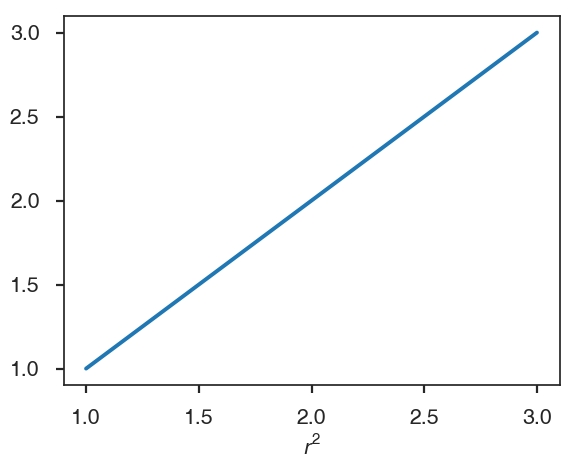

In [3]:
from matplotlib import mathtext

class HelveticaFontConstants(mathtext.FontConstantsBase):
    # Percentage of x-height that superscripts are raised from the baseline
    sup1 = 0.45
    delta = 0.1
    
def set_rcparams():
    
    plt.rcParams['font.sans-serif'] = ['Helvetica',
                                  'DejaVu Sans']
    plt.rcParams['mathtext.fontset'] = 'custom'
    plt.rcParams['mathtext.rm'] = 'Helvetica'
    plt.rcParams['mathtext.it'] = 'Helvetica:italic'
    plt.rcParams['mathtext.bf'] = 'Helvetica:bold'
    plt.rcParams['mathtext.cal'] = 'Helvetica'
    plt.rcParams['font.family'] = ['Helvetica']
    plt.rcParams['axes.labelsize'] = 15.4
    plt.rcParams['axes.titlesize'] = 15.4
    plt.rcParams['font.size'] = 15.4
    plt.rcParams['legend.fontsize'] = 15.4
    plt.rcParams['xtick.labelsize'] = 15.4
    plt.rcParams['ytick.labelsize'] = 15.4
    
    # Register font constants for Helvetica
    mathtext._font_constant_mapping['Helvetica'] = HelveticaFontConstants
    
    
set_rcparams()
plt.plot([1,2,3],[1,2,3])
plt.xlabel('$r^2$')

In [4]:
TEST_MIRS = sorted(['mir153','mir139','mir144','mir223','mir137',
             'mir205','mir143','mir182','mir199a','mir204','mir216b'])

MIRS5 = ['mir1','mir124','mir155','mir7','lsy6']
ALL_MIRS = MIRS5 + TEST_MIRS

# PREDICT_DIR = '/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/final/predictions_simple_xval_4_16_16/'
# LOG_DIR = '/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_4_16_16/'
# LET7_SITES = pd.read_csv('/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/final/let7_mask.txt', sep='\t', index_col=0)
# LET7_MASK = pd.read_csv('/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/final/let7_mask.txt', sep='\t', index_col=0)
MERGED = pd.read_csv('/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/no_baseline_analysis/merged.txt', sep='\t', index_col=0)
print(len(MERGED))
MERGED.head()

4257


let7      lsy6      mir1    mir124    mir137    mir139  \
NM_000019  5.472150  5.538776  5.577042  5.649801  5.406582  5.492721   
NM_000031  3.218292  3.063797  3.151540  3.115912  3.189741  3.013276   
NM_000046  4.081735  4.241248  4.070133  4.320221  3.841543  4.060270   
NM_000064  2.484637  2.383718  2.251052  2.343596  2.386032  2.689175   
NM_000086  4.167220  4.529920  4.291420  4.354404  4.371496  4.481273   

             mir143    mir144    mir153    mir155    mir182   mir199a  \
NM_000019  5.606229  5.570015  5.530304  5.684962  5.748195  5.631658   
NM_000031  3.319983  3.343367  3.082736  3.293842  3.204595  3.249728   
NM_000046  4.090714  4.291743  4.098148  4.202921  4.064411  4.174584   
NM_000064  2.633429  2.548864  3.206306  2.171506  3.123980  2.659572   
NM_000086  4.430950  4.458488  4.478760  4.438987  4.477172  4.605044   

             mir204    mir205   mir216b    mir223      mir7  \
NM_000019  5.551187  5.495191  5.559670  5.615164  5.677916   
NM_000031  3.060618  2.950676  3.074226  3.191090  3.515169   
NM_000046  4.290780  3.963390  3.911022  4.160757  3.020435   
NM_000064  2.856986  3.027227  2.453375  2.744231  2.674473   
NM_000086  4.642986  4.597139  4.603487  4.514120  3.898598   

                                                    sequence  orf_length  \
NM_000019  ACAACCTCTGCTATTTAAGGAGACAACCCTATGTGACCAGAAGGCC...        1281   
NM_000031  TGGAGACAGTGCCAGGCCCAAGAACTAGAACTTTAAAACGTTCCCG...         990   
NM_000046  GATTTCAGGGAGGCTAGAAAACCTTTCAATTGGAAGTTGGACCTCA...        1599   
NM_000064     CCACACCCCCATTCCCCCACTCCAGATAAAGCTTCAGTTATATCTC        4989   
NM_000086  TACTCGGGATCCTCAGGACGCAGGTCACATTCACCTGTGGGCAGAG...        1314   

           utr_length  ix   nosite1   nosite2   nosite3  
NM_000019         209   0  5.586729  5.584360  5.586729  
NM_000031        1987   1  3.319983  3.135829  3.319983  
NM_000046          53   2  4.050145  4.050145  4.050145  
NM_000064          46   3  2.660165  2.660165  2.660165  
NM_000086         236   4  4.495382  4.498903  4.500506

In [3]:
# shuffle_dir = '/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/no_baseline_analysis/convnet_shuffle'
# if not os.path.isdir(shuffle_dir):
#     os.makedirs(shuffle_dir)

# np.random.seed(0)
# num_shuffles = 25
# for shuffle_ix in range(10):
#     shuffle_orders = {}
#     for mir in TEST_MIRS:
#         shuffles = []
#         for _ in range(num_shuffles):
#             other_mirs = [m for m in ALL_MIRS if m != mir]
#             while True:
#                 new_order = np.random.permutation(other_mirs).tolist()
#                 keep = True
#                 for ix, omir in enumerate(other_mirs):
#                     if new_order[ix] == omir:
#                         keep = False
#                         break
#                 if keep:
#                     break
#             shuffles.append((np.random.choice(other_mirs), new_order))
#         shuffle_orders[mir] = shuffles
        
#     with open(os.path.join(shuffle_dir, 'shuffle_orders_{}.pickle'.format(shuffle_ix)), 'wb') as outfile:
#         pickle.dump(shuffle_orders, outfile)

In [5]:
def get_features(utr, kds_df, min_dist=6):
    kds_temp = {x:y for (x,y) in zip(kds_df['12mer'], kds_df['log_kd'])}
    seq = 'A' + utr[:11]
    all_seqs = []

    for loc, nt in enumerate(utr[11:] + 'TTT'):
        seq = seq[1:] + nt
        if seq in kds_temp:
            all_seqs.append(seq)
                
    return all_seqs

def get_features_no_overlap(utr, kds_df, min_dist=6):
    kds_temp = {x:y for (x,y) in zip(kds_df['12mer'], kds_df['log_kd'])}
    prev_loc = -12
    prev_seq = ''
    pred_kd = 0
    seq = 'A' + utr[:11]
    all_seqs = []

    for loc, nt in enumerate(utr[11:] + 'TTT'):
        seq = seq[1:] + nt
        if seq in kds_temp:
            new_kd = kds_temp[seq]
            if (loc - prev_loc) < min_dist:
                if new_kd < prev_kd:
                    all_seqs[-1] = seq
                    prev_loc = loc
                    prev_kd = new_kd
                else:
                    continue
            else:
                all_seqs.append(seq)
                prev_loc = loc
                prev_kd = new_kd
                
    return all_seqs

In [6]:
def calc_nbound(kds, num_seqs, freeAgo):
    nbound_ind = 1 / (1 + np.exp(kds - freeAgo))
    nbound = np.zeros(len(num_seqs))
    current_ix = 0
    for ix, num_seq in enumerate(num_seqs):
        nbound[ix] = np.sum(nbound_ind[current_ix: current_ix + num_seq])
        current_ix += num_seq
        
    assert(current_ix == len(kds))
    return nbound

# def get_logfc(kds_guide, num_seqs_guide, kds_pass, num_seqs_pass, let7_sites, let7_mask, utr_len, params):
#     nbound_guide = calc_nbound(kds_guide, num_seqs_guide, params['freeAgo_guide'])
#     nbound_pass = calc_nbound(kds_pass, num_seqs_pass, params['freeAgo_pass'])
#     nbound_init_utr = utr_len * np.exp(params['utr_coef'])
#     nbound_let7 = np.sum(np.multiply(1 / (1 + np.exp(let7_sites.values - params['freeAGO_let7'])),
#                                      let7_mask.values), axis=1)
    
#     pred_init = np.log1p((nbound_init_utr + nbound_let7) / np.exp(params['decay']))
#     pred = np.log1p((nbound_guide + nbound_pass + nbound_init_utr + nbound_let7) / np.exp(params['decay']))
    
#     return pred - pred_init

def get_logfc_simple(kds_guide, num_seqs_guide, kds_pass, num_seqs_pass, utr_len, params):
    nbound_guide = calc_nbound(kds_guide, num_seqs_guide, params['freeAgo_guide'])
    nbound_pass = calc_nbound(kds_pass, num_seqs_pass, params['freeAgo_pass'])
    nbound_init_utr = utr_len * np.exp(params['utr_coef'])
    
    pred_init = np.log1p((nbound_init_utr) * np.exp(params['decay']))
    pred = np.log1p((nbound_guide + nbound_pass + nbound_init_utr) * np.exp(params['decay']))
    
    return -1 * (pred - pred_init)

In [1]:
import numpy as np
blah = []
blah += [[1],[2]]
blah

[[1], [2]]

In [7]:
mir = 'mir137'
PREDICT_DIR = '/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/final/predictions_simple_xval_4_16_16_with_seqs/'
LOG_DIR = '/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_4_16_16/'

paramfile = pd.read_csv('{}/{}/fitted_params.txt'.format(LOG_DIR, mir), sep='\t', index_col=0, header=None)

input_utr_len = MERGED.iloc[:32][['utr_length']].values
freeAGO = pd.read_csv('{}/{}/freeAGO_final.txt'.format(LOG_DIR, mir), sep='\t').set_index('mir')
print(freeAGO)
other_mirs = list(freeAGO.index)

            guide  passenger
mir                         
lsy6    -5.705636  -7.445100
mir1    -5.594452  -5.545066
mir124  -5.801997  -9.500032
mir139  -5.656018  -6.002529
mir143  -5.390882  -6.132655
mir144  -5.986695  -5.828343
mir153  -5.155996  -6.233342
mir155  -5.645193  -7.869408
mir182  -5.982974  -6.280287
mir199a -5.231668  -6.266158
mir204  -5.468823  -5.913035
mir205  -5.598037  -5.954401
mir216b -5.312310  -5.972086
mir223  -5.100439  -6.681544
mir7    -5.966597  -7.721801


In [95]:
pred2 = np.zeros((32, 15))
kds_3d_guide = np.zeros((32, 15, 150))
kds_3d_pass = np.zeros((32, 15, 150))
with open(os.path.join(PREDICT_DIR, '{}.pickle'.format(mir)), 'rb') as infile:
    kds = pickle.load(infile)
    
for oix, omir in enumerate(other_mirs):
    kds_guide = kds[omir]
    num_seqs_guide = kds_guide['num_seqs']
    kds_guide = -1 * np.array(kds_guide['KDs'])
    
    kds_pass = kds[omir+'*']
    num_seqs_pass = kds_pass['num_seqs']
    kds_pass = -1 * np.array(kds_pass['KDs'])
    
    temp_kds_guide, temp_numseqs_guide, temp_kds_pass, temp_numseqs_pass = [], [], [], []
    
    current_ix = 0
    for ix, num_seq in enumerate(num_seqs_guide):
        temp_kds_guide += list(kds_guide[current_ix: current_ix + num_seq])
        kds_3d_guide[ix,oix,:num_seq] = kds_guide[current_ix: current_ix + num_seq]
        temp_numseqs_guide.append(num_seq)
        current_ix += num_seq
        if ix == 31:
            break

    current_ix = 0
    for ix, num_seq in enumerate(num_seqs_pass):
        temp_kds_pass += list(kds_pass[current_ix: current_ix + num_seq])
        kds_3d_pass[ix,oix,:num_seq] = kds_pass[current_ix: current_ix + num_seq]
        temp_numseqs_pass.append(num_seq)
        current_ix += num_seq
        if ix == 31:
            break
            
    params = {'freeAgo_guide': freeAGO.loc[omir]['guide'],
                              'freeAgo_pass': freeAGO.loc[omir]['passenger'],
                              'utr_coef': paramfile.loc['utr_coef'][1],
                              'decay': paramfile.loc['decay'][1]}
            
    pred2[:, oix] = get_logfc_simple(temp_kds_guide, temp_numseqs_guide,
                                     temp_kds_pass, temp_numseqs_pass,
                                     input_utr_len.flatten(), params)

In [113]:
current_ix_dict_guide

{'mir137': 4586}

In [114]:
input_kds = []
input_num_seqs = []
with open(os.path.join(PREDICT_DIR, '{}.pickle'.format(mir)), 'rb') as infile:
    kds = pickle.load(infile)
    
current_ix_dict_guide = {omir: 0 for omir in other_mirs}
current_ix_dict_pass = {omir: 0 for omir in other_mirs}

for ix in range(32):
    for oix, omir in enumerate(other_mirs):
        kds_guide = kds[omir]
        num_seqs_guide = kds_guide['num_seqs']
        kas_guide = np.array(kds_guide['KDs'])
        num_seq = num_seqs_guide[ix]
        input_kds += list(kas_guide[current_ix_dict_guide[omir]: current_ix_dict_guide[omir] + num_seq])
        input_num_seqs.append(num_seq)
        current_ix_dict_guide[omir] += num_seq

        kds_pass = kds[omir+'*']
        num_seqs_pass = kds_pass['num_seqs']
        kas_pass = np.array(kds_pass['KDs'])
        num_seq = num_seqs_pass[ix]
        input_kds += list(kas_pass[current_ix_dict_pass[omir]: current_ix_dict_pass[omir] + num_seq])
        input_num_seqs.append(num_seq)
        current_ix_dict_pass[omir] += num_seq

input_kds = np.array(input_kds + [0]*10).reshape([-1,1])
input_num_seqs = np.array(input_num_seqs)
print(len(input_num_seqs), 32*15*2, input_kds.shape, np.max(input_num_seqs))

960 960 (9114, 1) 150


In [115]:
log_dir = '/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_4_16_16/'
tf.reset_default_graph()
with tf.Session() as sess:

    sess.run(tf.global_variables_initializer())
    latest = tf.train.latest_checkpoint('{}/{}/saved'.format(log_dir, mir))
    print(latest)
    saver = tf.train.import_meta_graph(latest + '.meta')
    saver.restore(sess, latest)

    _keep_prob = tf.get_default_graph().get_tensor_by_name('keep_prob:0')
    _phase_train = tf.get_default_graph().get_tensor_by_name('phase_train:0')
#     _combined_x = tf.get_default_graph().get_tensor_by_name('biochem_x:0')
    _repression_max_size = tf.get_default_graph().get_tensor_by_name('train/repression_max_size:0')
    _repression_split_sizes = tf.get_default_graph().get_tensor_by_name('train/repression_split_sizes:0')
    _utr_len = tf.get_default_graph().get_tensor_by_name('utr_len:0')
    _pred_ka = tf.get_default_graph().get_tensor_by_name('final_layer/pred_ka:0')
    _pred_logfc = tf.get_default_graph().get_tensor_by_name('train/pred_logfc_net_train:0')
    _intermed = tf.get_default_graph().get_tensor_by_name('train/Reshape_2:0')
    
    _freeago_all = tf.get_default_graph().get_tensor_by_name('train/freeAGO_all_train:0')
#     _utr_coef = tf.get_default_graph().get_tensor_by_name('utr_coef_toggle_train:0')

    print(_intermed)

#     i = 0
#     for op in tf.get_default_graph().get_operations():
#         name = str(op.name)
#         if 'strided' in name:
#             continue
#         if 'grad' in name:
#             continue
#         if ('Pad' in name) or ('Adam' in name):
#             continue
#         if str(name)[:6] == 'train/':
#             print(name)

    feed_dict = {
                    _keep_prob: 1.0,
                    _phase_train: False,
                    _repression_max_size: np.max(input_num_seqs),
                    _repression_split_sizes: input_num_seqs,
                    _utr_len: input_utr_len,
                    _pred_ka: input_kds,
                }
    
    intermed = sess.run(_intermed, feed_dict=feed_dict)

    pred = sess.run(_pred_logfc, feed_dict=feed_dict)
#     print(sess.run(_freeago_all))

/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_4_16_16/mir137/saved/model-100
INFO:tensorflow:Restoring parameters from /lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_4_16_16/mir137/saved/model-100
Tensor("train/Reshape_2:0", shape=(32, 30, ?), dtype=float32)


In [116]:
print(kds_3d_guide[0,0,:5])
print(kds_3d_pass[0,0,:6])
print(-1*intermed[0,0:2,:6])

[-0.47231093 -2.24477792 -1.72153115 -0.64296651 -0.54673719]
[ 0.22490874  2.36344981  0.09106055  0.96026886 -0.97727776 -0.19307956]
[[-0.47231093 -2.24477792 -1.72153115 -0.64296651 -0.54673719 -0.        ]
 [ 0.22490874  2.36344981  0.09106055  0.96026886 -0.97727776 -0.19307956]]


In [104]:
kds[other_mirs[1]]['KDs'][:10]

[1.541126,
 0.88540983,
 1.5314884,
 2.2865431,
 5.9147239,
 1.2866842,
 0.5137552,
 2.1704602,
 1.7593521,
 -0.14286473]

In [117]:
print(kds_3d_guide[0,1,:5])
print(kds_3d_pass[0,1,:5])
print(-1*intermed[0,2:4,:5])

[-1.54112601 -0.88540983 -1.53148842  0.          0.        ]
[-0.45174286  1.40857983  0.3376697   0.          0.        ]
[[-1.54112601 -0.88540983 -1.53148842 -0.         -0.        ]
 [-0.45174286  1.40857983  0.3376697  -0.         -0.        ]]


In [105]:
input_num_seqs[:4]

array([5, 6, 3, 3])

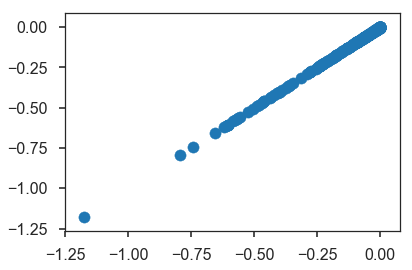

In [118]:
plt.scatter(pred, pred2)

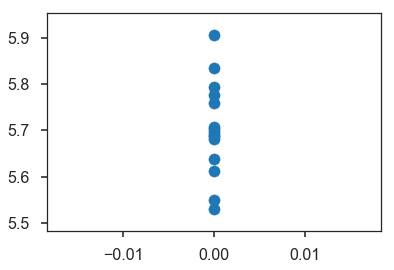

In [80]:
ix = 27
xs = pred2[ix,:]
ys = MERGED.iloc[ix][other_mirs].values
plt.scatter(xs, ys)

In [5]:
biochem_baselines = pd.read_csv('/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/no_baseline_analysis/biochem_baselines.txt',
                                sep='\t', index_col='gene')
biochem_baselines.head()

baseline
gene               
NM_000019  5.610010
NM_000031  3.349284
NM_000046  3.985318
NM_000064  2.396410
NM_000086  4.372329

/lab/bartel4_ata/kathyl/RNA_Seq/analysis/rnaseq/lib/python3.4/site-packages/matplotlib/mathtext.py:851: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


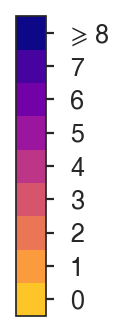

In [6]:
set_rcparams()
num_colors = 9
cmap = plt.cm.plasma

# fig, ax = plt.subplots(figsize=(5,5))
fig = plt.figure(figsize=(5,5))
ax_colorbar = fig.add_axes([0., 0.03, 0.06, 0.6])
new_cmap = predict_helpers.discrete_colorbar(ax_colorbar, plt.cm.plasma, num_colors, 'vertical')

In [8]:
importlib.reload(predict_helpers)
sns.set_style('ticks')
sns.set_context('poster')
PREDICT_DIR = '/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/final/predictions_simple_xval_4_16_16/'
LOG_DIR = '/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_4_16_16/'
BASELINES_DICT = {m: biochem_baselines['baseline'].values for m in ALL_MIRS}
all_kds17 = predict_helpers.get_pred_df(LOG_DIR, PREDICT_DIR, MERGED, ALL_MIRS, ALL_MIRS, BASELINES_DICT)

In [9]:
all_kds17[0].to_csv('/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/no_baseline_analysis/convnet_preds17.txt',sep='\t')


In [7]:
importlib.reload(predict_helpers)
sns.set_style('ticks')
sns.set_context('poster')
PREDICT_DIR = '/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/final/predictions_simple_xval_4_16_16/'
LOG_DIR = '/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_4_16_16/'
BASELINES_DICT = {m: biochem_baselines['baseline'].values for m in ALL_MIRS}
all_kds = predict_helpers.get_pred_df(LOG_DIR, PREDICT_DIR, MERGED, TEST_MIRS, ALL_MIRS, BASELINES_DICT)

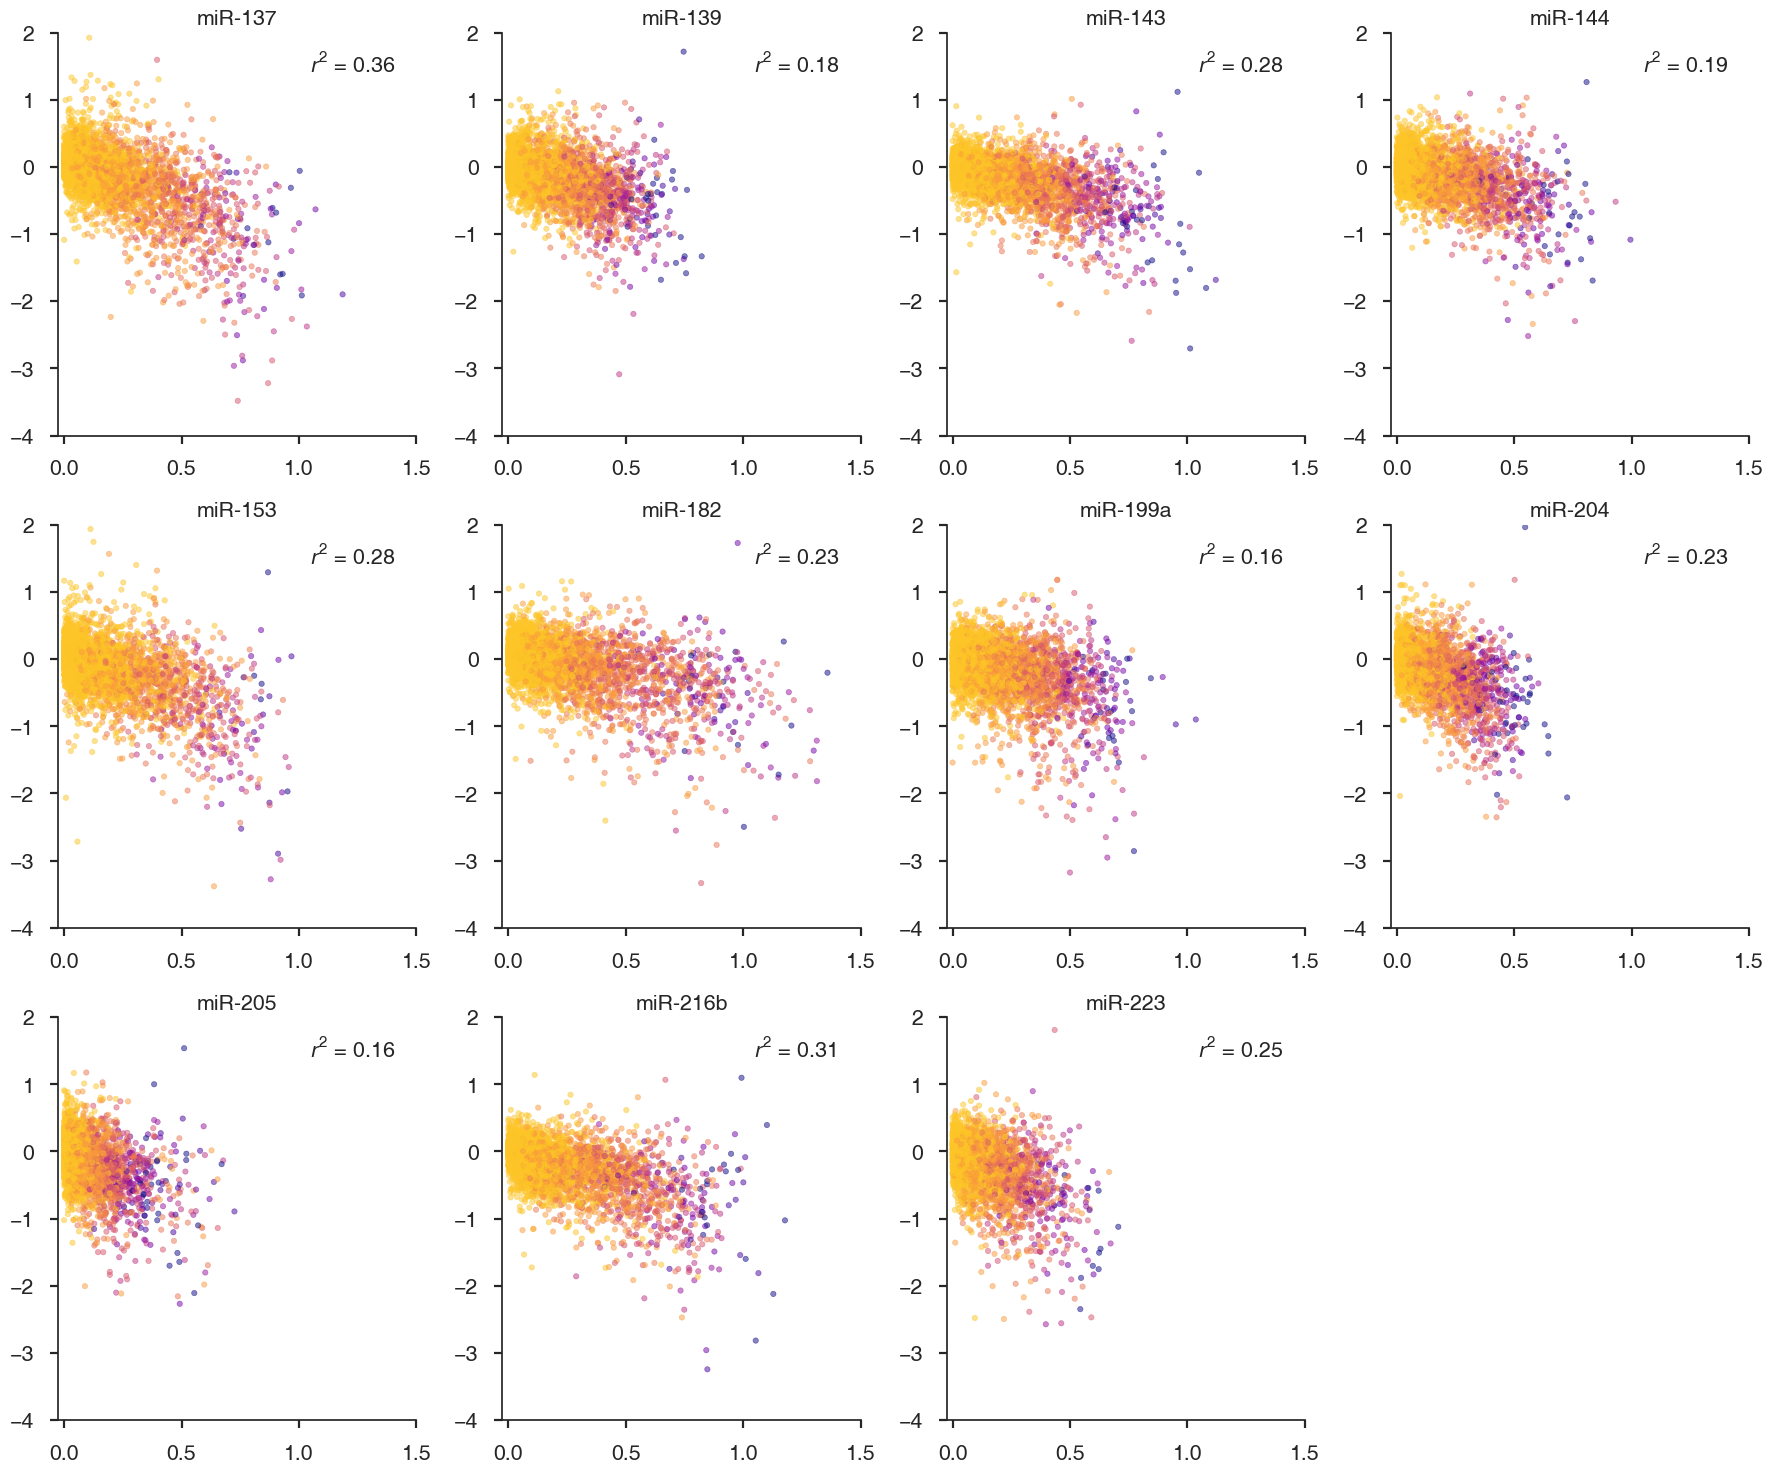

In [31]:
importlib.reload(predict_helpers)
set_rcparams()
OUTFILE = '/lab/bartel4_ata/kathyl/RNA_Seq/analysis/figures/post_sub/nn_all_kds.png'
predict_helpers.plot_results(all_kds[0], num_colors, new_cmap, TEST_MIRS, OUTFILE)

In [12]:
stats.linregress(all_kds[0]['pred'], all_kds[0]['log2fc_bayes'])[2]**2

0.21494195207620242

In [14]:
stats.linregress(pred_df['pred'], pred_df['log2fc_bayes'])[2]**2

0.21494195207620234

In [23]:
# sns.set_style('ticks')
# sns.set_context('poster')
# PREDICT_DIR = '/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/final/predictions_simple_xval_4_16_16_fix_getseqs2/'
# LOG_DIR = '/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_4_16_16_fix_getseqs2/'
# OUTFILE = '/lab/bartel4_ata/kathyl/RNA_Seq/analysis/figures/new_analysis/nn_all_kds_fix_getseqs2.png'
# # BASELINES_DICT = {m: biochem_baselines['baseline'].values for m in ALL_MIRS}
# all_kds_fgs = predict_helpers.get_pred_df(LOG_DIR, PREDICT_DIR, MERGED, TEST_MIRS, ALL_MIRS, all_kds[-1])
# predict_helpers.plot_results(all_kds_fgs[0], TEST_MIRS, OUTFILE)

In [16]:
all_kds[0].to_csv('/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/no_baseline_analysis/convnet_preds.txt',sep='\t')
pred_df = pd.read_csv('/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/no_baseline_analysis/convnet_preds.txt',
                      sep='\t', index_col=0)
pred_df.head()

log2_bayes_intercept  log2_tpm  log2fc_bayes  log2fc_method3  \
NM_000019              8.093533  7.800049     -0.293484       -0.259898   
NM_000031              4.831996  4.601823     -0.230173       -0.187901   
NM_000046              5.749598  5.542175     -0.207423       -0.300949   
NM_000064              3.457289  3.442316     -0.014973       -0.395490   
NM_000086              6.307937  6.306735     -0.001202       -0.186122   

              mir   nosite3  num_canon      pred  
NM_000019  mir137  8.059946          0 -0.031005  
NM_000031  mir137  4.789724          2 -0.546857  
NM_000046  mir137  5.843124          0 -0.010194  
NM_000064  mir137  3.837806          0 -0.004966  
NM_000086  mir137  6.492857          0 -0.014487

In [19]:
num_colors = 9
ax_colorbar = fig.add_axes([1.1, 0.2, 0.015, 0.6])
new_cmap = predict_helpers.discrete_colorbar(ax_colorbar, plt.cm.plasma, num_colors, 'vertical')

kwargs = {'vmin': 0,
          'vmax': num_colors-1,
          'cmap': new_cmap,
          's':15,
          'alpha': 0.6}

In [9]:
# with open('/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/no_baseline_analysis/convnet_baselines.pickle','wb') as outfile:
#     pickle.dump(all_kds[-1], outfile)

In [12]:
### Refit last layer using only canonical sites

In [7]:
mir = 'mir1'
PREDICT_DIR0 = '/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/final/predictions_simple_xval_4_16_16_with_seqs/'

other_mirs = [m for m in ALL_MIRS if m != mir]
num_mirs = len(ALL_MIRS)
num_genes = len(MERGED)
num_kds_guide = 356
num_kds_pass = 416
y_vals = MERGED[other_mirs].values
input_utr_len = MERGED[['utr_length']].values
x_guide, mask_guide = np.zeros([num_genes, num_mirs-1, num_kds_guide]), np.zeros([num_genes, num_mirs-1, num_kds_guide])
x_pass, mask_pass = np.zeros([num_genes, num_mirs-1, num_kds_pass]), np.zeros([num_genes, num_mirs-1, num_kds_pass])
with open(os.path.join(PREDICT_DIR0, '{}.pickle'.format(mir)), 'rb') as infile:
    kds = pickle.load(infile)

for oix, omir in enumerate(other_mirs):

    kds_guide = kds[omir]
    num_seqs_guide = kds_guide['num_seqs']
    kds_guide = -1 * np.array(kds_guide['KDs'])
    assert (len(num_seqs_guide) == num_genes)
    current_ix = 0
    for ix, num_seq in enumerate(num_seqs_guide):
        x_guide[ix, oix, :num_seq] = kds_guide[current_ix: current_ix + num_seq]
        mask_guide[ix, oix, :num_seq] = 1
        current_ix += num_seq

    kds_pass = kds[omir+'*']
    num_seqs_pass = kds_pass['num_seqs']
    kds_pass = -1 * np.array(kds_pass['KDs'])
    assert (len(num_seqs_pass) == num_genes)
    current_ix = 0
    for ix, num_seq in enumerate(num_seqs_pass):
        x_pass[ix, oix, :num_seq] = kds_pass[current_ix: current_ix + num_seq]
        mask_pass[ix, oix, :num_seq] = 1
        current_ix += num_seq

# print(x_guide.shape)
# params, nbound, pred = predict_helpers.refit_last_layer(x_guide, x_pass,
#                           mask_guide, mask_pass,
#                           y_vals, input_utr_len, num_genes, num_mirs-1, maxiter=200)

In [11]:
x_guide[1,0,:]

array([ 0.01238465,  0.27647227, -0.48040748, -0.31532168, -2.38132048,
        0.22570848,  0.65245837, -0.80478936, -1.34718788, -0.70720494,
       -0.74326336, -0.65311968, -0.14970481,  0.182347  , -0.40392578,
       -0.58531654, -0.57670307, -1.40453804, -0.18554494, -1.17575073,
       -0.70541114,  0.91508985,  0.03542408, -0.55478227, -0.69349003,
       -1.44641626, -0.53275228,  0.06786227, -0.86493325,  0.82939893,
       -0.78805268, -1.88222826,  0.22762194, -1.93553162,  0.01293093,
        0.54144889, -0.05134165,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [ ]:
mir = 'mir137'
PREDICT_DIR1 = '/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/final/predictions_simple_xval_4_16_16_test_only_canon/'

other_mirs = [m for m in ALL_MIRS if m != mir]
num_mirs = len(ALL_MIRS)
num_genes = len(MERGED)
num_kds_guide = 30
num_kds_pass = 40
y_vals = MERGED[other_mirs].values
input_utr_len = MERGED[['utr_length']].values
x_guide, mask_guide = np.zeros([num_genes, num_mirs-1, num_kds_guide]), np.zeros([num_genes, num_mirs-1, num_kds_guide])
x_pass, mask_pass = np.zeros([num_genes, num_mirs-1, num_kds_pass]), np.zeros([num_genes, num_mirs-1, num_kds_pass])
with open(os.path.join(PREDICT_DIR1, '{}.pickle'.format(mir)), 'rb') as infile:
    kds = pickle.load(infile)

for oix, omir in enumerate(other_mirs):

    kds_guide = kds[omir]
    num_seqs_guide = kds_guide['num_seqs']
    kds_guide = -1 * np.array(kds_guide['KDs'])
    assert (len(num_seqs_guide) == num_genes)
    current_ix = 0
    for ix, num_seq in enumerate(num_seqs_guide):
        x_guide[ix, oix, :num_seq] = kds_guide[current_ix: current_ix + num_seq]
        mask_guide[ix, oix, :num_seq] = 1
        current_ix += num_seq

    kds_pass = kds[omir+'*']
    num_seqs_pass = kds_pass['num_seqs']
    kds_pass = -1 * np.array(kds_pass['KDs'])
    assert (len(num_seqs_pass) == num_genes)
    current_ix = 0
    for ix, num_seq in enumerate(num_seqs_pass):
        x_pass[ix, oix, :num_seq] = kds_pass[current_ix: current_ix + num_seq]
        mask_pass[ix, oix, :num_seq] = 1
        current_ix += num_seq

print(x_guide.shape)
params_c, nbound_c, pred_c = predict_helpers.refit_last_layer(x_guide, x_pass,
                          mask_guide, mask_pass,
                          y_vals, input_utr_len, num_genes, num_mirs-1, maxiter=200)

In [ ]:
for ix in range(1000):
    ys = MERGED.iloc[ix][other_mirs].values.astype(float)
    xs1 = pred[ix,:].astype(float)
    if np.std(xs1) > 0.3:
        plt.scatter(xs1, ys)
        xs2 = pred_c[ix, :]
        plt.scatter(xs2, ys)
        print(stats.linregress(xs1, ys))
        print(stats.linregress(xs2, ys))
        break


In [46]:
nbound_utr = input_utr_len.flatten()*np.exp(params[0])
nbound_all = nbound_utr + nbound[:,6]
pred_recalc = -1 * (np.log1p(nbound_all*params[1]) - np.log1p(nbound_utr*params[1]))


In [47]:
nbound_utr = input_utr_len.flatten()*np.exp(params[0])
nbound_all = nbound_utr + nbound_c[:,6]
pred_recalc_c = -1 * (np.log1p(nbound_all*params[1]) - np.log1p(nbound_utr*params[1]))

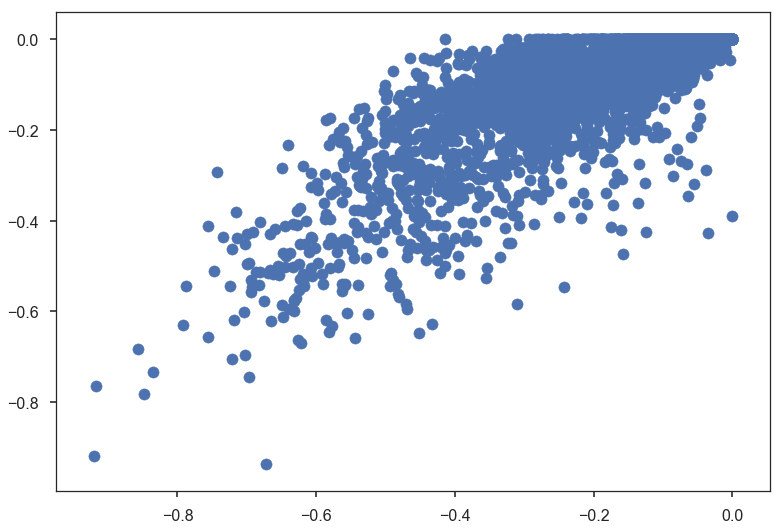

In [50]:
# plt.scatter(nbound[:,6], nbound_c[:,6])
plt.scatter(pred_recalc, pred_recalc_c)

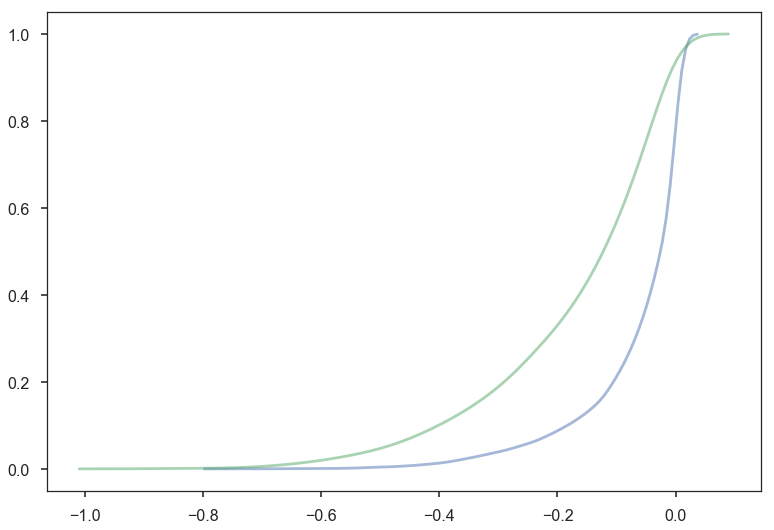

In [39]:
sns.kdeplot(pred_c[:,6], alpha=0.5, cumulative=True)
sns.kdeplot(pred[:,6], alpha=0.5, cumulative=True)

In [148]:
importlib.reload(predict_helpers)
PREDICT_DIR = '/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/final/predictions_simple_xval_4_16_16_test_only_canon/'
NEW_LOG_DIR = '/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/no_baseline_analysis/model_preds_only_canon_retrain/'
num_mirs = len(ALL_MIRS)
num_genes = len(MERGED)
num_kds_guide = 30
num_kds_pass = 40
input_utr_len = MERGED[['utr_length']].values

if not os.path.isdir(NEW_LOG_DIR):
    os.makedirs(NEW_LOG_DIR)

for mir_ix, mir in enumerate(TEST_MIRS):
    other_mirs = [m for m in ALL_MIRS if m != mir]
    y_vals = MERGED[other_mirs].values
    x_guide, mask_guide = np.zeros([num_genes, num_mirs-1, num_kds_guide]), np.zeros([num_genes, num_mirs-1, num_kds_guide])
    x_pass, mask_pass = np.zeros([num_genes, num_mirs-1, num_kds_pass]), np.zeros([num_genes, num_mirs-1, num_kds_pass])
    with open(os.path.join(PREDICT_DIR, '{}.pickle'.format(mir)), 'rb') as infile:
        kds = pickle.load(infile)
        
    for oix, omir in enumerate(other_mirs):

        kds_guide = kds[omir]
        num_seqs_guide = kds_guide['num_seqs']
        kds_guide = -1 * np.array(kds_guide['KDs'])
        assert (len(num_seqs_guide) == num_genes)
        current_ix = 0
        for ix, num_seq in enumerate(num_seqs_guide):
            x_guide[ix, oix, :num_seq] = kds_guide[current_ix: current_ix + num_seq]
            mask_guide[ix, oix, :num_seq] = 1
            current_ix += num_seq

        kds_pass = kds[omir+'*']
        num_seqs_pass = kds_pass['num_seqs']
        kds_pass = -1 * np.array(kds_pass['KDs'])
        assert (len(num_seqs_pass) == num_genes)
        current_ix = 0
        for ix, num_seq in enumerate(num_seqs_pass):
            x_pass[ix, oix, :num_seq] = kds_pass[current_ix: current_ix + num_seq]
            mask_pass[ix, oix, :num_seq] = 1
            current_ix += num_seq
    
    print(x_guide.shape)
    params = predict_helpers.refit_last_layer(x_guide, x_pass,
                              mask_guide, mask_pass,
                              y_vals, input_utr_len, num_genes, num_mirs-1, maxiter=300)
    freeAGO_df = pd.DataFrame({'mir': other_mirs,
                               'guide': params[2].flatten(),
                               'passenger': params[3].flatten()})
    
#     print(mir, freeAGO_df)

    log_dir_mir = os.path.join(NEW_LOG_DIR, mir)
    if not os.path.isdir(log_dir_mir):
        os.makedirs(log_dir_mir)
    freeAGO_df.to_csv(os.path.join(log_dir_mir, 'freeAGO_final.txt'), sep='\t', index=False)
    with open(os.path.join(log_dir_mir, 'fitted_params.txt'), 'w') as outfile:
        outfile.write('decay\t{}\n'.format(np.log(params[1])))
        outfile.write('utr_coef\t{}\n'.format(params[0]))
        print(params[0], params[1])

(4257, 15, 30)
-8.31841 1.18262
(4257, 15, 30)
-8.33874 1.22544
(4257, 15, 30)
-8.44666 1.30827
(4257, 15, 30)
-8.53294 1.43782
(4257, 15, 30)
-8.43453 1.32492
(4257, 15, 30)
-8.23907 1.09502
(4257, 15, 30)
-8.7647 1.70229
(4257, 15, 30)
-8.29415 1.11095
(4257, 15, 30)
-8.52021 1.41928
(4257, 15, 30)
-8.24426 1.06423
(4257, 15, 30)
-8.43399 1.24476


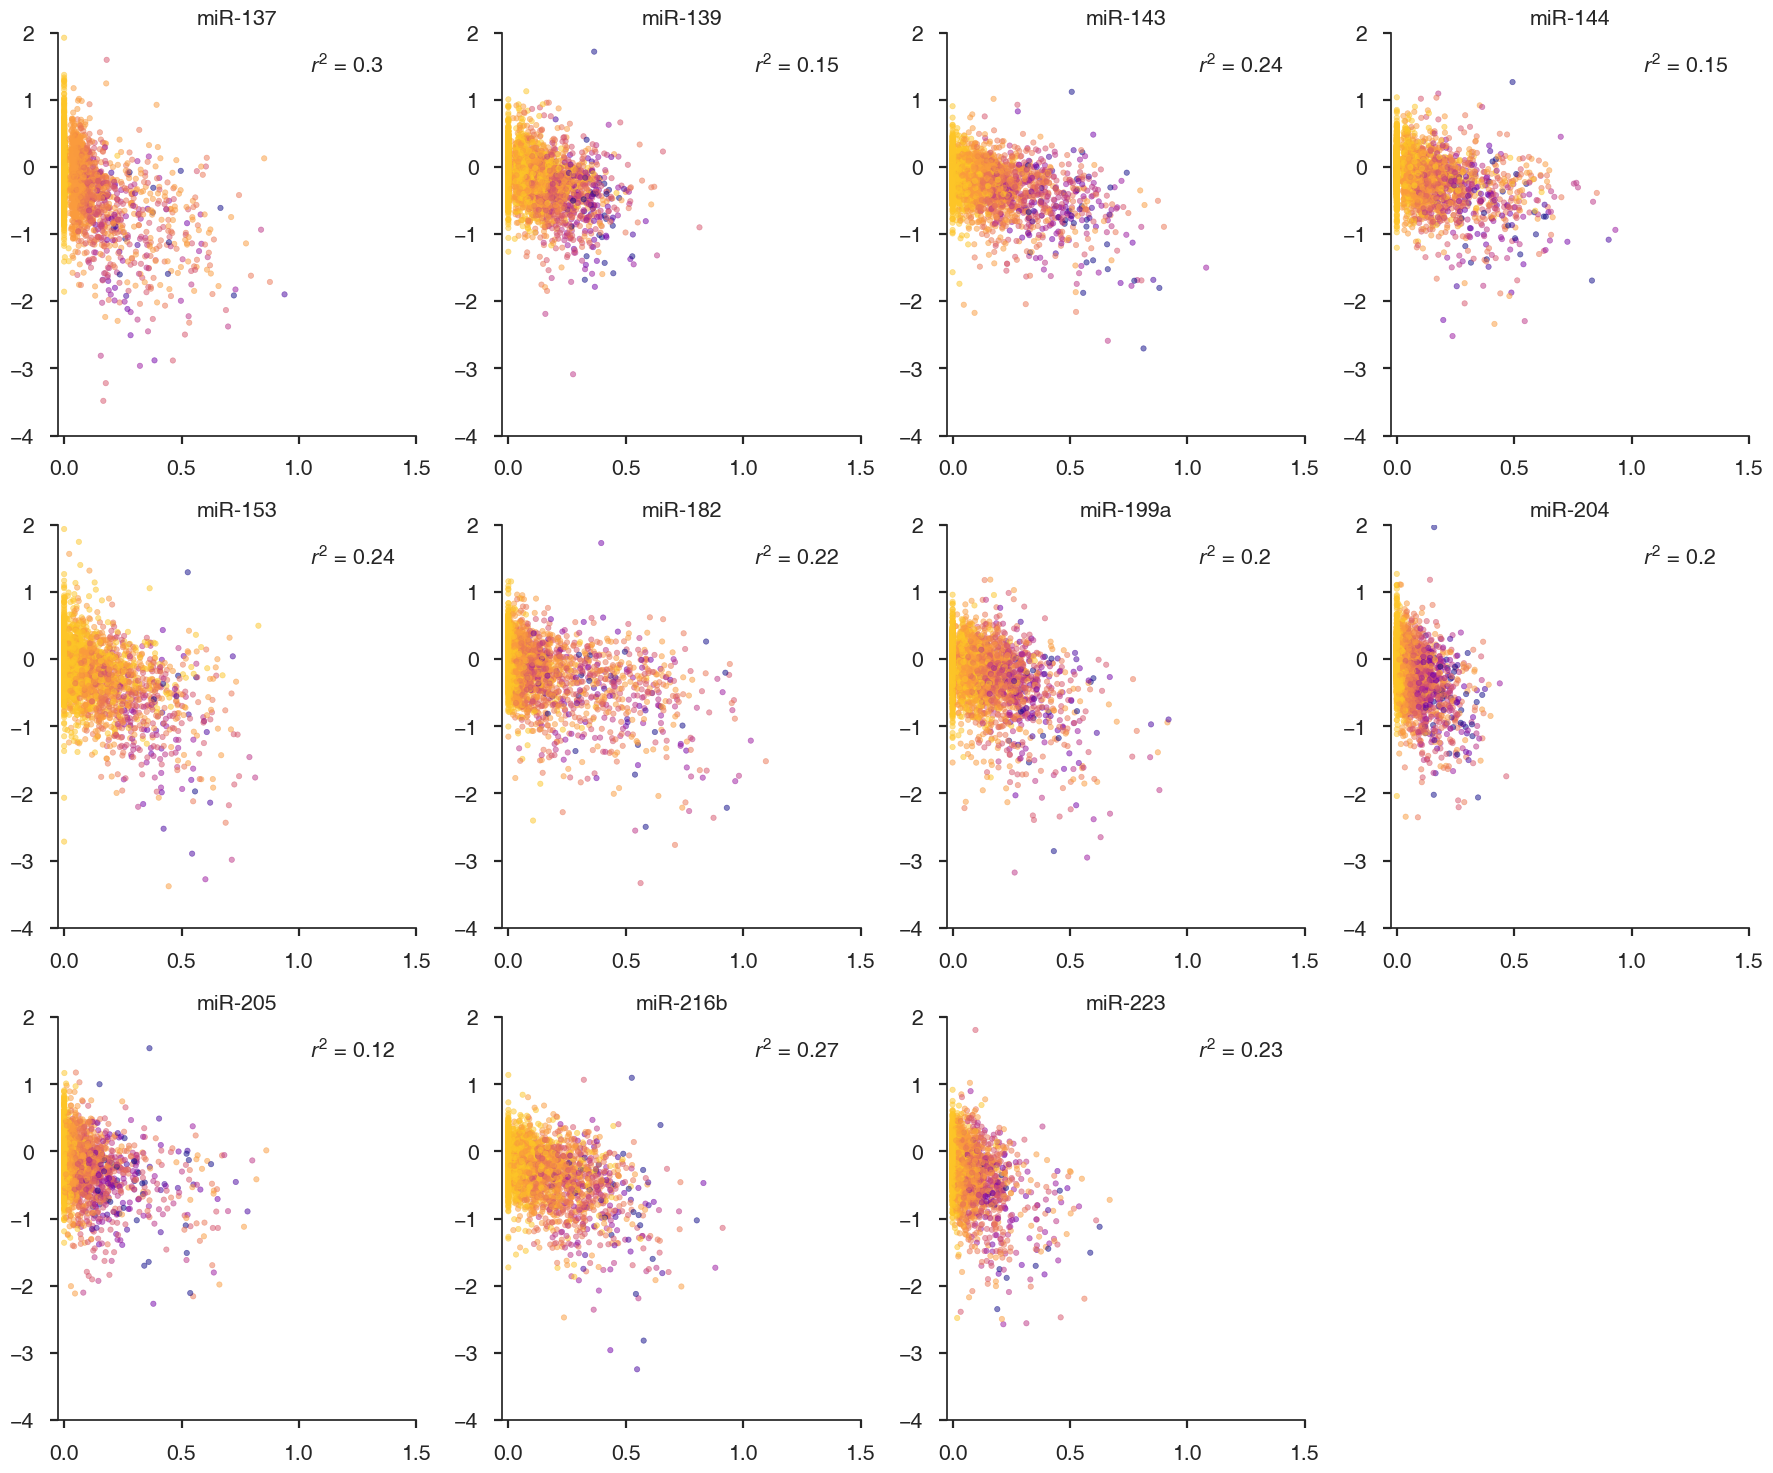

In [19]:
set_rcparams()
PREDICT_DIR = '/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/final/predictions_simple_xval_4_16_16_test_only_canon/'
# LOG_DIR = '/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_4_16_16/'
LOG_DIR = '/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/no_baseline_analysis/model_preds_only_canon_retrain/'
OUTFILE = '/lab/bartel4_ata/kathyl/RNA_Seq/analysis/figures/new_analysis/nn_canon_kds_test.png'
only_canon_test = predict_helpers.get_pred_df(LOG_DIR, PREDICT_DIR, MERGED, TEST_MIRS, ALL_MIRS, all_kds[-1])
# only_canon_test = predict_helpers.get_pred_df(LOG_DIR, PREDICT_DIR, MERGED, TEST_MIRS, ALL_MIRS, None)

predict_helpers.plot_results(only_canon_test[0], num_colors, new_cmap, TEST_MIRS, OUTFILE)

In [8]:
ts7_preds = pd.read_csv('/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/no_baseline_analysis/ts7_preds.txt', sep='\t', index_col=0)
ts7_preds = ts7_preds.rename(columns={'pred_bayes':'pred'})
ts7_preds['log2fc_bayes0'] = ts7_preds['log2fc_bayes']
ts7_5mirs = ts7_preds[ts7_preds['mir'].isin(MIRS5)]
ts7_11mirs = ts7_preds[~ts7_preds['mir'].isin(MIRS5)]
ts7_preds.head()

Gene_ID  log2fc_bayes  log2fc_method1   mir  ngood  nsites  \
ID                                                                            
NM_000031mir1  NM_000031     -0.285285       -0.243013  mir1      1       1   
NM_000112mir1  NM_000112     -2.164919       -0.836514  mir1      0       1   
NM_000117mir1  NM_000117      0.151102        0.029142  mir1      0       1   
NM_000165mir1  NM_000165     -3.915394       -3.144144  mir1      2       3   
NM_000178mir1  NM_000178     -0.471412       -0.469660  mir1      0       1   

                   pred  pred_method1  num_canon  log2fc_bayes0  
ID                                                               
NM_000031mir1 -0.383692     -0.141692          3      -0.285285  
NM_000112mir1 -0.317383     -0.028471          5      -2.164919  
NM_000117mir1 -0.168067     -0.134185          1       0.151102  
NM_000165mir1 -2.255475     -1.573303          5      -3.915394  
NM_000178mir1 -0.183661     -0.126307          1      -0.471412

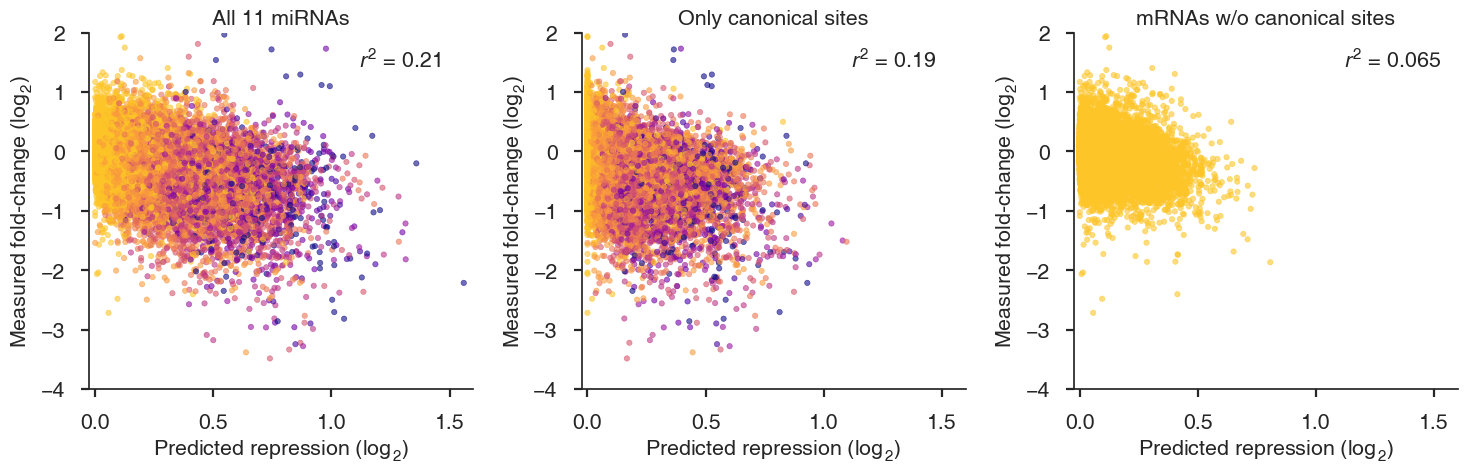

In [21]:
# sns.set_style('ticks')
# sns.set_context('poster')

# num_colors = 9
# cmap = plt.cm.plasma

set_rcparams()

fig, ax = plt.subplots(figsize=(15,5))
axs = [plt.subplot(1,3,ix+1) for ix in [0,1,2]]
xlim = (-0.025,1.6)
ylim = (-4,2)
for ax in axs:
    ax.set_xlabel(r'Predicted repression (log$_2$)')
    ax.set_ylabel(r'Measured fold-change (log$_2$)')
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    
# ax_colorbar = fig.add_axes([0.8, 0.15, 0.015, 0.75])
# ax_colorbar = fig.add_axes([1.1, 0.2, 0.015, 0.6])
# new_cmap = predict_helpers.discrete_colorbar(ax_colorbar, plt.cm.plasma, num_colors, 'vertical')

kwargs = {'vmin': 0,
          'vmax': num_colors-1,
          'cmap': new_cmap,
          's':15,
          'alpha': 0.6}

titles = ['All 11 miRNAs', 'Only canonical sites',
          'mRNAs w/o canonical sites']
all_preds = [all_kds[0], only_canon_test[0], 
             all_kds[0][all_kds[0]['num_canon'] == 0]]
for ix, df in enumerate(all_preds):
    ax = axs[ix]
    xs, ys = -1*df['pred'], df['log2fc_bayes']
    ax.scatter(xs, ys, c=df['num_canon'],**kwargs)
    ax.set_title(titles[ix])
    r2 = stats.linregress(xs, ys)[2]**2
    ax.text(0.7,0.9,r"$r^2$ = {:.2g}".format(r2),
            transform=ax.transAxes)
    sns.despine()
    
plt.tight_layout()
# plt.savefig('/lab/bartel4_ata/kathyl/RNA_Seq/analysis/figures/new_analysis/shuffled_plots_convnet.png',dpi=300)


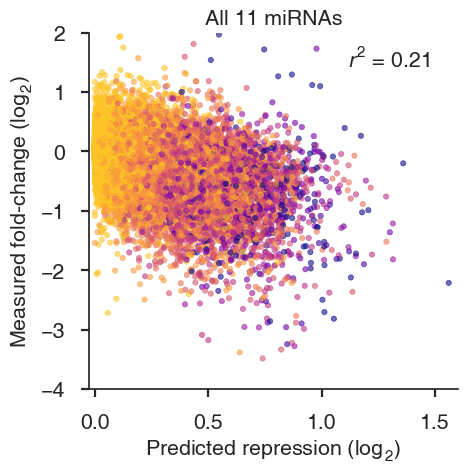

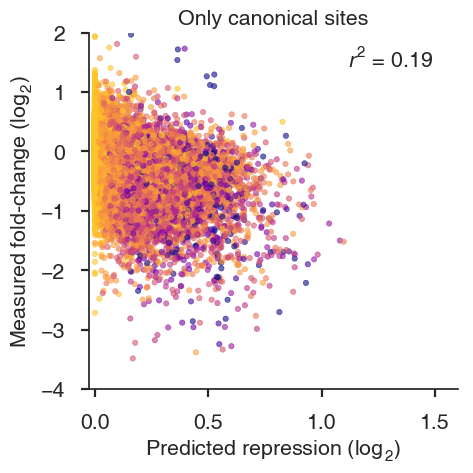

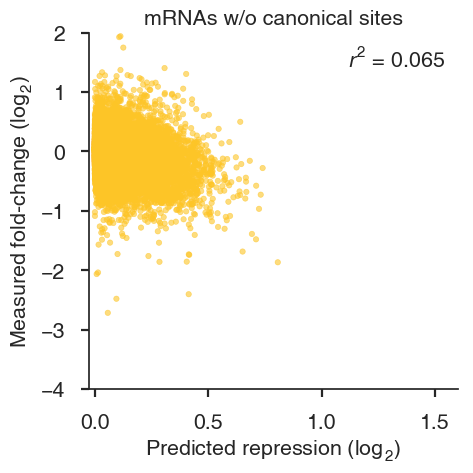

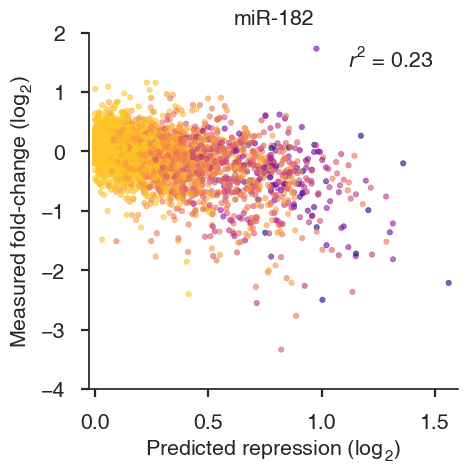

In [32]:
all_preds = [all_kds[0], only_canon_test[0],
             all_kds[0][all_kds[0]['num_canon'] == 0], all_kds[0][all_kds[0]['mir'] == 'mir182']]
titles = ['All 11 miRNAs', 'Only canonical sites','mRNAs w/o canonical sites','miR-182']
for ix, df in enumerate(all_preds):
    fig = plt.figure(figsize=(5,5))
    ax = plt.subplot(1,1,1)
    xs, ys = -1 * df['pred'], df['log2fc_bayes']
    ax.scatter(xs, ys, c=df['num_canon'],**kwargs)
    ax.set_title(titles[ix])
    r2 = stats.linregress(xs, ys)[2]**2
    ax.text(0.7,0.9,r"$r^2$ = {:.2g}".format(r2), transform=ax.transAxes)
    ax.set_xlabel(r'Predicted repression (log$_2$)')
    ax.set_ylabel(r'Measured fold-change (log$_2$)')
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    sns.despine()
    plt.tight_layout()
    fig.savefig('/lab/bartel4_ata/kathyl/RNA_Seq/analysis/figures/post_sub/fig6_plots_{}.png'.format(ix),dpi=300)

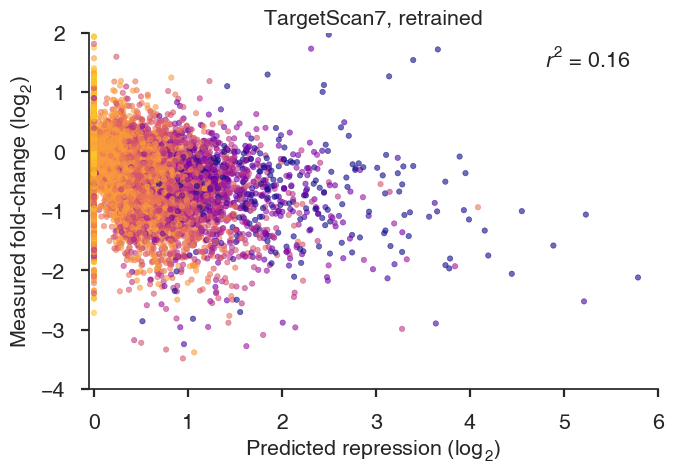

In [33]:
set_rcparams()

fig, ax = plt.subplots(figsize=(7,5))
xs = -1 * ts7_11mirs['pred']
ys = ts7_11mirs['log2fc_bayes']
ax.scatter(xs, ys, c=ts7_11mirs['num_canon'],**kwargs)
ax.set_xlim(-0.05,6.0)
ax.set_ylim(-4,2)
ax.set_title('TargetScan7, retrained')
r2 = stats.linregress(xs, ys)[2]**2
ax.text(0.8,0.9,r"$r^2$ = {:.2g}".format(r2),transform=ax.transAxes)
ax.set_xlabel(r'Predicted repression (log$_2$)')
ax.set_ylabel(r'Measured fold-change (log$_2$)')
sns.despine()
plt.tight_layout()
plt.savefig('/lab/bartel4_ata/kathyl/RNA_Seq/analysis/figures/post_sub/ts7_retrained_11.png',dpi=300)

In [26]:
r2_df = []

# add preds from dfs that refit baseline
names = ['ConvNet, all 12mers', 'Genes w/o canon sites', 'TS7, retrained', 'ConvNet, only canon']
dfs = [all_kds[0], all_kds[0][all_kds[0]['num_canon'] == 0], ts7_11mirs, only_canon_test[0]]
for name, df in zip(names, dfs):
    print(name)
    temp = df[df['mir'].isin(TEST_MIRS)]
    r2 = stats.linregress(temp['pred'], temp['log2fc_bayes'])[2]**2
    r2_df.append(['11 miRNAs', name, r2])
    for mir in TEST_MIRS:
        temp = df[df['mir'] == mir]
        r2 = stats.linregress(temp['pred'], temp['log2fc_bayes'])[2]**2
        r2_df.append([mir.replace('mir','miR-'), name, r2])

# add shuffled dfs
shuffle_dir = '/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/final/predictions_simple_xval_4_16_16_shuffled_pred_dfs'
baselines = np.array(list(biochem_baselines['baseline'].values / np.log(2)) * 11)
for shuffle_num in range(10):
    for shuffle_ix in range(25):
        try:
            shuffle_df = pd.read_csv(os.path.join(shuffle_dir, '{}_{}.txt').format(shuffle_num, shuffle_ix),sep='\t')
        except:
            continue
        shuffle_df['log2fc_biochem'] = shuffle_df['log2_tpm'] - baselines
        for mir in TEST_MIRS:
            temp = shuffle_df[shuffle_df['mir'] == mir]
            r2 = stats.linregress(temp['pred'], temp['log2fc_biochem'])[2]**2
            r2_df.append([mir.replace('mir','miR-'), 'Shuffle noncanonical', r2])
            temp = temp[temp['num_canon'] == 0]
            r2 = stats.linregress(temp['pred'], temp['log2fc_biochem'])[2]**2
            r2_df.append([mir.replace('mir','miR-'), 'Genes w/o canon sites, shuffled', r2])
        temp = shuffle_df[shuffle_df['mir'].isin(TEST_MIRS)]
        r2 = stats.linregress(temp['pred'], temp['log2fc_biochem'])[2]**2
        r2_df.append(['11 miRNAs', 'Shuffle noncanonical', r2])
        temp = temp[temp['num_canon'] == 0]
        r2 = stats.linregress(temp['pred'], temp['log2fc_biochem'])[2]**2
        r2_df.append(['11 miRNAs', 'Genes w/o canon sites, shuffled', r2])
        
r2_df = pd.DataFrame(r2_df)
r2_df.columns = ['mir','model','r2']

ConvNet, all 12mers
Genes w/o canon sites
TS7, retrained
ConvNet, only canon


In [27]:
for mir in [m.replace('mir','miR-') for m in TEST_MIRS] + ['11 miRNAs']:
    group = r2_df[r2_df['mir'] == mir]
#     print(group)
    ts7_r2 = group[group['model'] == 'TS7, retrained'].iloc[0]['r2']
    biochem_r2 = group[group['model'] == 'ConvNet, all 12mers'].iloc[0]['r2']
    print(mir, biochem_r2 / ts7_r2)
    
    shuffles = group[group['model'] == 'Shuffle noncanonical']['r2'].values
    print(stats.percentileofscore(shuffles, biochem_r2))
    
    biochem_r2 = group[group['model'] == 'Genes w/o canon sites'].iloc[0]['r2']
    shuffles = group[group['model'] == 'Genes w/o canon sites, shuffled']['r2'].values
    print(stats.percentileofscore(shuffles, biochem_r2))

miR-137 1.15409276547
84.4
97.6
miR-139 1.92293435631
100.0
100.0
miR-143 1.56850787153
65.2
94.8
miR-144 1.38827518165
100.0
100.0
miR-153 1.14038957388
97.6
100.0
miR-182 1.30794463915
100.0
100.0
miR-199a 1.58095031547
58.0
100.0
miR-204 1.30999810076
47.2
24.8
miR-205 1.64697397692
52.0
46.0
miR-216b 1.91716300568
100.0
100.0
miR-223 1.13916974511
100.0
100.0
11 miRNAs 1.31182603138
100.0
100.0


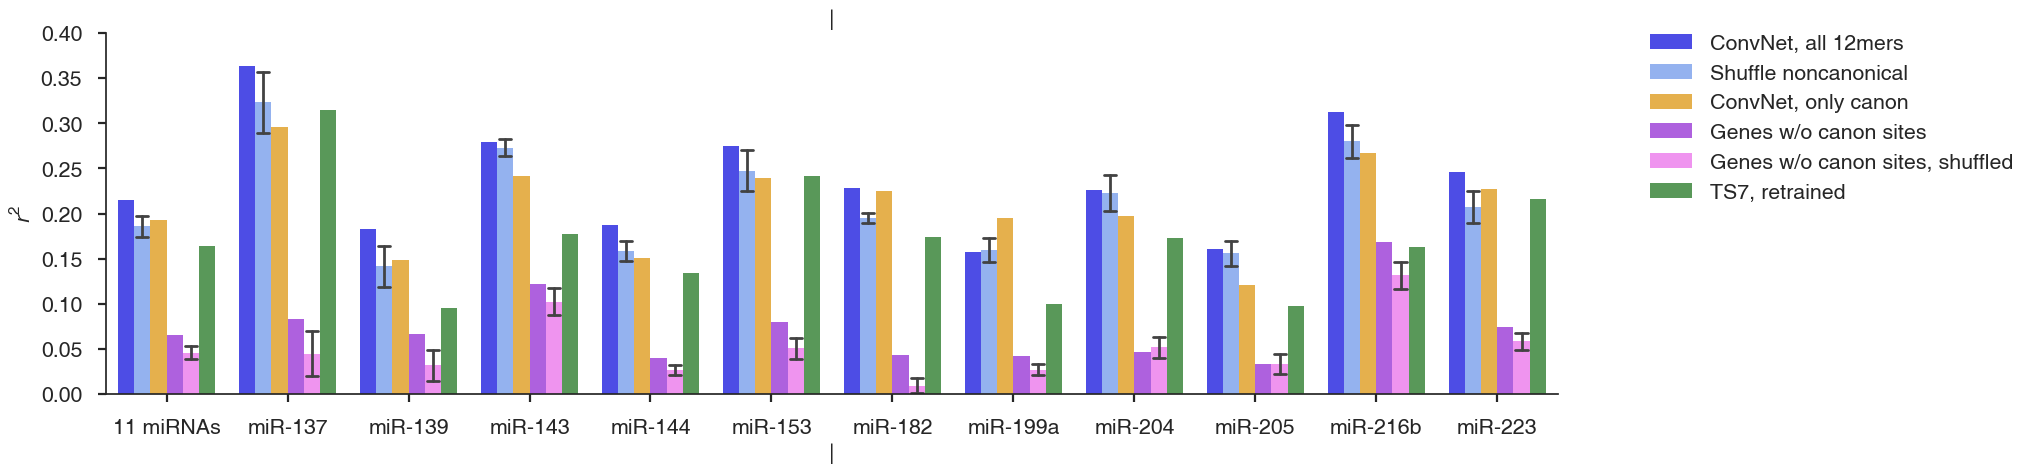

In [34]:
hue_order = ['ConvNet, all 12mers', 'Shuffle noncanonical',
             'ConvNet, only canon', 'Genes w/o canon sites', 'Genes w/o canon sites, shuffled', 'TS7, retrained']

order = ['11 miRNAs'] + [m.replace('mir','miR-') for m in TEST_MIRS]

set_rcparams()
fig = plt.figure(figsize=(16,5))
palette = [(0,0,1), (102/255, 153/255, 1),
           (255/255,165/255,0), (160/255,32/255,240/255), (1, 102/255, 1), (34/255,139/255,34/255)]
ax = sns.barplot(x='mir',y='r2',hue='model', ci='sd', data=r2_df, palette=palette,saturation=0.75,alpha=0.8,
                 hue_order=hue_order, order=order, errwidth=2, capsize=0.1)
# _ = ax.set_xticklabels([m.replace('mir', 'miR-').replace('lsy','lsy-') for m in MIRS5] + ['5 miRNAs'], rotation=0)
_ = ax.set_ylabel(r"$r^2$")
_ = ax.set_xlabel('|')
_ = ax.set_title('|')
_ = ax.set_ylim(0,0.4)


l = ax.legend(bbox_to_anchor=(1.05, 1.05))
# ax.legend(bbox_to_anchor=(1.1, 1.05))
# l.set_visible(False)

sns.despine()
plt.tight_layout()
plt.savefig('/lab/bartel4_ata/kathyl/RNA_Seq/analysis/figures/post_sub/r2_convnet_ts7_biochem_baseline.png', dpi=300)

Using CNN predicted affinites
Targetscan7, retrained


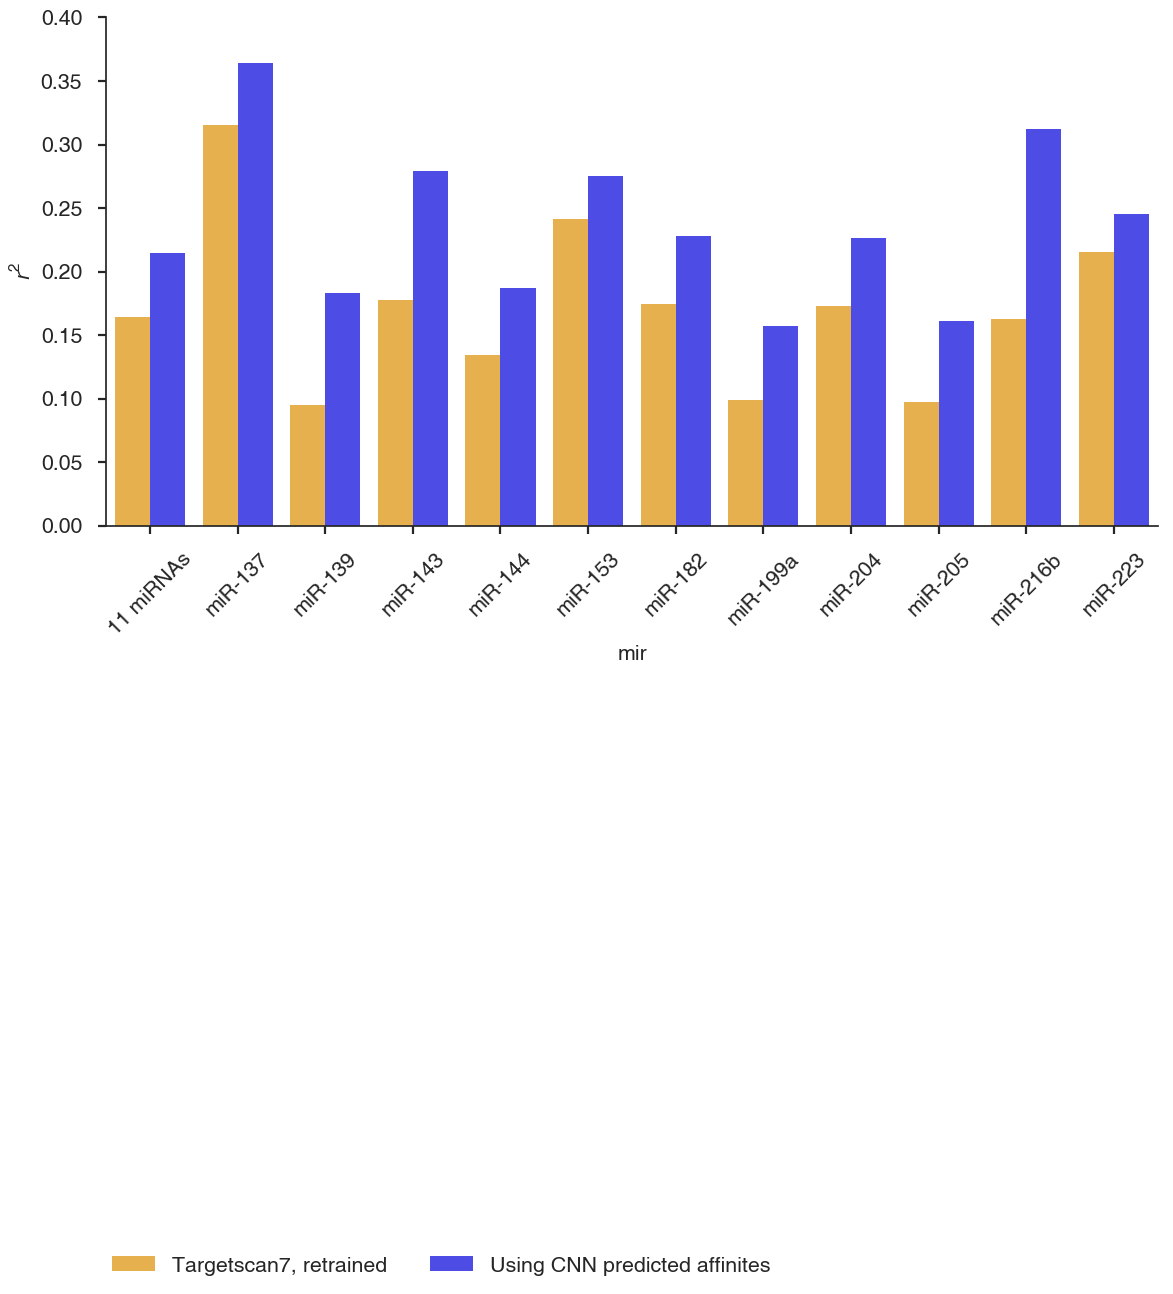

In [25]:
r2_df = []

# add preds from dfs that refit baseline
names = ['Using CNN predicted affinites', 'Targetscan7, retrained']
dfs = [all_kds[0], ts7_11mirs]
for name, df in zip(names, dfs):
    print(name)
    temp = df[df['mir'].isin(TEST_MIRS)]
    r2 = stats.linregress(temp['pred'], temp['log2fc_bayes'])[2]**2
    r2_df.append(['11 miRNAs', name, r2])
    for mir in TEST_MIRS:
        temp = df[df['mir'] == mir]
        r2 = stats.linregress(temp['pred'], temp['log2fc_bayes'])[2]**2
        r2_df.append([mir.replace('mir','miR-'), name, r2])
        
r2_df = pd.DataFrame(r2_df)
r2_df.columns = ['mir','model','r2']

hue_order = ['Targetscan7, retrained', 'Using CNN predicted affinites']

order = ['11 miRNAs'] + [m.replace('mir','miR-') for m in TEST_MIRS]

set_rcparams()
fig = plt.figure(figsize=(12,7))
palette = [(255/255,165/255,0), (0,0,1), (102/255, 153/255, 1),
           (255/255,165/255,0), (160/255,32/255,240/255), (1, 102/255, 1), (34/255,139/255,34/255)]
ax = sns.barplot(x='mir',y='r2',hue='model', ci='sd', data=r2_df, palette=palette,saturation=0.75,alpha=0.8,
                 hue_order=hue_order, order=order, errwidth=2, capsize=0.1)
_ = ax.set_xticklabels(order, rotation=45)
_ = ax.set_ylabel(r"$r^2$")

_ = ax.set_ylim(0,0.4)


l = ax.legend(bbox_to_anchor=(0.65, -1.4), ncol=2)

sns.despine()
plt.tight_layout()
plt.savefig('/lab/bartel4_ata/kathyl/RNA_Seq/analysis/cnn_bar_for_talk.png', dpi=300)

In [114]:
kd_pred_test_mirs = pd.read_csv('/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/no_baseline_analysis/pred_kds_all_mirs.txt',
                        sep='\t')
kd_pred_test_mirs.head()

12mer    log_kd    mir    stype
0  CGCAGTAATGTG  1.881517  mir1*  no site
1  GAAAGTGTCAAG  1.231983  mir1*  no site
2  TTACGTATCTAT -0.606079  mir1*  no site
3  ACCCGTATCGCG  2.290746  mir1*  no site
4  TCAAGTTTATCG  0.187841  mir1*  no site

In [120]:
temp = kd_pred_test_mirs[kd_pred_test_mirs['mir'] == 'mir216b']
temp = temp[temp['stype'] == 'no site']
print(config.SITE_DICT['mir216b'])
temp.sort_values('log_kd').head(20)

AGAGATTA


12mer    log_kd      mir    stype
7865986  AAAGTGATTAAA -2.577014  mir216b  no site
8061472  AAAGTGATTATA -2.563869  mir216b  no site
8048809  ATAGTGATTAAA -2.523647  mir216b  no site
8013219  AAAGTGATTATT -2.509592  mir216b  no site
8008312  AAAGGGATTAAA -2.503195  mir216b  no site
8003350  TAAGTGATTAAA -2.500867  mir216b  no site
7900327  ATAGTGATTATA -2.497060  mir216b  no site
7999009  AAAGGGATTATA -2.494346  mir216b  no site
7867831  AAAGAAATTAAA -2.492774  mir216b  no site
7940267  AAAGTGATTAAT -2.490492  mir216b  no site
8022484  CAAGTGATTAAA -2.487315  mir216b  no site
7966901  AAAGAAATTATA -2.485078  mir216b  no site
7926037  AAAGGGATTATT -2.481035  mir216b  no site
7968403  ATAGGGATTAAA -2.471509  mir216b  no site
7960950  AAAGAAATTATT -2.470992  mir216b  no site
8046107  AAAGTGATTAGA -2.467024  mir216b  no site
7959619  AAAGGGATTAAT -2.466014  mir216b  no site
8041601  TAAGTGATTATA -2.452909  mir216b  no site
8072649  ATAGTGATTAAT -2.446716  mir216b  no site
7922765  AAAGTGATTACA -2.446077  mir216b  no site

In [122]:
name_dict = {
    '8mer': 'n8mer',
    '7mer-m8': 'n7m8',
    '7mer-a1': 'n7a1',
    '6mer': 'n6mer',
    '6mer-m8': 'n6m8',
    '6mer-a1': 'n6a1',
            }

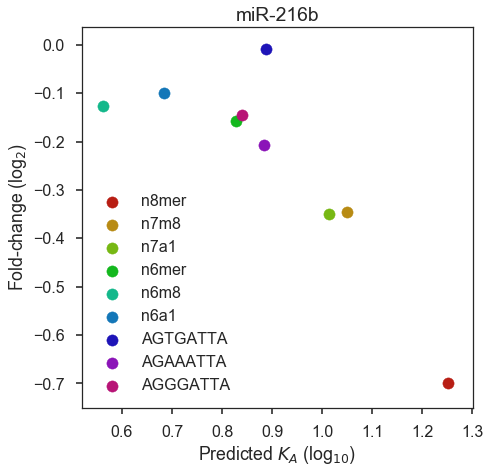

In [126]:
fig = plt.figure(figsize=(7,7))
mir = 'mir216b'

site8 = config.SITE_DICT[mir]
temp = kd_pred_test_mirs[kd_pred_test_mirs['mir'] == mir]
temp['8mer'] = [x[2:-2] for x in temp['12mer']]
#     best_NCs = ['AGTGATTA','AGGGATTA']
best_NCs = list(temp[temp['stype'] == 'no site'].groupby('8mer').agg(np.mean).sort_values('log_kd').iloc[:3].index)

subdf1 = temp[temp['stype'] != 'no site']
subdf1['stype'] = [name_dict[x] for x in subdf1['stype']]
subdf = [subdf1]
subdf2 = temp[temp['8mer'].isin(best_NCs)]
for ix, NC in enumerate(best_NCs):
    subdf2 = temp[temp['8mer'] == NC]
    subdf2['stype'] = NC
    subdf.append(subdf2)
subdf = pd.concat(subdf)

names = np.array(['n8mer','n7m8','n7a1','n6mer','n6m8','n6a1'] + best_NCs)
order = np.argsort(subdf.groupby('stype').agg(np.mean).loc[names]['log_kd'].values)
seqs = np.array([site8, site8[:-1], site8[1:], site8[1:-1], site8[:-2], site8[2:]] + best_NCs)[order]

pred_df = []
for utr in list(MERGED['sequence']):
    all_locs = []
    row = []
    for seq in seqs:
        locs = [m.start() for m in re.finditer(seq, utr)]
        if len(locs) == 0:
            row.append(0)
            continue
        if len(all_locs) == 0:
            all_locs = locs
            row.append(len(locs))
            continue
        keep_locs = []
        for l in locs:
            min_dist = np.min([abs(l - al) for al in all_locs])
            if min_dist > 7:
                keep_locs.append(l)
        row.append(len(keep_locs))
        all_locs += keep_locs
    pred_df.append(row)

pred_df = pd.DataFrame(pred_df)
pred_df.columns = names[order]
pred_df['log2fc'] = (MERGED[mir] - MERGED['nosite3']).values / np.log(2)
formula = 'log2fc ~ {} -1'.format(' + '.join(names))
mod = smf.ols(formula=formula, data=pred_df).fit()

ax = plt.subplot(1,1,1)
xs = subdf.groupby('stype').agg(np.mean).loc[names]['log_kd'].values
ys = [mod.params[x] for x in names]
#     plt.scatter(xs, ys)
ix = 0
for x, y, stype in zip(xs, ys, names):
    plt.scatter([-1 * x/np.log(10)], [y / np.log(2)], color=sns.hls_palette(9, l=.4, s=.8)[ix], label=stype)
#     else:
#         plt.scatter([-1 * x/np.log(10)], [y / np.log(2)], color='grey', label=stype)
    ix += 1
#     plt.legend()
plt.xlabel(r'Predicted $K_A$ (log$_{10}$)')
plt.ylabel(r'Fold-change (log$_{2}$)')
plt.title(mir.replace('mir','miR-'))
plt.legend()


In [25]:
blah.sort_values('log2fc_bayes')

log2_bayes_intercept   log2_tpm  log2fc_bayes  log2fc_method3  \
NM_001430                 5.943117   4.038686     -1.904430       -1.299628   
NM_005909                 8.897978   7.050445     -1.847533             NaN   
NM_003930                 5.343909   3.597994     -1.745916             NaN   
NM_016248                 7.357357   5.639720     -1.717637             NaN   
NM_016626                 6.383581   4.854968     -1.528613       -0.859093   
NM_005730                 8.778271   7.250121     -1.528149        0.000000   
NM_002332                 5.404484   3.885229     -1.519255       -1.417812   
NM_153267                 6.192400   4.708327     -1.484074       -1.291997   
NM_001497                 9.972282   8.492929     -1.479353       -0.699534   
NM_000966                 7.140844   5.704022     -1.436821       -1.062638   
NM_000297                 6.135520   4.787106     -1.348414       -0.677624   
NM_001901                 6.034172   4.787466     -1.246706       -1.001995   
NM_018084                 7.678936   6.437661     -1.241275             NaN   
NM_002966                 9.738409   8.532195     -1.206213       -1.193003   
NM_003489                 6.999173   5.795157     -1.204016             NaN   
NM_012470                 7.935202   6.732665     -1.202537       -0.982434   
NM_033668                11.372623  10.172565     -1.200058       -0.143912   
NM_006135                 9.639312   8.549219     -1.090093       -0.631670   
NM_018590                 6.087376   5.003735     -1.083641       -1.283875   
NM_004869                 7.067835   5.985755     -1.082080       -0.595602   
NM_014918                 6.656767   5.600443     -1.056324       -0.725043   
NM_012224                 5.786934   4.739294     -1.047640       -0.423630   
NM_198827                 4.631893   3.589982     -1.041910       -0.504618   
NM_001014835              5.752301   4.722520     -1.029780       -0.859061   
NM_001142596              8.008949   7.006347     -1.002602       -0.370949   
NM_001079812              8.833835   7.836185     -0.997650       -1.022764   
NM_006826                11.234092  10.237589     -0.996503        0.011369   
NM_000127                 6.768230   5.773371     -0.994859       -0.806941   
NM_007347                 5.201022   4.238940     -0.962082             NaN   
NM_003800                 7.153269   6.198611     -0.954658       -0.253553   
...                            ...        ...           ...             ...   
NM_000904                 7.820869   8.104763      0.283894        0.243079   
NM_001085372              6.667725   6.952883      0.285158        0.328132   
NM_001135167              7.932184   8.218551      0.286367        0.265032   
NM_201398                 7.161842   7.449221      0.287379        0.271115   
NM_004120                 5.997671   6.295168      0.297497        0.236116   
NM_001122                 4.685759   4.985082      0.299323        0.164645   
NM_020834                 5.133325   5.434954      0.301629        0.271323   
NM_004126                 9.096143   9.399503      0.303360        0.264272   
NM_138385                 4.889780   5.193264      0.303484        0.213379   
NM_024056                 8.711794   9.015612      0.303818        0.236235   
NM_032890                 5.611061   5.926916      0.315855        0.299712   
NM_005654                 7.039808   7.356118      0.316310        0.441448   
NM_001143853              6.228223   6.546087      0.317864        0.247630   
NM_080841                 6.367261   6.691185      0.323924        0.094543   
NM_001099645              7.735502   8.060735      0.325233        0.290173   
NM_018056                 4.954751   5.302629      0.347878        0.323033   
NM_001012727              6.821706   7.170206      0.348499        0.246663   
NM_022772                 3.810458   4.160188      0.349730        0.257505   
NM_001077399              6.960191   7.314715      0.354523     

In [71]:
def has_canon(seq, site8):
    return ((site8[:-2] in seq) or (site8[1:-1] in seq) or (site8[2:] in seq))

def get_shuffled_data(pred_dict, pred_dict_next, site8, site8_next):
    kds = -1 * np.array(pred_dict['KDs'])
    seqs = pred_dict['seqs']
    num_seqs = pred_dict['num_seqs']
    
    kds_next = -1 * np.array(pred_dict_next['KDs'])
    seqs_next = pred_dict_next['seqs']
    num_seqs_next = pred_dict_next['num_seqs']
    
    current_ix1, current_ix2 = 0,0
    new_kds, new_num_seqs = [], []
    for ns1,ns2 in zip(num_seqs, num_seqs_next):
        temp_kds1 = kds[current_ix1: current_ix1 + ns1]
        temp_seqs1 = seqs[current_ix1: current_ix1 + ns1]
        
        temp_kds2 = kds_next[current_ix2: current_ix2 + ns2]
        temp_seqs2 = seqs_next[current_ix2: current_ix2 + ns2]
        
        new_canon = [k for (k,s) in zip(temp_kds1, temp_seqs1) if has_canon(s,site8)]
        new_noncanon = [k for (k,s) in zip(temp_kds2, temp_seqs2) if not (has_canon(s,site8) or has_canon(s, site8_next))]
        new_kds += new_canon + new_noncanon
        new_num_seqs.append(len(new_canon) + len(new_noncanon))
        
        current_ix1 += ns1
        current_ix2 += ns2
    return new_kds, new_num_seqs
        
kds_test = [1,12,5,6,2,4,24,2]
#               N        Y           Y         N        N       Y        Y         Y
seqs_test = ['GOIACN','ACATTCCA','ACATTCC','ACATCCA','ACATTA','ACATTC','ATTCCA','CATTCCA']
pred_dict = {'KDs': kds_test,'seqs': seqs_test,'num_seqs':[2,3,3]}
kds_test = [3,5,3,2,1,35,6,64,13]
#               Y          Y        N         Y        N        Y        N        N/Y             Y
seqs_test = ['AGCATTAA','AGCATTA','AGCATAA','CATTAA','AGTTAA','AGCATT','AGCAA','CATTCCA','AGCATTAAAA']
pred_dict_next = {'KDs': kds_test,'seqs': seqs_test,'num_seqs':[1,4,4]}

print(config.SITE_DICT['mir1'], config.SITE_DICT['mir155'])

get_shuffled_data(pred_dict, pred_dict_next, config.SITE_DICT['mir1'], config.SITE_DICT['mir155'])
# should be:
# [-12, -5, -3, -1, -4, -24, -2, -6], [1, 3, 4]

ACATTCCA AGCATTAA


([-12, -5, -3, -1, -4, -24, -2, -6], [1, 3, 4])

In [54]:
mir = 'mir137'
PREDICT_DIR = '/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/final/predictions_simple_xval_4_16_16_with_seqs/'
NEW_PREDICT_DIR = '/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/final/predictions_simple_xval_4_16_16_test_only_canon/'
NEW_LOG_DIR = '/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/no_baseline_analysis/model_preds_shuffled_noncanon_retrain/'

with open(os.path.join(PREDICT_DIR, '{}.pickle'.format(mir)), 'rb') as infile:
    info = pickle.load(infile)
    
kd_dict = info[mir]
# kd_dict['KDs'] = kd_dict['KAs']
next_dict = {'KDs': [], 'seqs': [], 'num_seqs':[0 for _ in range(len(MERGED))]}
    
kds_guide, num_seqs_guide = get_shuffled_data(info[mir], next_dict, config.SITE_DICT[mir], config.SITE_DICT[mir])

with open(os.path.join(NEW_PREDICT_DIR, '{}.pickle'.format(mir)), 'rb') as infile:
    info = pickle.load(infile)

print(len(kds_guide), len(info[mir]['KDs']))

2877 2933


In [15]:
### Refit last layer using shuffled KDs

In [ ]:
PREDICT_DIR = '/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/final/predictions_simple_xval_4_16_16_with_seqs/'
NEW_PREDICT_DIR = '/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/final/predictions_simple_xval_4_16_16_shuffled_noncanon/'
NEW_LOG_DIR = '/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/no_baseline_analysis/model_preds_shuffled_noncanon_retrain/'

if not os.path.isdir(NEW_PREDICT_DIR):
    os.makedirs(NEW_PREDICT_DIR)

num_mirs = len(ALL_MIRS)
num_genes = len(MERGED)
num_kds_guide = 355
num_kds_pass = 416
input_utr_len = MERGED[['utr_length']].values

for test_ix, test_mir in enumerate(ALL_MIRS):
    site8 = config.SITE_DICT[test_mir]
    next_mir = ALL_MIRS[(test_ix+1)%num_mirs]
    site8_next = config.SITE_DICT[next_mir]
    other_mirs = [m for m in ALL_MIRS if m != test_mir]
    print(test_mir, other_mirs)
    
    output_dict = {}
    x_guide, mask_guide = np.zeros([num_genes, num_mirs-1, num_kds_guide]), np.zeros([num_genes, num_mirs-1, num_kds_guide])
    x_pass, mask_pass = np.zeros([num_genes, num_mirs-1, num_kds_pass]), np.zeros([num_genes, num_mirs-1, num_kds_pass])
    y_vals = MERGED[other_mirs].values

    with open(os.path.join(PREDICT_DIR, '{}.pickle'.format(test_mir)), 'rb') as infile:
        info = pickle.load(infile)
    
    with open(os.path.join(PREDICT_DIR, '{}.pickle'.format(next_mir)), 'rb') as infile:
        info_next = pickle.load(infile)
        
    kds_guide, num_seqs_guide = get_shuffled_data(info[test_mir], info_next[next_mir], site8, site8_next)
    kds_pass, num_seqs_pass = get_shuffled_data(info[test_mir+"*"], info_next[next_mir+"*"], site8, site8_next)
    output_dict[test_mir] = {'KDs': [-1*x for x in kds_guide], 'num_seqs': num_seqs_guide}
    output_dict[test_mir+'*'] = {'KDs': [-1*x for x in kds_pass], 'num_seqs': num_seqs_pass}
        
    for this_mir_ix, this_mir in enumerate(other_mirs):
        site8 = config.SITE_DICT[this_mir]
        next_mir = other_mirs[(this_mir_ix+1)%(num_mirs-1)]
        site8_next = config.SITE_DICT[next_mir]
        
        kds_guide, num_seqs_guide = get_shuffled_data(info[this_mir], info[next_mir], site8, site8_next)
        kds_pass, num_seqs_pass = get_shuffled_data(info[this_mir+"*"], info[next_mir+"*"], site8, site8_next)
        
        current_ix = 0
        for ix, num_seq in enumerate(num_seqs_guide):
            x_guide[ix, this_mir_ix, :num_seq] = kds_guide[current_ix: current_ix + num_seq]
            mask_guide[ix, this_mir_ix, :num_seq] = 1
            current_ix += num_seq
            
        current_ix = 0
        for ix, num_seq in enumerate(num_seqs_pass):
            x_pass[ix, this_mir_ix, :num_seq] = kds_pass[current_ix: current_ix + num_seq]
            mask_pass[ix, this_mir_ix, :num_seq] = 1
            current_ix += num_seq
        
        output_dict[this_mir] = {'KDs': [-1*x for x in kds_guide], 'num_seqs': num_seqs_guide}
        output_dict[this_mir+'*'] = {'KDs': [-1*x for x in kds_pass], 'num_seqs': num_seqs_pass}
        
    with open(os.path.join(NEW_PREDICT_DIR, '{}.pickle'.format(test_mir)), 'wb') as outfile:
        pickle.dump(output_dict, outfile)
            
    params = refit_last_layer(x_guide, x_pass,
                              mask_guide, mask_pass,
                              y_vals, input_utr_len, num_genes, num_mirs-1, maxiter=200)
    freeAGO_df = pd.DataFrame({'mir': other_mirs,
                               'guide': params[2].flatten(),
                               'passenger': params[3].flatten()})

    log_dir_mir = os.path.join(NEW_LOG_DIR, test_mir)
    if not os.path.isdir(log_dir_mir):
        os.makedirs(log_dir_mir)
    freeAGO_df.to_csv(os.path.join(log_dir_mir, 'freeAGO_final.txt'), sep='\t', index=False)
    with open(os.path.join(log_dir_mir, 'fitted_params.txt'), 'w') as outfile:
        outfile.write('decay\t{}\n'.format(np.log(params[1])))
        outfile.write('utr_coef\t{}\n'.format(params[0]))
        print(params[0], params[1])
    

mir1 ['mir124', 'mir155', 'mir7', 'lsy6', 'mir137', 'mir139', 'mir143', 'mir144', 'mir153', 'mir182', 'mir199a', 'mir204', 'mir205', 'mir216b', 'mir223']
-8.71613 1.66695
mir124 ['mir1', 'mir155', 'mir7', 'lsy6', 'mir137', 'mir139', 'mir143', 'mir144', 'mir153', 'mir182', 'mir199a', 'mir204', 'mir205', 'mir216b', 'mir223']
-8.31569 1.16385
mir155 ['mir1', 'mir124', 'mir7', 'lsy6', 'mir137', 'mir139', 'mir143', 'mir144', 'mir153', 'mir182', 'mir199a', 'mir204', 'mir205', 'mir216b', 'mir223']
-9.08388 2.46856
mir7 ['mir1', 'mir124', 'mir155', 'lsy6', 'mir137', 'mir139', 'mir143', 'mir144', 'mir153', 'mir182', 'mir199a', 'mir204', 'mir205', 'mir216b', 'mir223']
-8.91495 2.02239
lsy6 ['mir1', 'mir124', 'mir155', 'mir7', 'mir137', 'mir139', 'mir143', 'mir144', 'mir153', 'mir182', 'mir199a', 'mir204', 'mir205', 'mir216b', 'mir223']
-8.68871 1.60023
mir137 ['mir1', 'mir124', 'mir155', 'mir7', 'lsy6', 'mir139', 'mir143', 'mir144', 'mir153', 'mir182', 'mir199a', 'mir204', 'mir205', 'mir216b', '

In [46]:
results_dict = {}
for offset in range(16):

    PREDICT_DIR = '/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/final/predictions_simple_xval_4_16_16_shuffled_noncanon_{}/'.format(offset)
    # LOG_DIR = '/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_4_16_16/'
    # LOG_DIR = '/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_only_canon_4_16_16/'
    LOG_DIR = '/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/no_baseline_analysis/model_preds_shuffled_noncanon_retrain_{}/'.format(offset)
    shuffled_noncanon = get_pred_df(LOG_DIR, PREDICT_DIR, MERGED, TEST_MIRS, ALL_MIRS, all_kds[-1])
    results_dict[offset] = shuffled_noncanon

NameError: name 'get_pred_df' is not defined

In [33]:
all_shuffled_r2s = [stats.linregress(results_dict[ix+1][1].flatten(), results_dict[ix+1][2].flatten())[2]**2 for ix in range(15)]

In [29]:
# for mir in TEST_MIRS:
#     with open(os.path.join(PREDICT_DIR, '{}.pickle'.format(mir)), 'rb') as infile:
#         kds = pickle.load(infile)
# #         print(np.max(kds[mir]['num_seqs']))
#         print(np.max(kds[mir + '*']['num_seqs']))

In [15]:
# r2_dict_canon_test = {}
# for ix, mir in enumerate(TEST_MIRS):
#     x = only_canon_test_preds[:,ix]
#     y = only_canon_test_actuals[:,ix]
#     r2 = stats.linregress(x,y)[2]**2
#     R2 = calc_rsquared(x,y)
#     r2_dict_canon_test[mir] = (R2, r2)
# r2_dict_canon_test

In [18]:
# sns.set_style('ticks')
# sns.set_context('poster')
# PREDICT_DIR = '/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/final/predictions_simple_xval_only_canon_4_16_16/'
# LOG_DIR = '/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_only_canon_4_16_16/'
# OUTFILE = '/lab/bartel4_ata/kathyl/RNA_Seq/analysis/figures/new_analysis/nn_canon_kds.png'
# only_canon = plot_results(LOG_DIR, PREDICT_DIR, MERGED, TEST_MIRS, OUTFILE, None)

In [79]:
median_dict = {'mir137': (-0.69790383622407237, 0.038205190657763843),
 'mir139': (-0.30469518496950521, -0.23614743816066763),
 'mir143': (-0.34528924534406746, -0.18993435639270428),
 'mir144': (-0.21436544945994607, -0.17743260644808956),
 'mir153': (-0.48708981116136751, -0.1738359297547647),
 'mir182': (-0.29546131284089316, -0.21855090537021393),
 'mir199a': (-0.27853473605962176, -0.24820467425620496),
 'mir204': (-0.33303456720036673, -0.15030390378876923),
 'mir205': (-0.30696562716824793, -0.1370740000193944),
 'mir216b': (-0.4058235436416946, -0.27242295430704733),
 'mir223': (-0.47897694683171643, -0.16945673288836405)}

freeAgo_guide, freeAgo_pass = all_kds[2], all_kds[3]

In [80]:
config.SITE_DICT['let7']

'CTACCTCA'

In [81]:
# def calc_TA(merged, mir):
#     site = config.SITE_DICT[mir]
#     counts = 0
#     for row in merged.iterrows():
#         utr = row[1]['sequence']
#         nsites = utr.count(site[1:-1])# + utr.count(site[1:]+ 'A') - utr.count(site + 'A')
#         counts += (np.exp(row[1][mir]) * nsites)
        
#     return np.log(counts)

def calc_TA(merged, mir):
    site = config.SITE_DICT[mir]
    counts = 0
    for row in merged.iterrows():
        utr = row[1]['sequence']
        nsites = utr.count(site[1:]) + utr.count(site[:-1]) - utr.count(site)
        counts += (np.exp(row[1][mir]) * nsites)
        
    return counts / 10000

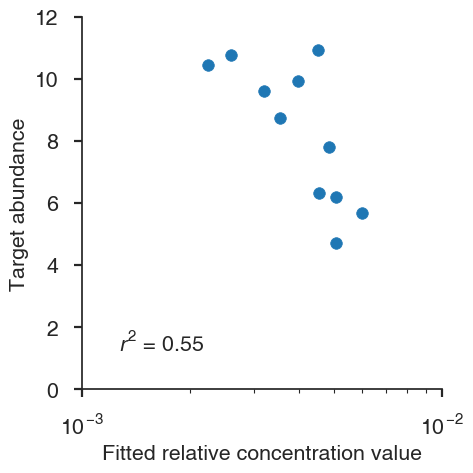

In [88]:
freeAgo_guide = all_kds[2]
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(1,1,1)
ys = [calc_TA(MERGED, mir) for mir in TEST_MIRS]

# log x-scale
xs = freeAgo_guide.loc[TEST_MIRS]['mean'].values
ax.set_xscale("log")
ax.set_ylim(0,12)
ax.set_xlim(0.001, 0.01)
ax.set_xticklabels([], visible=False, minor=True)
ax.scatter(np.exp(xs), ys, s=70)

# # linear x-scale
# xs = [freeAgo_guide.loc[m]['mean'] / np.log(10) for m in TEST_MIRS]
# ax.set_ylim(4,12)
# ax.set_xlim(-2.7, -2.2)
# ax.scatter(xs, ys, s=70)

ax.text(0.1,0.1,r"$r^2$ = {:.2g}".format(stats.linregress(xs, ys)[2]**2),
            transform=ax.transAxes)
ax.set_xlabel(r'Fitted relative concentration value')
ax.set_ylabel('Target abundance')


sns.despine()
plt.tight_layout()
fig.savefig('/lab/bartel4_ata/kathyl/RNA_Seq/analysis/figures/post_sub/TA.png', dpi=300)

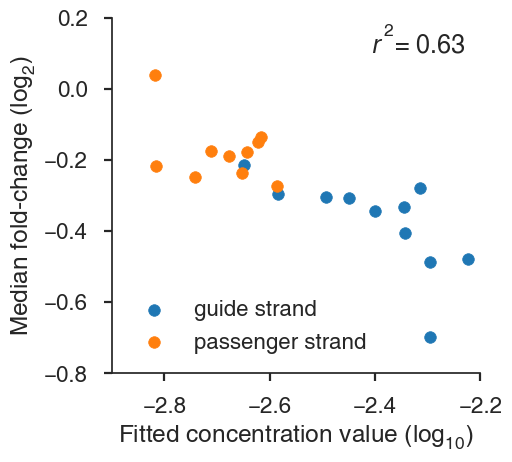

In [43]:
all_xs, all_ys = [], []
fig = plt.figure(figsize=(5.5,5))
ax = plt.subplot(1,1,1)
ys = [median_dict[m][0] for m in TEST_MIRS]
xs = [freeAgo_guide.loc[m]['mean'] / np.log(10) for m in TEST_MIRS]
all_xs += xs
all_ys += ys
ax.scatter(xs, ys, label='guide strand',s=70)
ys = [median_dict[m][1] for m in TEST_MIRS]
xs = [freeAgo_pass.loc[m]['mean'] / np.log(10) for m in TEST_MIRS]
all_xs += xs
all_ys += ys
ax.scatter(xs, ys, label='passenger strand',s=70)
ax.text(0.7,0.9,r"$r^{\hspace{0.3} 2}$= " + "{:.2g}".format(stats.linregress(all_xs, all_ys)[2]**2),
            fontsize=18, transform=ax.transAxes)
ax.legend(loc='lower left')
ax.set_xlim(-2.9,-2.2)
ax.set_ylim(-0.8,0.2)
ax.set_xlabel(r'Fitted concentration value (log$_{10}$)')
ax.set_ylabel(r'Median fold-change (log$_2$)')
sns.despine()
plt.tight_layout()
fig.savefig('/lab/bartel4_ata/kathyl/RNA_Seq/analysis/figures/post_sub/freeago_concs.png', dpi=300)

In [82]:
log_dir = '/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_4_16_16/'
decays, utrcoefs = [], []
for mir in TEST_MIRS:
    paramfile = pd.read_csv('{}/{}/fitted_params.txt'.format(log_dir, mir), sep='\t', index_col=0, header=None)
    decays.append(np.exp(paramfile.loc['decay'][1]))
    utrcoefs.append(np.exp(paramfile.loc['utr_coef'][1]))


In [98]:
utrcoefs

[0.00023105446550883237,
 0.00021243229222856535,
 0.0002029133893847092,
 0.0002075655346714044,
 0.00021697921343507811,
 0.00021088187453068772,
 0.00019375744488212232,
 0.00021015770752946588,
 0.00021582206745819854,
 0.00020651018440295037,
 0.00020180700499240588]

In [86]:
print(np.mean(decays), np.max(decays) - np.mean(decays))
print(np.mean(utrcoefs)*1e4, (np.max(utrcoefs) - np.mean(utrcoefs))*1e4)

1.01186030712 0.034415094291
2.09989198093 0.210652674157


In [19]:
for results in [all_kds, only_canon_test]:
    xs, ys = np.array(results[1].flatten()), np.array(results[2].flatten())
    print(stats.linregress(xs, ys)[2]**2)
    print(calc_rsquared(-1 * xs, ys))

0.254720499497
0.25192269212
0.255181818926
0.193855301698


In [44]:
ts7_results = {'lsy6': (0.17336001236672349, 0.24057342023469705),
 'mir1': (0.19792705334777949, 0.28305774077676921),
 'mir124': (-0.15382129721514914, 0.26197222847854063),
 'mir137': (0.28629981328588039, 0.31357377715503432),
 'mir139': (-0.44147900051702615, 0.093987905886930304),
 'mir143': (-0.01434761855159894, 0.17432853139901694),
 'mir144': (-0.62031430469713311, 0.13144862684183542),
 'mir153': (0.10472906719816744, 0.23979440150244527),
 'mir155': (0.16604540879404095, 0.28162690606746232),
 'mir182': (-0.20404583441342905, 0.17039749204149368),
 'mir199a': (-0.20630683866152166, 0.095335360717295786),
 'mir204': (-0.0184435690568161, 0.17381139212303445),
 'mir205': (-0.2309353961483418, 0.09753239352073817),
 'mir216b': (-0.12922591802815653, 0.16405212514461448),
 'mir223': (0.052704050081177845, 0.21083879431301114),
 'mir7': (0.14080245319519258, 0.21405173786312229)}

In [45]:
R2_df = []
r2_df = []

for mir in TEST_MIRS:
    R2_df.append([mir.replace('mir','miR-'), 'TS7, retrained', ts7_results[mir][1]])
R2_df.append(['all miRNAs','TS7, retrained',0.1609])
# R2_df.append(['all miRNAs','TS7, retrained',-0.08133,0.1609])
    
names = ['ConvNet, only canon sites', 'ConvNet, all 12mers']
for ix, data in enumerate([only_canon_test, all_kds]):
    xs, ys = -1*np.array(data[0]['pred'].values), np.array(data[0]['log2fc_bayes'].values)
#     R2 = calc_rsquared(xs, ys)
    r2 = stats.linregress(xs, ys)[2]**2
    R2_df.append(['all miRNAs',names[ix],r2])
    for mir in TEST_MIRS:
        R2_df.append([mir.replace('mir','miR-'), names[ix], data[1][mir]])

for offset in range(15):
    results_temp = results_dict[offset+1]
    xs, ys = -1*np.array(results_temp[0]['pred'].values), np.array(results_temp[0]['log2fc_bayes'].values)
#     R2 = calc_rsquared(xs, ys)
    r2 = stats.linregress(xs, ys)[2]**2
    R2_df.append(['all miRNAs','ConvNet, shuffled noncanon', r2])
    for mir in TEST_MIRS:
        R2_df.append([mir.replace('mir','miR-'), 'ConvNet, shuffled noncanon', results_temp[1][mir]])

R2_df = pd.DataFrame(R2_df)
R2_df.columns = ['mir','model','r2']
R2_df.head()


NameError: name 'results_dict' is not defined

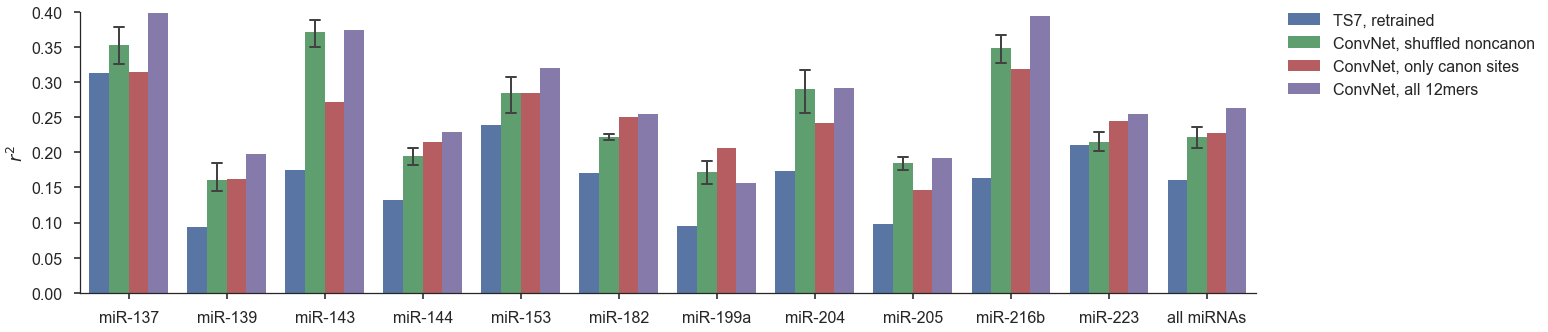

In [87]:
fig = plt.figure(figsize=(18,5))
order = ['TS7, retrained', 'ConvNet, shuffled noncanon', 'ConvNet, only canon sites', 'ConvNet, all 12mers']
# order = TEST_MIRS + ['all miRNAs']
ax = sns.barplot(x='mir',y='r2',hue='model', data=R2_df, hue_order=order, ci=100, errwidth=2, capsize=0.1)
# _ = ax.set_xticklabels([m.replace('mir', 'miR-') for m in TEST_MIRS] + ['11 miRNAs'], rotation=0)
_ = ax.set_ylabel(r'$r^2$')
_ = ax.set_xlabel('')
_ = ax.set_ylim(0,0.4)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=20)

l = ax.legend(bbox_to_anchor=(1.25, 1.05))
# l.set_visible(False)

sns.despine()
plt.tight_layout()
plt.savefig('/lab/bartel4_ata/kathyl/RNA_Seq/analysis/figures/new_analysis/NN_r2_new_canon.png', dpi=300)

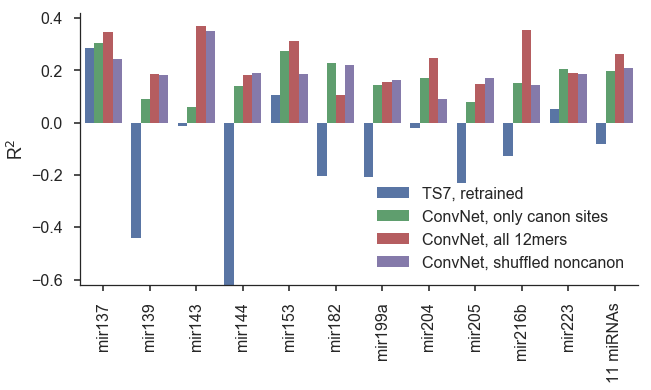

In [36]:
fig = plt.figure(figsize=(10,5))
ax = sns.barplot(x='mir',y='R2',hue='model', data=R2_df)
_ = ax.set_xticklabels(TEST_MIRS + ['11 miRNAs'], rotation=90)
_ = ax.set_ylabel(r'R$^2$')
_ = ax.set_xlabel('')
# _ = ax.set_ylim(0,0.5)

l = ax.legend()
l.set_title('')

sns.despine()
plt.savefig('/lab/bartel4_ata/kathyl/RNA_Seq/analysis/figures/new_analysis/NN_R2_coef_det_new_canon', dpi=300)

In [58]:
# diff = 0
# for utr in MERGED['sequence']:
#     blah1 = sorted(get_features_no_overlap(utr, kds_temp))
#     blah2 = sorted(helpers.get_seqs(utr, site8))
#     if blah1 != blah2:
#         diff += 1
# #         print(set(blah1) - set(blah2))
# #         print(set(blah2) - set(blah1))
# #         print(utr)
# #         break

# diff

In [61]:
KDS = pd.read_csv('/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/final/kds.txt', sep='\t')
# KDS = pd.read_csv('/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/no_baseline_analysis/kds.txt', sep='\t')
# KDS = pd.read_csv('/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/pre_final/kds.txt', sep='\t')
# KDS = KDS.rename(columns={'log kd': 'log_kd'})

data = KDS.copy()
data.columns = ['seq','log_kd','mir','mirseq','stype']
# data.columns = ['mir','mirseq','seq','log_kd','stype']

# zero-center and normalize Ka's
data['keep_prob'] = (1 / (1 + np.exp(data['log_kd'] + 3)))
data['log ka'] = (-1.0 * data['log_kd'])
data.head()

seq    log_kd   mir                  mirseq    stype  keep_prob  \
0  AAAAAATCCAAA -0.810633  mir1  TGGAATGTAAAGAAGTATGTAT  no site   0.100709   
1  AAAAAATCCAAC -1.805606  mir1  TGGAATGTAAAGAAGTATGTAT  no site   0.232474   
2  AAAAAATCCAAG -0.287849  mir1  TGGAATGTAAAGAAGTATGTAT  no site   0.062260   
3  AAAAAATCCAAT -0.206237  mir1  TGGAATGTAAAGAAGTATGTAT  no site   0.057662   
4  AAAAAATCCACA -1.096425  mir1  TGGAATGTAAAGAAGTATGTAT  no site   0.129704   

     log ka  
0  0.810633  
1  1.805606  
2  0.287849  
3  0.206237  
4  1.096425

In [11]:
def get_kd_pred_df(log_dir):
    kd_pred_df = []
    for ix, mir in enumerate(['mir1','mir124','mir155','mir7','lsy6']):
        data_test = data[data['mir'] == mir]

        test_kds_combined_x = np.zeros([len(data_test), 4*config.MIRLEN, 4*config.SEQLEN])
        for i, row in enumerate(data_test.iterrows()):
            mirseq_one_hot = helpers.one_hot_encode(row[1]['mirseq'][:config.MIRLEN][::-1], config.MIR_NT_DICT, config.TARGETS)
            seq_one_hot = helpers.one_hot_encode(row[1]['seq'], config.SEQ_NT_DICT, config.TARGETS)
            test_kds_combined_x[i,:,:] = np.outer(mirseq_one_hot, seq_one_hot)

        test_kds_combined_x = np.expand_dims((test_kds_combined_x*4) - 0.25, 3)   
        test_kds_labels = data_test['log ka'].values

        tf.reset_default_graph()
        with tf.Session() as sess:

            sess.run(tf.global_variables_initializer())
            latest = tf.train.latest_checkpoint('{}/{}/saved'.format(log_dir, mir))
            print(latest)
            saver = tf.train.import_meta_graph(latest + '.meta')
            saver.restore(sess, latest)

            _keep_prob = tf.get_default_graph().get_tensor_by_name('keep_prob:0')
            _phase_train = tf.get_default_graph().get_tensor_by_name('phase_train:0')
            _combined_x = tf.get_default_graph().get_tensor_by_name('biochem_x:0')
            _prediction = tf.get_default_graph().get_tensor_by_name('final_layer/pred_ka:0')

        #     i = 0
        #     for op in tf.get_default_graph().get_operations():
        # #         print(str(op.name))
        #         if 'final_layer' in str(op.name):
        #             print(str(op.name))
        #         i += 1

            feed_dict = {
                            _keep_prob: 1.0,
                            _phase_train: False,
                            _combined_x: test_kds_combined_x
                        }

            pred = sess.run(_prediction, feed_dict=feed_dict)

        data_test['pred'] = pred.flatten()
        kd_pred_df.append(data_test)

    kd_pred_df = pd.concat(kd_pred_df)
    print(len(kd_pred_df))
    return kd_pred_df

In [63]:
kd_pred_df = get_kd_pred_df('/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_4_16_16/')
kd_pred_df.to_csv('/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/no_baseline_analysis/pred_kds.txt',sep='\t',index=False)

/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_4_16_16/mir1/saved/model-100
INFO:tensorflow:Restoring parameters from /lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_4_16_16/mir1/saved/model-100
/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_4_16_16/mir124/saved/model-100
INFO:tensorflow:Restoring parameters from /lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_4_16_16/mir124/saved/model-100
/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_4_16_16/mir155/saved/model-100
INFO:tensorflow:Restoring parameters from /lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_4_16_16/mir155/saved/model-100
/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_4_16_16/mir7/saved/model-100
INFO:tensorflow:Restoring parameters from /lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_4_16_16/mir7/saved/model-100
/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/s

In [66]:
kd_pred_df_canon = get_kd_pred_df('/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_only_canon_4_16_16/')
kd_pred_df_canon.to_csv('/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/no_baseline_analysis/pred_kds_canon.txt',sep='\t',index=False)

/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_only_canon_4_16_16/mir1/saved/model-100
INFO:tensorflow:Restoring parameters from /lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_only_canon_4_16_16/mir1/saved/model-100
/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_only_canon_4_16_16/mir124/saved/model-100
INFO:tensorflow:Restoring parameters from /lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_only_canon_4_16_16/mir124/saved/model-100
/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_only_canon_4_16_16/mir155/saved/model-100
INFO:tensorflow:Restoring parameters from /lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_only_canon_4_16_16/mir155/saved/model-100
/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_only_canon_4_16_16/mir7/saved/model-100
INFO:tensorflow:Restoring parameters from /lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_only_can

In [3]:
import itertools as it
def get_all_kmers(k):
    return ["".join(kmer) for kmer in list(it.product(["A","C","G","T"],repeat=k))]

def get_all_12mers(mir):
    # get 8mer site
    site = config.SITE_DICT[mir]
    all_sites = []
    for i in range(5):
        upstreams = get_all_kmers(2+i)
        mid = site[i:i+4]
        downstreams = get_all_kmers(2+8-4-i)
        for u in upstreams:
            for d in downstreams:
                all_sites.append(u+mid+d)

    return list(set(list(all_sites)))

def get_stype_six_canon(site8, seq):
    if seq[2:-2] == site8:
        return '8mer'
    elif seq[2:-3] == site8[:-1]:
        return '7mer-m8'
    elif seq[3:-2] == site8[1:]:
        return '7mer-a1'
    elif seq[3:-3] == site8[1:-1]:
        return '6mer'
    elif seq[2:-4] == site8[:-2]:
        return '6mer-m8'
    elif seq[4:-2] == site8[2:]:
        return '6mer-a1'
    else:
        return 'no site'
    
# def get_stype_six_canon(site8, seq):
#     if site8 in seq:
#         return '8mer'
#     elif site8[:-1] in seq:
#         return '7mer-m8'
#     elif site8[1:] in seq:
#         return '7mer-a1'
#     elif site8[1:-1] in seq:
#         return '6mer'
#     elif site8[:-2] in seq:
#         return '6mer-m8'
#     elif site8[2:] in seq:
#         return '6mer-a1'
#     else:
#         return 'no site'

In [4]:
def get_kd_pred_df_new_mirs(log_dir, mirs):
    print(len(mirs))
    kd_pred_df = []
    for ix, mir in enumerate(mirs):
        seqs = get_all_12mers(mir)
        mirseq = config.MIRSEQ_DICT_MIRLEN[mir]
        site8 = config.SITE_DICT[mir]

        test_kds_combined_x = np.zeros([len(seqs), 4*config.MIRLEN, 4*config.SEQLEN])
        
        for i, seq in enumerate(seqs):
            mirseq_one_hot = helpers.one_hot_encode(mirseq, config.MIR_NT_DICT, config.TARGETS)
            seq_one_hot = helpers.one_hot_encode(seq, config.SEQ_NT_DICT, config.TARGETS)
            test_kds_combined_x[i,:,:] = np.outer(mirseq_one_hot, seq_one_hot)

        test_kds_combined_x = np.expand_dims((test_kds_combined_x*4) - 0.25, 3)

        tf.reset_default_graph()
        with tf.Session() as sess:

            sess.run(tf.global_variables_initializer())
            latest = tf.train.latest_checkpoint('{}/{}/saved'.format(log_dir, mir.replace('*','')))
            print(latest)
            saver = tf.train.import_meta_graph(latest + '.meta')
            saver.restore(sess, latest)

            _keep_prob = tf.get_default_graph().get_tensor_by_name('keep_prob:0')
            _phase_train = tf.get_default_graph().get_tensor_by_name('phase_train:0')
            _combined_x = tf.get_default_graph().get_tensor_by_name('biochem_x:0')
            _prediction = tf.get_default_graph().get_tensor_by_name('final_layer/pred_ka:0')

        #     i = 0
        #     for op in tf.get_default_graph().get_operations():
        # #         print(str(op.name))
        #         if 'final_layer' in str(op.name):
        #             print(str(op.name))
        #         i += 1

            feed_dict = {
                            _keep_prob: 1.0,
                            _phase_train: False,
                            _combined_x: test_kds_combined_x
                        }

            pred = sess.run(_prediction, feed_dict=feed_dict)

        stypes = [get_stype_six_canon(site8, seq) for seq in seqs]
        data_test = pd.DataFrame({'12mer': seqs, 'stype': stypes, 'mir': mir, 'log_kd': -1 * pred.flatten()})
        kd_pred_df.append(data_test)

    kd_pred_df = pd.concat(kd_pred_df)
    print(len(kd_pred_df))
    return kd_pred_df

In [5]:
all_mirs_let7 = ALL_MIRS + ['let7']
kd_pred_all_mirs = get_kd_pred_df_new_mirs('/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_4_16_16_fix_getseqs2/',
                                            [m+'*' for m in all_mirs_let7] + all_mirs_let7)
kd_pred_all_mirs.to_csv('/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/no_baseline_analysis/pred_kds_all_mirs_fix_getseqs2.txt',
                        sep='\t',index=False)

34
/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_4_16_16_fix_getseqs2/mir1/saved/model-200
INFO:tensorflow:Restoring parameters from /lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_4_16_16_fix_getseqs2/mir1/saved/model-200
/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_4_16_16_fix_getseqs2/mir124/saved/model-200
INFO:tensorflow:Restoring parameters from /lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_4_16_16_fix_getseqs2/mir124/saved/model-200
/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_4_16_16_fix_getseqs2/mir155/saved/model-200
INFO:tensorflow:Restoring parameters from /lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_4_16_16_fix_getseqs2/mir155/saved/model-200
/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_4_16_16_fix_getseqs2/mir7/saved/model-200
INFO:tensorflow:Restoring parameters from /lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/sim

In [14]:
kd_pred_test_mirs = get_kd_pred_df_new_mirs('/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_4_16_16/',
                                            TEST_MIRS)
kd_pred_test_mirs.to_csv('/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/no_baseline_analysis/pred_kds_test_mirs.txt',
                        sep='\t',index=False)


/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_4_16_16/mir137/saved/model-100
INFO:tensorflow:Restoring parameters from /lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_4_16_16/mir137/saved/model-100
/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_4_16_16/mir139/saved/model-100
INFO:tensorflow:Restoring parameters from /lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_4_16_16/mir139/saved/model-100
/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_4_16_16/mir143/saved/model-100
INFO:tensorflow:Restoring parameters from /lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_4_16_16/mir143/saved/model-100
/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_4_16_16/mir144/saved/model-100
INFO:tensorflow:Restoring parameters from /lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_4_16_16/mir144/saved/model-100
/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_a

In [57]:
import re
def stype_linear_model(merged, mir, seqs, names):
    pred_df = []
    site8 = config.SITE_DICT[mir]
    print(site8)
    for utr in list(merged['sequence']):
        all_locs = []
        row = []
        for seq in seqs:
            locs = [m.start() for m in re.finditer(seq, utr)]
            if len(locs) == 0:
                row.append(0)
                continue
            if len(all_locs) == 0:
                all_locs = locs
                row.append(len(locs))
                continue
            keep_locs = []
            for l in locs:
                min_dist = np.min([abs(l - al) for al in all_locs])
                if min_dist > 7:
                    keep_locs.append(l)
            row.append(len(keep_locs))
            all_locs += keep_locs
        pred_df.append(row)
#         if np.sum(row[:6]) != helpers.count_num_canon(utr, site8[:-1]):
#             print(row)
#             print(helpers.count_num_canon(utr, site8[:-1]))
#             print(utr)
#             raise(ValueError())
        

    pred_df = pd.DataFrame(pred_df)
    features = names
    pred_df.columns = features
    pred_df['log2fc'] = (merged[mir] - merged['nosite3']).values / np.log(2)
    pred_df['tpm'] = merged[mir].values / np.log(2)
    pred_df['nosite'] = merged['nosite3'].values / np.log(2)
    pred_df['gene'] = list(merged.index)
#     pred_df['num_canon'] = np.sum(pred_df[['n8mer','n7m8','n7a1','n6mer','n6m8','n6a1']].values, axis=1)
    
    formula = 'log2fc ~ {} -1'.format(' + '.join(features))
    mod = smf.ols(formula=formula, data=pred_df).fit()
    print(mod.summary())
    return pred_df

In [9]:
kd_pred_test_mirs = pd.read_csv('/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/no_baseline_analysis/pred_kds_all_mirs.txt',
                        sep='\t')
kd_pred_test_mirs.head()

12mer    log_kd    mir    stype
0  CGCAGTAATGTG  1.881517  mir1*  no site
1  GAAAGTGTCAAG  1.231983  mir1*  no site
2  TTACGTATCTAT -0.606079  mir1*  no site
3  ACCCGTATCGCG  2.290746  mir1*  no site
4  TCAAGTTTATCG  0.187841  mir1*  no site

In [10]:
name_dict = {
    '8mer': 'n8mer',
    '7mer-m8': 'n7m8',
    '7mer-a1': 'n7a1',
    '6mer': 'n6mer',
    '6mer-m8': 'n6m8',
    '6mer-a1': 'n6a1',
            }

In [103]:
#ACGGTAGA
helpers.rev_comp(config.MIRSEQ_DICT['mir139']), config.SITE_DICT['mir139']

('ACTGGAGACACGTGCACTGTAGA', 'ACTGTAGA')

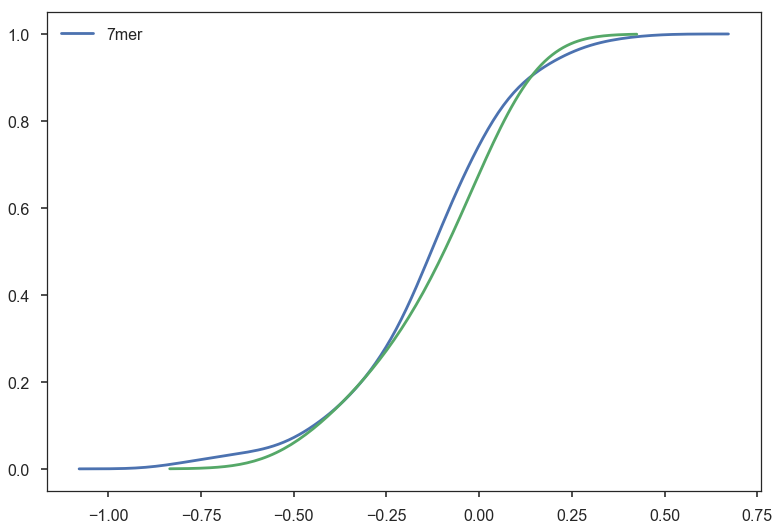

In [104]:
all_seqs = MERGED['sequence'].values
logfc1 = []
logfc2 = []
site8 = config.SITE_DICT['mir139']
for row in MERGED.iterrows():
    utr = row[1]['sequence']
    if np.isnan(row[1]['nosite3']):
        continue
    if ((site8[1:] in utr) or (site8[:-1] in utr)):
        logfc1.append(row[1]['mir139'] - row[1]['nosite3'])
    elif (site8[1:-1] not in utr) and ('ACGGTAGA' in utr):
        logfc2.append(row[1]['mir139'] - row[1]['nosite3'])

sns.kdeplot(np.array(logfc1), cumulative=True, label='7mer')
sns.kdeplot(np.array(logfc2), cumulative=True)

In [ ]:
fig = plt.figure(figsize=(20,15))
for mir_ix, mir in enumerate(TEST_MIRS):
    site8 = config.SITE_DICT[mir]
    temp = kd_pred_test_mirs[kd_pred_test_mirs['mir'] == mir]
    temp['8mer'] = [x[2:-2] for x in temp['12mer']]
    best_NCs = list(temp[temp['stype'] == 'no site'].groupby('8mer').agg(np.mean).sort_values('log_kd').iloc[:3].index)

    subdf1 = temp[temp['stype'] != 'no site']
    subdf1['stype'] = [name_dict[x] for x in subdf1['stype']]
    subdf = [subdf1]
    subdf2 = temp[temp['8mer'].isin(best_NCs)]
    for ix, NC in enumerate(best_NCs):
        subdf2 = temp[temp['8mer'] == NC]
        subdf2['stype'] = 'NC{}'.format(ix+1)
        subdf.append(subdf2)
    subdf = pd.concat(subdf)

    names = np.array(['n8mer','n7m8','n7a1','n6mer','n6m8','n6a1','NC1','NC2','NC3'])
    order = np.argsort(subdf.groupby('stype').agg(np.mean).loc[names]['log_kd'].values)
    seqs = np.array([site8, site8[:-1], site8[1:], site8[1:-1], site8[:-2], site8[2:]] + best_NCs)[order]

    pred_df = []
    for utr in list(MERGED['sequence']):
        all_locs = []
        row = []
        for seq in seqs:
            locs = [m.start() for m in re.finditer(seq, utr)]
            if len(locs) == 0:
                row.append(0)
                continue
            if len(all_locs) == 0:
                all_locs = locs
                row.append(len(locs))
                continue
            keep_locs = []
            for l in locs:
                min_dist = np.min([abs(l - al) for al in all_locs])
                if min_dist > 7:
                    keep_locs.append(l)
            row.append(len(keep_locs))
            all_locs += keep_locs
        pred_df.append(row)

    pred_df = pd.DataFrame(pred_df)
    pred_df.columns = names[order]
    pred_df['log2fc'] = (MERGED[mir] - MERGED['nosite3']).values / np.log(2)
    formula = 'log2fc ~ {} -1'.format(' + '.join(names))
    mod = smf.ols(formula=formula, data=pred_df).fit()
    
    ax = plt.subplot(3,4,mir_ix+1)
    xs = subdf.groupby('stype').agg(np.mean).loc[names]['log_kd'].values
    ys = [mod.params[x] for x in names]
#     plt.scatter(xs, ys)
    ix = 0
    for x, y, stype in zip(xs, ys, names):
        if ix < 6:
            plt.scatter([-1 * x/np.log(10)], [y / np.log(2)], color=sns.hls_palette(6, l=.4, s=.8)[ix], label=stype)
        else:
            plt.scatter([-1 * x/np.log(10)], [y / np.log(2)], color='grey', label=stype)
        ix += 1
#     plt.legend()
    plt.xlabel(r'Predicted $K_A$ (log$_{10}$)')
    plt.ylabel(r'Fold-change (log$_{2}$)')
    plt.title(mir.replace('mir','miR-'))
#     break


plt.tight_layout()
plt.legend(bbox_to_anchor=(2, 0.8))

In [18]:
kd_pred_test_mirs.sort_values('log_kd').head()

12mer    log_kd     mir stype
1379592  AATTGCCAAATA -7.833963  mir182  8mer
1558701  AATTGCCAAATT -7.776916  mir182  8mer
1413478  TATTGCCAAATA -7.695879  mir182  8mer
1365565  CATTGCCAAATA -7.673764  mir182  8mer
1451909  TATTGCCAAATT -7.638834  mir182  8mer

In [67]:
config.SITE_DICT['mir182']

'TTGCCAAA'

In [71]:
temp = kd_pred_test_mirs[kd_pred_test_mirs['stype'] == 'no site']
for mir, group in temp.groupby('mir'):
    print(config.SITE_DICT[mir])
    print(group.sort_values('log_kd').iloc[[0]])

AGCAATAA
              12mer    log_kd     mir    stype
36596  ATAGCATTAAAT -2.761287  mir137  no site
ACTGTAGA
               12mer    log_kd     mir    stype
280564  AAACTGAAGAAG -2.609391  mir139  no site
TCATCTCA
               12mer    log_kd     mir    stype
720811  CTTCATTTCATA -2.787839  mir143  no site
ATACTGTA
               12mer    log_kd     mir    stype
930320  TAATGCTGTAAA -2.701342  mir144  no site
CTATGCAA
                12mer    log_kd     mir    stype
1222240  TACTATGAAATA -2.753096  mir153  no site
TTGCCAAA
                12mer    log_kd     mir    stype
1367394  ATTTGTCAAAAA -3.648162  mir182  no site
ACACTGGA
                12mer    log_kd      mir    stype
1689295  AAACGCTGGAAA -2.473666  mir199a  no site
AAAGGGAA
                12mer    log_kd     mir    stype
1867431  ATAAAGGAAATT -2.454251  mir204  no site
ATGAAGGA
                12mer    log_kd     mir    stype
2098629  AAATGAATGAAA -2.575198  mir205  no site
AGAGATTA
                12mer    log_kd     

In [22]:
temp = kd_pred_all_mirs[kd_pred_all_mirs['mir'] == mir]
temp.sort_values('log_kd').head()


12mer    log_kd      mir    stype
83126   AAAGAGATTATT -4.917940  mir216b     8mer
13618   AAAGAGATTTAA -4.905812  mir216b  7mer-m8
10378   AAAGAGATTAAA -4.905023  mir216b     8mer
20306   AAAGAGATTATA -4.877363  mir216b     8mer
238047  AAAGAGATTTAT -4.831787  mir216b  7mer-m8

In [37]:
mir = 'mir204'
print(config.SITE_DICT[mir])
subdf = kd_pred_all_mirs[kd_pred_all_mirs['mir'] == mir]
print(subdf.groupby('stype').agg(np.mean))
subdf = subdf[subdf['stype'] == 'no site']
subdf.sort_values('log_kd').head(25)

AAAGGGAA
           log_kd
stype            
6mer    -1.851110
6mer-a1 -1.539056
6mer-m8 -0.782359
7mer-a1 -2.273797
7mer-m8 -2.726152
8mer    -3.455273
no site  0.446072


12mer    log_kd     mir    stype
175617  ATAAAGGAAATT -2.454251  mir204  no site
54036   ATAAAGGTAATT -2.378487  mir204  no site
159282  ATAAAGGAAAAT -2.344990  mir204  no site
144705  ATAAAGGAAAGT -2.343054  mir204  no site
261534  ATAAAGTGAATT -2.342313  mir204  no site
34548   ATAAAGGAAACT -2.340286  mir204  no site
45434   ATAAAGGTAAAT -2.338759  mir204  no site
182331  ATAAAGGAAATG -2.329078  mir204  no site
153690  ATAAAGGAAAGA -2.325705  mir204  no site
240112  TTAAAGGAAATT -2.309730  mir204  no site
79269   ATAAAGGAAAGG -2.307376  mir204  no site
23283   ATAAAGGAAATA -2.302179  mir204  no site
248271  ATAAAGGTAATG -2.298578  mir204  no site
117754  ATAAAGTGAAAT -2.288296  mir204  no site
216835  ATAAAGGAAAAG -2.285467  mir204  no site
206321  ATAAAGGTAAGT -2.283972  mir204  no site
243522  ATAAAGGTAAAA -2.283568  mir204  no site
105501  ATAAAGGTAACT -2.274787  mir204  no site
221039  ATAAAGGTAAGA -2.272491  mir204  no site
242519  ATAAAGGTAATA -2.271872  mir204  no site
212234  ATAAAGTGAATG -2.262404  mir204  no site
194544  TTAAAGGTAATT -2.256663  mir204  no site
83511   ATAAAGGTAAAG -2.255932  mir204  no site
89503   ATAAAGTGAAAA -2.254222  mir204  no site
41936   ATAAAGGTAAGG -2.254162  mir204  no site

In [ ]:
# n8mer = utr.count(site8)
#         n7m8 = utr.count(site8[:-1]) - n8mer
#         n7a1 = utr.count(site8[1:]) - n8mer
#         n6mer = utr.count(site8[1:-1]) - n7m8 - n7a1 - n8mer
#         n6m8 = utr.count(site8[:-2]) - n7m8 - n8mer
#         n6a1 = utr.count(site8[2:]) - n7a1 - n8mer
#         if (n8mer + n7m8 + n7a1 + n6mer + n6m8 + n6a1) != helpers.count_num_canon(utr, site8[:-1]):
#             print((n8mer,n7m8,n7a1,n6mer,n6m8,n6a1))
#             print(helpers.count_num_canon(utr, site8[:-1]))
#             print(utr)
#             raise(ValueError())
#         row = [n8mer, n7m8, n7a1, n6mer, n6m8, n6a1]
#         for seq in seqs:
#             row.append(utr.count(seq))
#         pred_df.append(row)

In [48]:
temp = kd_pred_all_mirs[kd_pred_all_mirs['mir'] == 'mir204']
temp1 = temp[temp['stype'] != 'no site']
for stype, group in temp1.groupby('stype'):
    print(stype, np.mean(group['log_kd']))
    
temp2 = temp[['AAAGGTAA' == s[2:-2] for s in temp['12mer']]]
print(np.mean(temp2['log_kd']))

temp2 = temp[['AAATGGAA' == s[2:-2] for s in temp['12mer']]]
np.mean(temp2['log_kd'])


6mer -1.85111
6mer-a1 -1.53906
6mer-m8 -0.782359
7mer-a1 -2.2738
7mer-m8 -2.72615
8mer -3.45527
-1.83671


-1.110425

In [46]:
mir = 'mir204'
site8 = config.SITE_DICT[mir]
seqs = [site8, site8[:-1], site8[1:], site8[1:-1], 'AAAGGTAA', 'AAAGGAAA', 'AAAGTGAA', site8[:-2], site8[2:]]
print(seqs)
names = ['n8mer','n7m8','n7a1','n6mer', 'n8mer_w3', 'n8mer_mm3A','n8mer_w4', 'n6m8', 'n6a1']
preds = stype_linear_model(MERGED.dropna(subset=['nosite3']), mir, seqs, names)

['AAAGGGAA', 'AAAGGGA', 'AAGGGAA', 'AAGGGA', 'AAAGGTAA', 'AAAGGAAA', 'AAAGTGAA', 'AAAGGG', 'AGGGAA']
AAAGGGAA
                            OLS Regression Results                            
Dep. Variable:                 log2fc   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     119.7
Date:                Fri, 06 Jul 2018   Prob (F-statistic):          1.93e-199
Time:                        16:41:05   Log-Likelihood:                 161.17
No. Observations:                3949   AIC:                            -304.3
Df Residuals:                    3940   BIC:                            -247.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------

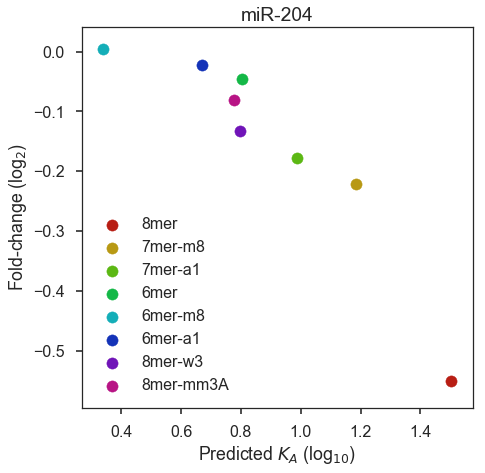

In [51]:
fig = plt.figure(figsize=(7,7))
xs = np.array([-3.45527, -2.72615, -2.2738, -1.85111, -0.782359, -1.53906, -1.83671, -1.7895229])
ys = np.array([-0.3822, -0.1533, -0.1232, -0.0322, 0.0025, -0.0151, -0.0925, -0.0559])
stypes = ['8mer','7mer-m8','7mer-a1','6mer','6mer-m8','6mer-a1','8mer-w3', '8mer-mm3A']

ix = 0
for x, y, stype in zip(xs, ys, stypes):
    plt.scatter([-1 * x/np.log(10)], [y / np.log(2)], color=sns.hls_palette(8, l=.4, s=.8)[ix], label=stype)
    ix += 1
plt.legend()
plt.xlabel(r'Predicted $K_A$ (log$_{10}$)')
plt.ylabel(r'Fold-change (log$_{2}$)')
plt.title('miR-204')

In [30]:
temp = kd_pred_all_mirs[kd_pred_all_mirs['mir'] == 'mir216b']
temp1 = temp[temp['stype'] != 'no site']
for stype, group in temp1.groupby('stype'):
    print(stype, np.mean(group['log_kd']))
    
temp2 = temp[['AGTGATTA' == s[2:-2] for s in temp['12mer']]]
print(np.mean(temp2['log_kd']))

temp2 = temp[['AGGGATTA' == s[2:-2] for s in temp['12mer']]]
np.mean(temp2['log_kd'])


6mer -1.90787
6mer-a1 -1.57535
6mer-m8 -1.29574
7mer-a1 -2.3354
7mer-m8 -2.41636
8mer -2.87933
-2.04579


-1.9315448

In [28]:
mir = 'mir216b'
site8 = config.SITE_DICT[mir]
seqs = [site8, site8[:-1], site8[1:], site8[1:-1], 'AGTGATTA', 'AGGGATTA', site8[:-2], site8[2:]]
print(seqs)
names = ['n8mer','n7m8','n7a1','n6mer', 'n8mer_bT6', 'n8mer_w6','n6m8', 'n6a1']
preds = stype_linear_model(MERGED.dropna(subset=['nosite3']), mir, seqs, names)

['AGAGATTA', 'AGAGATT', 'GAGATTA', 'GAGATT', 'AGTGATTA', 'AGGGATTA', 'AGAGAT', 'AGATTA']
AGAGATTA
                            OLS Regression Results                            
Dep. Variable:                 log2fc   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     177.1
Date:                Fri, 06 Jul 2018   Prob (F-statistic):          3.28e-256
Time:                        16:22:45   Log-Likelihood:                -77.952
No. Observations:                3949   AIC:                             171.9
Df Residuals:                    3941   BIC:                             222.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

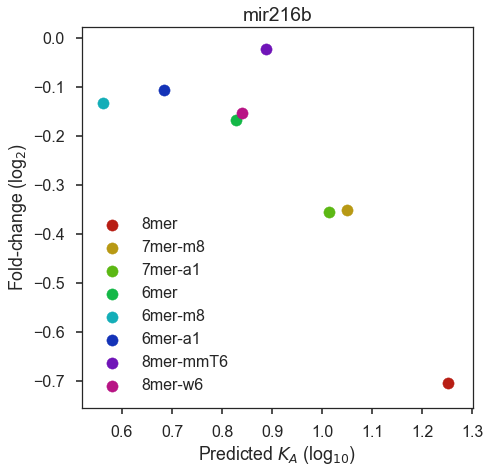

In [52]:
fig = plt.figure(figsize=(7,7))
xs = np.array([-2.87933, -2.41636, -2.3354, -1.90787, -1.29574, -1.57535, -2.04579, -1.9315448])
ys = np.array([-0.4880, -0.2427, -0.2458, -0.1152, -0.0925, -0.0736, -0.0159, -0.1058])
stypes = ['8mer','7mer-m8','7mer-a1','6mer','6mer-m8','6mer-a1','8mer-mmT6', '8mer-w6']

ix = 0
for x, y, stype in zip(xs, ys, stypes):
    plt.scatter([-1 * x/np.log(10)], [y / np.log(2)], color=sns.hls_palette(8, l=.4, s=.8)[ix], label=stype)
    ix += 1
plt.legend()
plt.xlabel(r'Predicted $K_A$ (log$_{10}$)')
plt.ylabel(r'Fold-change (log$_{2}$)')
plt.title('mir216b')

In [146]:
mir = 'mir137'
site8 = config.SITE_DICT[mir]
seqs = [site8, site8[:-1], site8[1:], site8[1:-1], site8[:-2], site8[2:], 'GCAATCA']
print(seqs)
names = ['n8mer','n7m8','n7a1','n6mer', 'n6m8', 'n6a1','blah']
preds = stype_linear_model(MERGED.dropna(subset=['nosite3']), mir, seqs, names)

['AGCAATAA', 'AGCAATA', 'GCAATAA', 'GCAATA', 'AGCAAT', 'CAATAA', 'GCAATCA']
AGCAATAA
                            OLS Regression Results                            
Dep. Variable:                 log2fc   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     261.8
Date:                Thu, 05 Jul 2018   Prob (F-statistic):          4.90e-321
Time:                        16:52:30   Log-Likelihood:                -839.65
No. Observations:                3949   AIC:                             1693.
Df Residuals:                    3942   BIC:                             1737.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

In [145]:
temp = kd_pred_test_mirs[kd_pred_test_mirs['mir'] == 'mir137']
np.mean(temp[['GCAATCA' in s for s in temp['12mer']]]['log_kd'])

-2.275725331529975

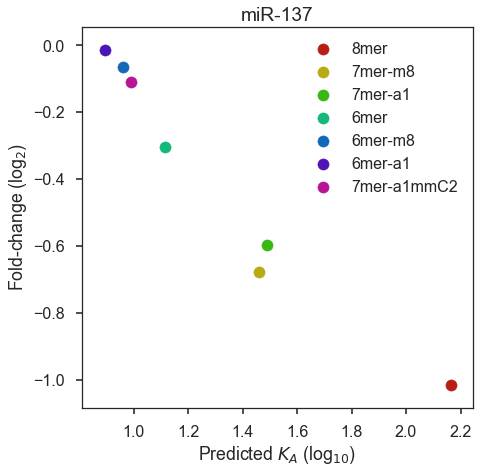

In [53]:
fig = plt.figure(figsize=(7,7))
xs = np.array([-4.984578, -3.363530, -3.432819, -2.570188, -2.212487, -2.060524, -2.275725331529975])
ys = np.array([-0.7052, -0.4706, -0.4149, -0.2107, -0.0439,-0.0089, -0.0758])
stypes = ['8mer','7mer-m8','7mer-a1','6mer','6mer-m8','6mer-a1','7mer-a1mmC2']

ix = 0
for x, y, stype in zip(xs, ys, stypes):
    plt.scatter([-1 * x/np.log(10)], [y / np.log(2)], color=sns.hls_palette(7, l=.4, s=.8)[ix], label=stype)
    ix += 1
plt.legend()
plt.xlabel(r'Predicted $K_A$ (log$_{10}$)')
plt.ylabel(r'Fold-change (log$_{2}$)')
plt.title('miR-137')

In [124]:
MERGED.loc['NM_000248']['sequence']

'CGAATCCTCCCTGCACTGCATTCGCACAAACTGCTTCCTTTCTTGATTCGTAGATTTAATAACTTACCTGAAGGGGTTTTCTTGATAATTTTCCTTTAATATGAAATTTTTTTTCATGCTTTATCAATAGCCCAGGATATATTTTATTTTTAGAATTTTGTGAAACAGACTTGTATATTCTATTTTACAACTACAAATGCCTCCAAAGTATTGTACAAATAAGTGTGCAGTATCTGTGAACTGAATTCACCACAGACTTTAGCTTTCTGAGCAAGAGGATTTTGCGTCAGAGAAATGTCTGTCCATTTTTATTCAGGGGAAACTTGATTTGAGATTTTTATGCCTGTGACTTCCTTGGAAATCAAATGTAAAGTTTAATTGAAAGAATGTAAAGCAACCAAAAAGAAAAAAAAAAAGAAAGAAAGAGGAAAAGAAATCCATACTAACCCTTTTCCATTTTATAAATGTATTGATTCATTGGTACTGCCTTAAAGATACAGTACCCCTCTAGCTTTGTTTAGTCTTTATACTGCAAACTATTTAAAGAAATATGTATTCTGTAAAAGAAAAAAAAAATGCGGCCTTTTCATGAGGATCGTCTGGTTAGAAAACATAACTGATACCAACCGAAACTGAAGGGAGTTAGACCAAGGCTCTGAAATATAAAGTCTAATCTTGCTCTCTTTTATTCTGTGCTGTTACAGTTTTCTTCATCAATGAGTGTGATCCAGTTTTTCATAAGATATTTTATTTTGAAATGGAAATTAATGTCCTCTCAAAGTAAAATATTGAGGAGCACTGAAAGTATGTTTTACTTTTTTTTTATTTTATTTTTGCTTTTGATAAGAAAACCGAACTGGGCATATTTCTAATTGGCTTTACTATTTTTATTTTTAAATTATGTTTTACTGTTCATTTGATTTGTACAGATTCTTTATTATCATTGTTCTTTTCAATATATTTGTATTAATTTGTAAGAATATGCATCTTAAAATGGCA

-0.0628789417985
-0.037127641637


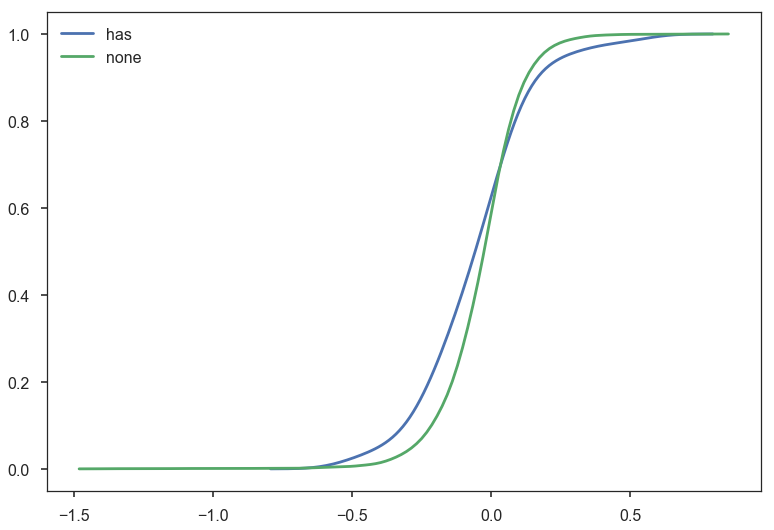

In [126]:
temp = preds[preds['num_canon'] == 0]
temp1 = temp[temp['n7mer_w4'] > 0]
temp2 = temp[temp['n7mer_w4'] == 0]
print(np.mean(temp1['log2fc']))
print(np.mean(temp2['log2fc']))
sns.kdeplot(temp1['log2fc'], cumulative=True, label='has')
sns.kdeplot(temp2['log2fc'], cumulative=True, label='none')

In [40]:
config.SITE_DICT['mir137'], config.SITE_DICT['mir155']

('AGCAATAA', 'AGCATTAA')

In [48]:
color_dict = {
        '8mer': 'red',
        '7mer-m8': 'orange',
        '7mer-a1': 'yellow',
        '6mer': 'green',
        '6mer-m8': 'blue',
        '6mer-a1': 'purple',
        'no site': 'grey'
    }

In [65]:
kd_pred_df.head()

seq    log_kd   mir                  mirseq    stype  keep_prob  \
0  AAAAAATCCAAA -0.810633  mir1  TGGAATGTAAAGAAGTATGTAT  no site   0.100709   
1  AAAAAATCCAAC -1.805606  mir1  TGGAATGTAAAGAAGTATGTAT  no site   0.232474   
2  AAAAAATCCAAG -0.287849  mir1  TGGAATGTAAAGAAGTATGTAT  no site   0.062260   
3  AAAAAATCCAAT -0.206237  mir1  TGGAATGTAAAGAAGTATGTAT  no site   0.057662   
4  AAAAAATCCACA -1.096425  mir1  TGGAATGTAAAGAAGTATGTAT  no site   0.129704   

     log ka      pred  
0  0.810633  1.652750  
1  1.805606  1.621552  
2  0.287849  1.580768  
3  0.206237  1.686746  
4  1.096425  1.613514

0.123245321332


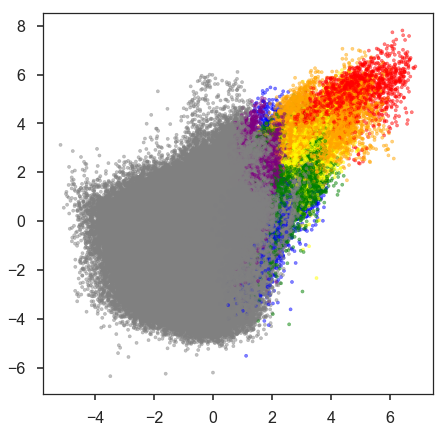

In [67]:
fig = plt.figure(figsize=(7,7))
temp = kd_pred_df.copy()
# temp1 = kd_pred_df[kd_pred_df['stype'] != 'no site']
# temp2 = kd_pred_df[kd_pred_df['stype'] == 'no site']
# temp2 = temp2[temp2['log ka'] > 0]
# print(len(temp2))
# temp = pd.concat([temp1, temp2])
# temp = temp[temp['log ka'] > 0]
plt.scatter(temp['pred'], temp['log ka'], color=[color_dict[x] for x in temp['stype']],s=10,alpha=0.5)
print(stats.linregress(temp['pred'], temp['log ka'])[2]**2)

In [72]:
log_dir = '/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_4_16_16/'
tf.reset_default_graph()
with tf.Session() as sess:

    sess.run(tf.global_variables_initializer())
    latest = tf.train.latest_checkpoint('{}/none/saved'.format(log_dir))
    print(latest)
    saver = tf.train.import_meta_graph(latest + '.meta')
    saver.restore(sess, latest)

    _keep_prob = tf.get_default_graph().get_tensor_by_name('keep_prob:0')
    _phase_train = tf.get_default_graph().get_tensor_by_name('phase_train:0')
    _combined_x = tf.get_default_graph().get_tensor_by_name('biochem_x:0')
    _prediction = tf.get_default_graph().get_tensor_by_name('final_layer/pred_ka:0')

    i = 0
    for op in tf.get_default_graph().get_operations():
#         print(str(op.name))
        if 'relu' in str(op.name):
            print(str(op.name))
        i += 1

/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_4_16_16/none/saved/model-100
INFO:tensorflow:Restoring parameters from /lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/simple_xval_4_16_16/none/saved/model-100


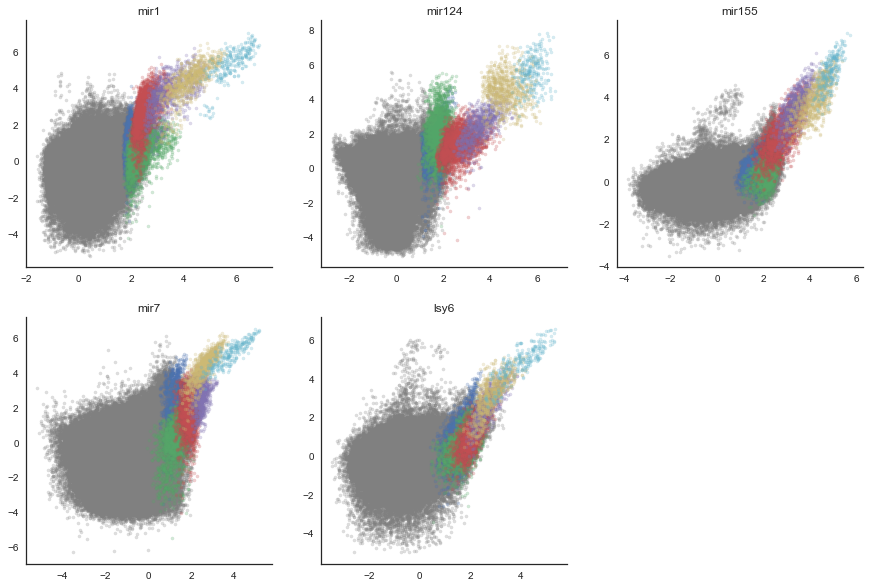

In [13]:
fig = plt.figure(figsize=(15,10))
for ix, mir in enumerate(['mir1','mir124','mir155','mir7','lsy6']):
    ax = plt.subplot(2,3,ix+1)
    data_test = kd_pred_df[kd_pred_df['mir'] == mir]
    for stype in ['no site','6mer-a1','6mer-m8','6mer','7mer-a1','7mer-m8','8mer']:
        group = data_test[data_test['stype'] == stype]
        if stype == 'no site':
            plt.scatter(group['pred'], group['log ka'], s=10, label=stype, color='grey', alpha=0.25)
        else:
            plt.scatter(group['pred'], group['log ka'], s=10, label=stype, alpha=0.25)
#     plt.legend()
    ax.set_title(mir)
    # plt.xlim(-2,7)
    # plt.ylim(-2,7)
    sns.despine()


In [ ]:
fig = plt.figure(figsize=(15,10))
for ix, mir in enumerate(['mir1','mir124','mir155','mir7','lsy6']):
    ax = plt.subplot(2,3,ix+1)
    data_test = kd_pred_df_[kd_pred_df_['mir'] == mir]
    for stype in ['no site','6mer-a1','6mer-m8','6mer','7mer-a1','7mer-m8','8mer']:
        group = data_test[data_test['stype'] == stype]
        if stype == 'no site':
            plt.scatter(group['pred'], group['log ka'], s=10, label=stype, color='grey', alpha=0.25)
        else:
            plt.scatter(group['pred'], group['log ka'], s=10, label=stype, alpha=0.25)
#     plt.legend()
    ax.set_title(mir)
    # plt.xlim(-2,7)
    # plt.ylim(-2,7)
    sns.despine()


In [9]:
# nosite1_dict, nosite2_dict, nosite3_dict = {x: [] for x in MERGED.index}, {x: [] for x in MERGED.index}, {x: [] for x in MERGED.index}
# nosite1, nosite2, nosite3 = [], [], []
# ALL_MIRS = [x for x in MERGED.columns if (('mir' in x) or ('lsy' in x))]
# print(len(ALL_MIRS))
# for row in MERGED.iterrows():
#     utr = row[1]['sequence']
#     nosite1_temp, nosite2_temp, nosite3_temp = [], [], []
#     for mir in ALL_MIRS:
#         site = config.SITE_DICT[mir][:-1]
#         site_star = config.SITE_DICT[mir + '*'][:-1]
#         if (site[1:] not in utr) and (site_star[1:] not in utr):
#             nosite1_temp.append(row[1][mir])
#             nosite1_dict[row[0]].append(mir)
#         if (site[:-1] not in utr) and (site[1:] not in utr) and ((site[2:] + 'A') not in utr):
#             nosite2_temp.append(row[1][mir])
#             nosite2_dict[row[0]].append(mir)
#         if (site[:-1] not in utr) and (site[1:] not in utr) and ((site[2:] + 'A') not in utr) and (site_star[1:] not in utr):
#             nosite3_temp.append(row[1][mir])
#             nosite3_dict[row[0]].append(mir)
            
#     if len(nosite1_temp) > 0:
#         nosite1.append(np.mean(nosite1_temp))
#     else:
#         nosite1.append(None)
#     if len(nosite2_temp) > 0:
#         nosite2.append(np.mean(nosite2_temp))
#     else:
#         nosite2.append(None)
#     if len(nosite3_temp) > 0:
#         nosite3.append(np.mean(nosite3_temp))
#     else:
#         nosite3.append(None)

# MERGED['nosite1'] = nosite1
# MERGED['nosite2'] = nosite2
# MERGED['nosite3'] = nosite3
# print(len(MERGED.dropna(subset=['nosite1'])))
# print(len(MERGED.dropna(subset=['nosite2'])))
# print(len(MERGED.dropna(subset=['nosite3'])))
# MERGED.head()

3949
3949
3949
3949
3949
3949
3949
3949
3949
3949
3949
3949
3949
3949
3949
3949


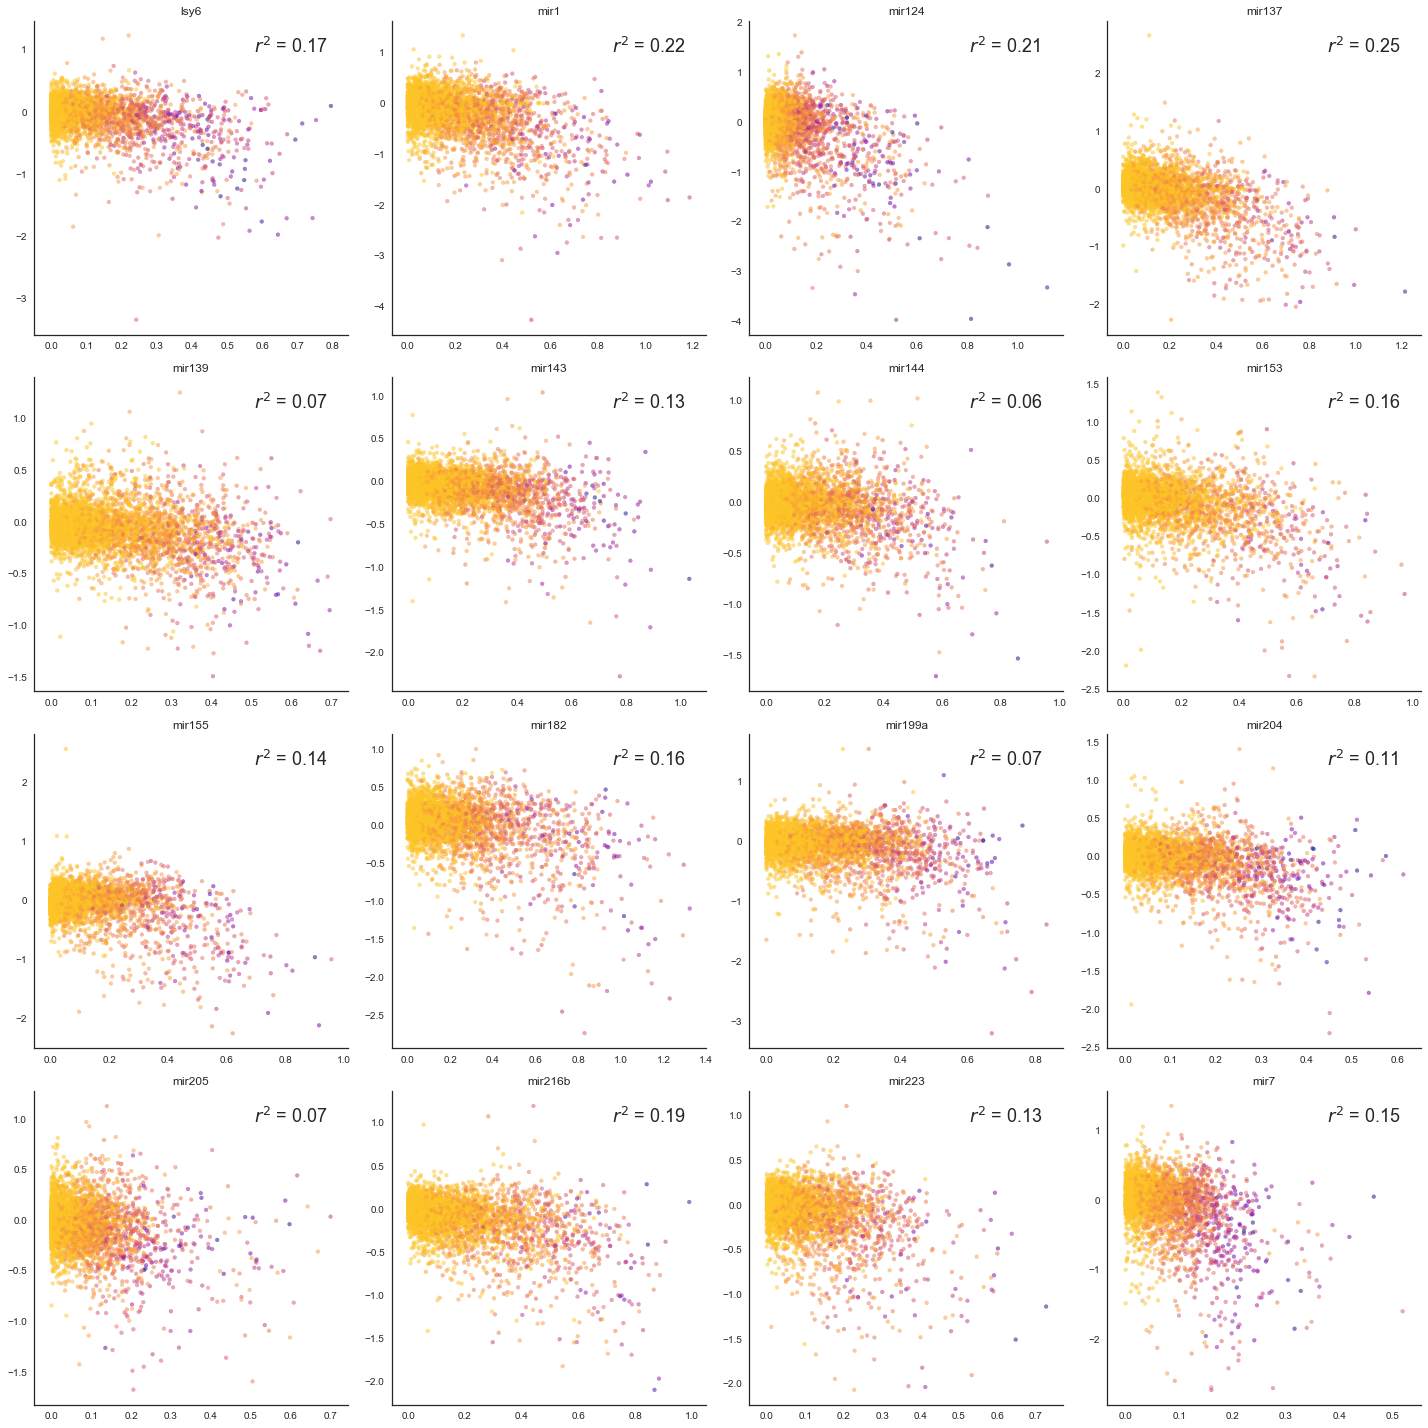

In [15]:
num_colors = 9

fig = plt.figure(figsize=(20,20))
ax_colorbar = fig.add_axes([0.9, 0.15, 0.01, 0.75])
new_cmap = discrete_colorbar(ax_colorbar, plt.cm.plasma, 9, 'vertical')

kwargs = {'vmin': 0,
          'vmax': num_colors-1,
          'cmap': new_cmap,
          's':15,
          'alpha': 0.5}

utr_list = list(MERGED['sequence'].values)
r2_dict = {}

for IX, TEST_MIR in enumerate(ALL_MIRS):
#     print(TEST_MIR)
    ax = plt.subplot(4,4,IX+1)
    utr_len = MERGED['utr_length'].values
    try:
        paramfile = pd.read_csv('{}/{}/fitted_params.txt'.format(LOG_DIR, TEST_MIR), sep='\t', index_col=0, header=None)
    except:
        continue
    params = {'freeAgo_guide': freeAgo_guide.loc[TEST_MIR]['mean'],
          'freeAgo_pass': freeAgo_pass.loc[TEST_MIR]['mean'],
          'utr_coef': paramfile.loc['utr_coef'][1],
#           'freeAGO_let7': paramfile.loc['freeAGO_let7'][1],
          'decay': paramfile.loc['decay'][1]}

    all_preds, all_tpms = np.zeros([len(MERGED), len(ALL_MIRS)]), np.zeros([len(MERGED), len(ALL_MIRS)])
    with open(os.path.join(PREDICT_DIR, '{}.pickle'.format(TEST_MIR)), 'rb') as infile:
#         print(infile)
        preds = pickle.load(infile)
        for ix, mir in enumerate(ALL_MIRS):
            pred_guide = preds[mir]
            kds_guide = -1 * np.array(pred_guide['KDs'])
            num_seqs_guide = pred_guide['num_seqs']

            pred_pass = preds[mir+'*']
            kds_pass = -1 * np.array(pred_pass['KDs'])
            num_seqs_pass = pred_pass['num_seqs']

            logfc = get_logfc_simple(kds_guide, num_seqs_guide, kds_pass, num_seqs_pass, utr_len, params)

            all_preds[:, ix] = logfc
            all_tpms[:, ix] = MERGED[mir].values
    
    all_preds_df = pd.DataFrame(all_preds, columns=ALL_MIRS).set_index(MERGED.index)
    all_tpms_df = pd.DataFrame(all_tpms, columns=ALL_MIRS).set_index(MERGED.index)

    sitem8 = config.SITE_DICT[TEST_MIR][:-1]
    temp = MERGED[[TEST_MIR, 'nosite3']]
    temp['pred'] = all_preds_df[TEST_MIR].values
    temp['num_canon'] = [count_num_canon(utr, sitem8) for utr in utr_list]
    temp = temp.dropna()
    print(len(temp))
    temp['logfc'] = temp[TEST_MIR] - temp['nosite3']
    
    pred = temp['pred'] / np.log(2)
    actual = temp['logfc'] / np.log(2)
    num_canon = temp['num_canon']
    r2_dict[TEST_MIR] = stats.linregress(pred, actual)[2]**2
    ax.scatter(pred, actual, c=num_canon, **kwargs)
    ax.set_title(TEST_MIR)
    ax.text(0.7,0.9,r'$r^2$ = {:.2f}'.format(stats.linregress(pred, actual)[2]**2),
            fontsize=18, transform=ax.transAxes)
    stats.linregress(pred, actual)[2]**2
    
    sns.despine()
#     break

plt.tight_layout()

In [10]:
for mir in ALL_MIRS:
    if mir in r2_dict:
        print(r2_dict[mir])
    else:
        print('na')

0.215494770673
0.29667761993
0.264375533105
0.302742856688
0.0889851292731
0.18600605102
0.098240653582
0.199386599181
0.254953149702
0.197952693533
0.158616261938
0.180832557995
0.0776883977213
0.236551401027
0.200448343827
0.2098629105


In [ ]:
0.19143105615
0.253267266773
0.198794429638
0.322235355284
0.0724270895966
0.150998617027
0.0825705542434
0.174783383318
0.205201864079
0.177974959581
0.0968432547465
0.125481496897
0.078419549419
0.234804537715
0.168286079993
0.205694389782

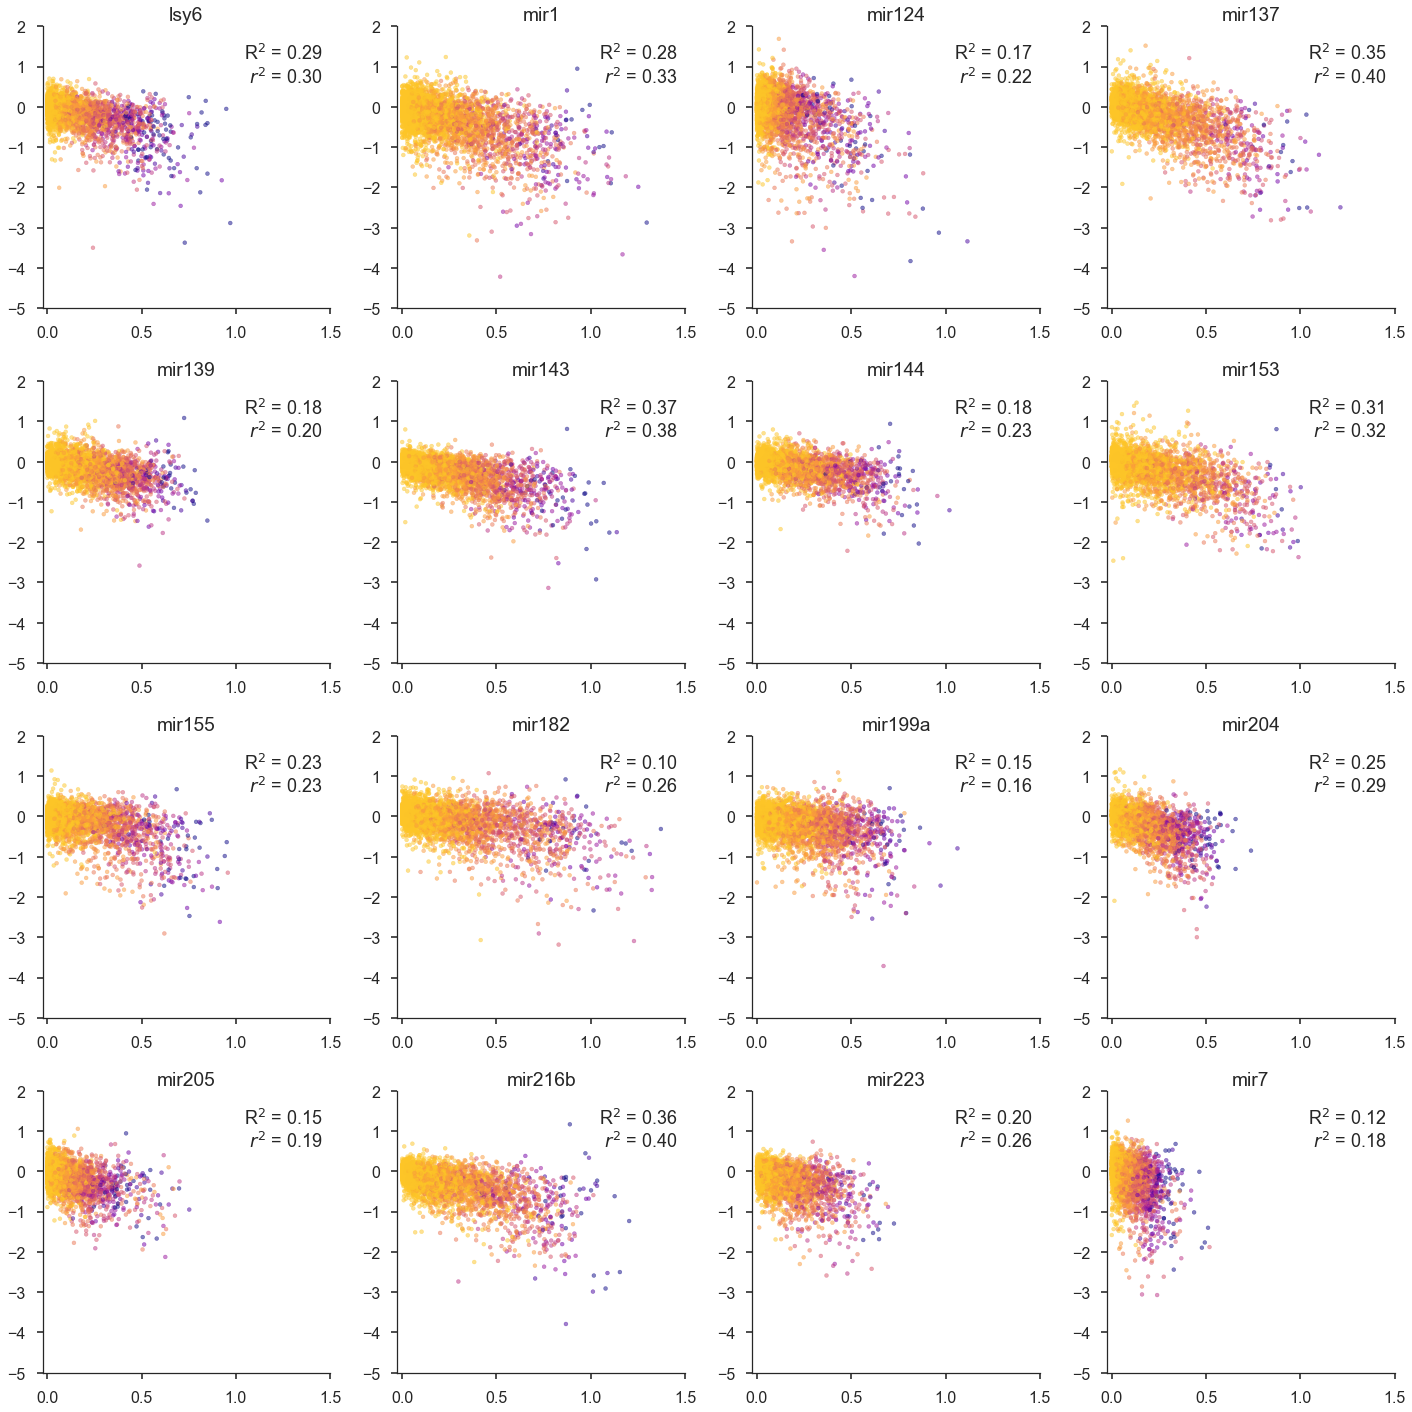

In [30]:
sns.set_style('ticks')
sns.set_context('poster')
num_colors = 9

fig = plt.figure(figsize=(20,20))
ax_colorbar = fig.add_axes([0.9, 0.15, 0.01, 0.75])
new_cmap = discrete_colorbar(ax_colorbar, plt.cm.plasma, 9, 'vertical')

kwargs = {'vmin': 0,
          'vmax': num_colors-1,
          'cmap': new_cmap,
          's':15,
          'alpha': 0.5}

intercept_dict = {}
utr_list = list(MERGED['sequence'].values)
ALL_PREDS = []
ALL_ACTUALS = []
ALL_PRED_DICT = {}
r2_dict_bayes = {}

for IX, TEST_MIR in enumerate(ALL_MIRS):
#     print(TEST_MIR)
    ax = plt.subplot(4,4,IX+1)
    ax.set_xlim(-0.025,1.5)
    ax.set_ylim(-5,2)
    utr_len = MERGED['utr_length'].values
    try:
        paramfile = pd.read_csv('{}/{}/fitted_params.txt'.format(LOG_DIR, TEST_MIR), sep='\t', index_col=0, header=None)
    except:
        continue
    params = {'freeAgo_guide': freeAgo_guide.loc[TEST_MIR]['mean'],
          'freeAgo_pass': freeAgo_pass.loc[TEST_MIR]['mean'],
          'utr_coef': paramfile.loc['utr_coef'][1],
#           'freeAGO_let7': paramfile.loc['freeAGO_let7'][1],
          'decay': paramfile.loc['decay'][1]}

    all_preds, all_tpms = np.zeros([len(MERGED), len(ALL_MIRS)]), np.zeros([len(MERGED), len(ALL_MIRS)])
    with open(os.path.join(PREDICT_DIR, '{}.pickle'.format(TEST_MIR)), 'rb') as infile:
#         print(infile)
        preds = pickle.load(infile)
        for ix, mir in enumerate(ALL_MIRS):
            pred_guide = preds[mir]
            kds_guide = -1 * np.array(pred_guide['KDs'])
            num_seqs_guide = pred_guide['num_seqs']

            pred_pass = preds[mir+'*']
            kds_pass = -1 * np.array(pred_pass['KDs'])
            num_seqs_pass = pred_pass['num_seqs']

            logfc = get_logfc_simple(kds_guide, num_seqs_guide, kds_pass, num_seqs_pass, utr_len, params)

            all_preds[:, ix] = logfc
            all_tpms[:, ix] = MERGED[mir].values
    
    all_preds_df = pd.DataFrame(all_preds, columns=ALL_MIRS).set_index(MERGED.index)
    all_tpms_df = pd.DataFrame(all_tpms, columns=ALL_MIRS).set_index(MERGED.index)
    
    other_mirs = [m for m in ALL_MIRS if m != TEST_MIR]
#     print(len(other_mirs))
    intercept = get_bayes_intercept(all_preds_df[other_mirs].values, all_tpms_df[other_mirs].values, 0, 0.01)
    intercept_dict[TEST_MIR] = intercept
    ALL_PRED_DICT[TEST_MIR] = all_preds_df[TEST_MIR].values
    pred = all_preds_df[TEST_MIR].values / np.log(2)
    actual = (all_tpms_df[TEST_MIR] - intercept) / np.log(2)
    sitem8 = config.SITE_DICT[TEST_MIR][:-1]
    num_canon = [count_num_canon(utr, sitem8) for utr in utr_list]
    ax.scatter(pred, actual, c=num_canon, **kwargs)
    ax.set_title(TEST_MIR)
    r2 = stats.linregress(pred, actual)[2]**2
    R2 = calc_rsquared(-1 * pred, actual)
    ax.text(0.7,0.8,r"R$^2$ = {:.2f}".format(R2) + "\n" + " $r^2$ = {:.2f}".format(r2),
            fontsize=18, transform=ax.transAxes)
    stats.linregress(pred, actual)[2]**2
    r2_dict_bayes[TEST_MIR] = (R2, r2)
    
    sns.despine()
    ALL_PREDS += list(pred)
    ALL_ACTUALS += list(actual)
#     break

plt.tight_layout()

In [31]:
for mir in ALL_MIRS:
    if mir in r2_dict_bayes:
        print(r2_dict_bayes[mir])
    else:
        print('na')

(0.2914145970926918, 0.30366465705725371)
(0.28263528952770411, 0.32673267168496417)
(0.17300815832509375, 0.21516795342539216)
(0.35336027805818226, 0.40186592255201886)
(0.1843632725027885, 0.20129687945119457)
(0.37216943298657224, 0.37535460265559345)
(0.17810927524370657, 0.23184945546983421)
(0.31479392582851651, 0.32224879677603296)
(0.22857531820571098, 0.23419177802822227)
(0.10044772303540306, 0.25563940849153022)
(0.15272586846508196, 0.15692919611690684)
(0.25045618786223556, 0.29216406098406328)
(0.15324269197881635, 0.1927911613483286)
(0.35983163221496628, 0.39657636291938525)
(0.19896303652479042, 0.25610598240071469)
(0.11673317291680563, 0.18392491741294772)


In [31]:
ts7_preds = pd.read_csv('../../../../RNA_Seq/analysis/data/final/ts7_method3_preds.txt', sep='\t')
ts7_preds.head()

ID    Gene_ID  log2fc_bayes  log2fc_method3 miRNA_family  \
0  NM_000088mir182  NM_000088      0.143218        0.112690       mir182   
1  NM_000110mir182  NM_000110     -0.324169       -0.249580       mir182   
2  NM_000127mir182  NM_000127     -0.276793       -0.257238       mir182   
3  NM_000191mir182  NM_000191     -0.207348       -0.209690       mir182   
4  NM_000248mir182  NM_000248     -1.084503       -1.100122       mir182   

   ngood  nsites      pred  pred_agarwal  pred_bayes  num_canon  
0      1       1 -0.158963     -0.037050   -0.241677          3  
1      1       1 -0.206671     -0.070425   -0.291882          2  
2      0       1 -0.091637     -0.026183   -0.130976          1  
3      0       1 -0.051030     -0.012477   -0.073079          1  
4      3       4 -1.976907     -0.432178   -2.211744          5

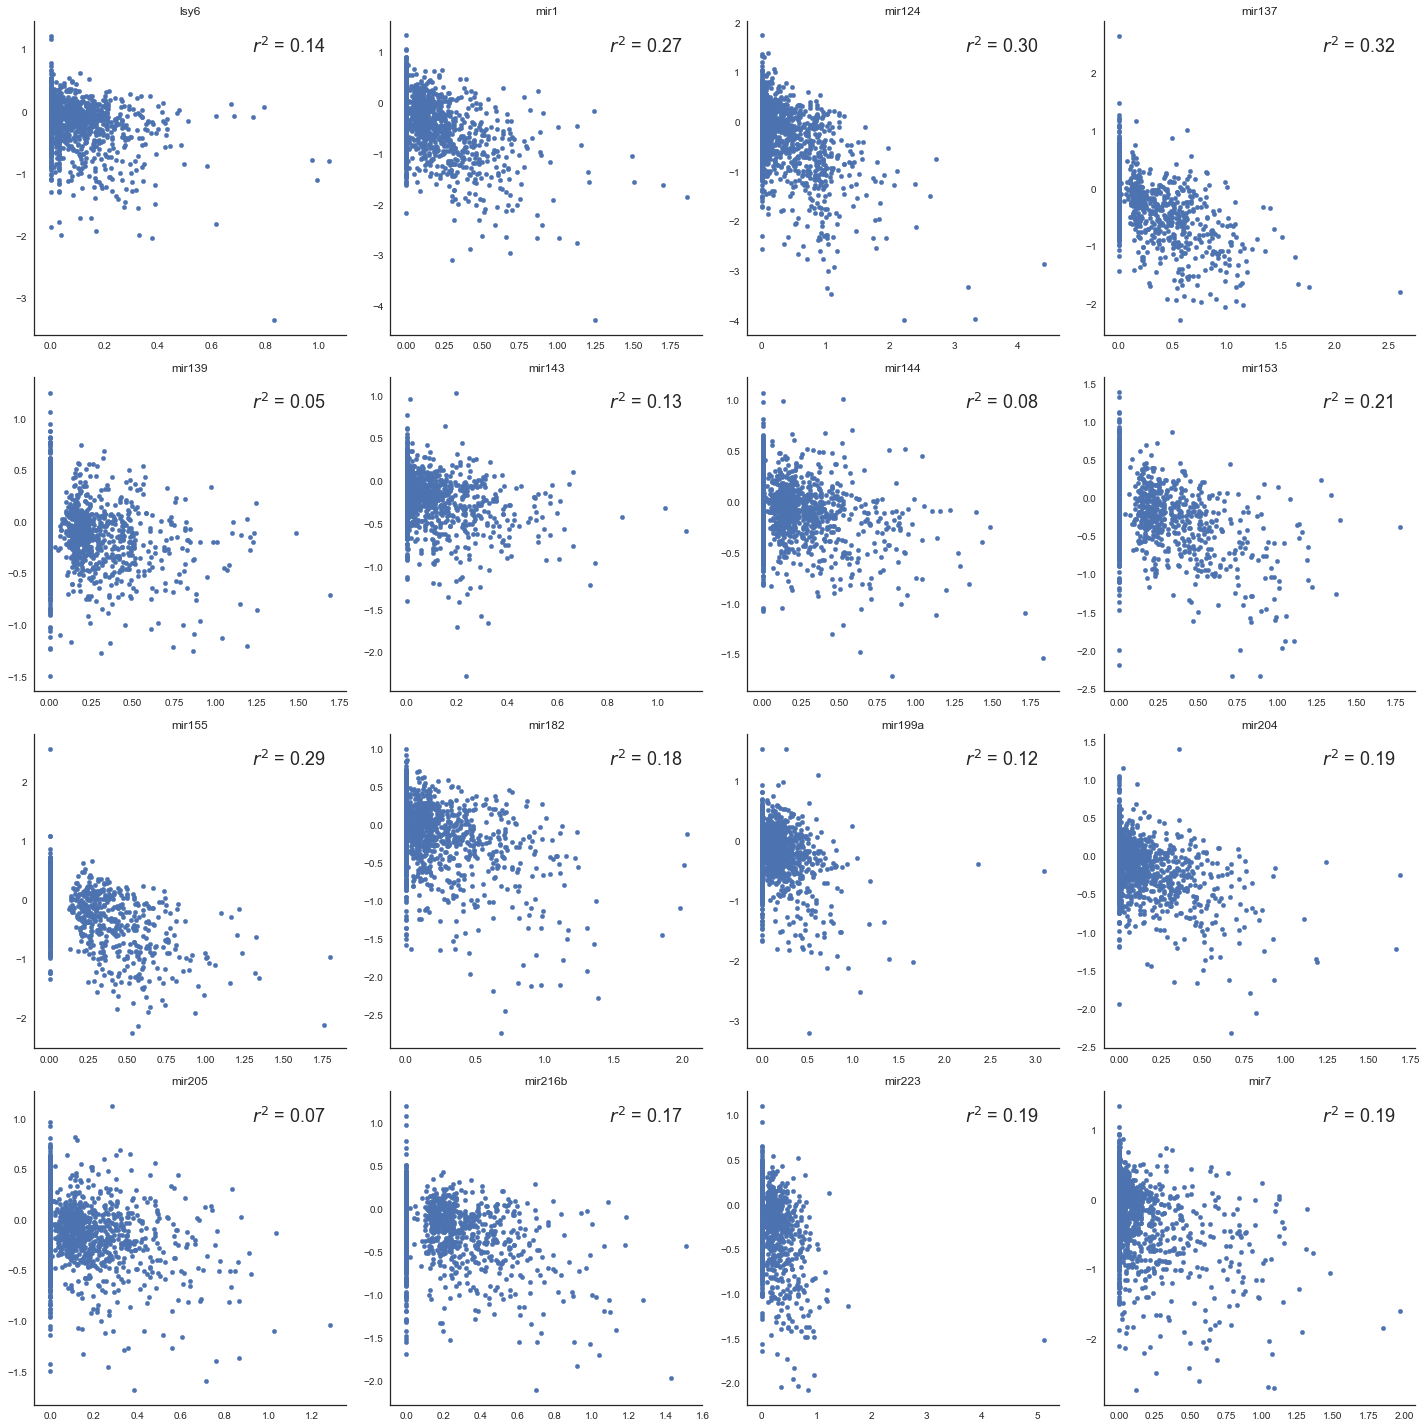

In [32]:
x_col = 'pred'
y_col = 'log2fc_method3'
fig = plt.figure(figsize=(20,20))
ts7_r2_dict = {}
ts7_mirs = list(ts7_preds['miRNA_family'].unique())
for ix, mir in enumerate(sorted(ts7_mirs)):
    ax = plt.subplot(4,4,ix+1)
    temp = ts7_preds[ts7_preds['miRNA_family'] == mir].dropna(subset=[y_col])
    xs, ys = -1 * temp[x_col], temp[y_col]
    ax.scatter(xs, ys, s=20)
    ax.set_title(mir)
    r2 = stats.linregress(xs, ys)[2]**2
    ax.text(0.7,0.9,r'$r^2$ = {:.2f}'.format(r2),
            fontsize=18, transform=ax.transAxes)
    sns.despine()
    ts7_r2_dict[mir] = r2
plt.tight_layout()

In [33]:
for mir in ALL_MIRS:
    if mir in ts7_r2_dict:
        print(ts7_r2_dict[mir])
    else:
        print('na')

0.136341292006
0.273513300707
0.300803961076
0.324874557248
0.0459349713891
0.133975627895
0.0803651882442
0.207383411634
0.293748202848
0.183643853475
0.11816532938
0.185850096375
0.0749838230003
0.168569195113
0.194552540422
0.190287095365


In [24]:
blah = pd.read_csv('/lab/bartel4_ata/kathyl/RNA_Seq/analysis/r2_06_07_2018.txt',sep='\t')
blah

miRNA       TS7  biochem_only_canon_sites_method2  \
0      lsy6  0.136341                          0.237262   
1      mir1  0.273513                          0.333113   
2    mir124  0.300804                          0.325239   
3    mir137  0.324875                               NaN   
4    mir139  0.045935                               NaN   
5    mir143  0.133976                               NaN   
6    mir144  0.080365                               NaN   
7    mir153  0.207383                               NaN   
8    mir155  0.293748                          0.269247   
9    mir182  0.183644                               NaN   
10  mir199a  0.118165                               NaN   
11   mir204  0.185850                               NaN   
12   mir205  0.074984                               NaN   
13  mir216b  0.168569                               NaN   
14   mir223  0.194553                               NaN   
15     mir7  0.190287                          0.269985   

    NN_only_canon_sites_method2  NN_only_canon_sites_bayes  \
0                      0.202166                   0.254844   
1                      0.318056                   0.347919   
2                      0.258448                   0.240255   
3                      0.302498                   0.342948   
4                      0.079267                   0.080690   
5                      0.170912                   0.238547   
6                      0.099092                   0.130008   
7                      0.185797                   0.249592   
8                      0.247492                   0.274574   
9                      0.213098                   0.212253   
10                     0.133651                   0.156712   
11                     0.186618                   0.206926   
12                     0.085777                   0.119810   
13                     0.197577                   0.245182   
14                     0.184140                   0.216643   
15                     0.230056                   0.206800   

    NN_all_12mers_method2  NN_all_12mers_bayes  
0                0.191185             0.277970  
1                0.253915             0.333666  
2                0.199621             0.185514  
3                0.322584             0.394272  
4                0.072020             0.186827  
5                0.151119             0.316318  
6                0.082299             0.257429  
7                0.175308             0.335244  
8                0.205413             0.280951  
9                0.177855             0.222659  
10               0.096761             0.198245  
11               0.124931             0.281670  
12               0.078022             0.231879  
13               0.234686             0.364324  
14               0.168254             0.314094  
15               0.239706             0.233944

In [23]:
ts7_r2_dict

{'lsy6': 0.13634129200599809,
 'mir1': 0.27351330070746871,
 'mir124': 0.30080396107641133,
 'mir137': 0.32487455724783032,
 'mir139': 0.045934971389112907,
 'mir143': 0.1339756278952236,
 'mir144': 0.080365188244195862,
 'mir153': 0.20738341163435098,
 'mir155': 0.29374820284767933,
 'mir182': 0.18364385347457152,
 'mir199a': 0.11816532938036658,
 'mir204': 0.18585009637507696,
 'mir205': 0.074983823000269081,
 'mir216b': 0.16856919511343985,
 'mir223': 0.19455254042155148,
 'mir7': 0.19028709536515051}

In [9]:
# only canon, orf sites
# r2_dict

{'lsy6': 0.20216572158036214,
 'mir1': 0.31805568305725235,
 'mir124': 0.25844779344298902,
 'mir137': 0.30249831506174635,
 'mir139': 0.079267288690546778,
 'mir143': 0.17091227446453844,
 'mir144': 0.099092072258064837,
 'mir153': 0.18579671986011884,
 'mir155': 0.24749167906981304,
 'mir182': 0.21309810077618679,
 'mir199a': 0.13365070115952293,
 'mir204': 0.18661806710790971,
 'mir205': 0.085777414007270139,
 'mir216b': 0.19757654891603951,
 'mir223': 0.18414034168820381,
 'mir7': 0.23005604269137844}

In [17]:
# all 12mers
r2_dict

{'lsy6': 0.19118517382503533,
 'mir1': 0.25391475492129351,
 'mir124': 0.19962078986010759,
 'mir137': 0.32258359278152121,
 'mir139': 0.072019609682242663,
 'mir143': 0.15111932746466061,
 'mir144': 0.08229898691537342,
 'mir153': 0.17530827265769391,
 'mir155': 0.2054127843064201,
 'mir182': 0.17785540188265733,
 'mir199a': 0.096761024106810187,
 'mir204': 0.12493145543766949,
 'mir205': 0.078022076281249256,
 'mir216b': 0.23468563029484785,
 'mir223': 0.1682537968268091,
 'mir7': 0.20679991535884124}

In [25]:
r2_dict

{'lsy6': 0.21837690382098729,
 'mir1': 0.30208183602888267,
 'mir124': 0.27252016668735773,
 'mir137': 0.30155481277199536,
 'mir139': 0.081113623482339275,
 'mir143': 0.18607272398936794,
 'mir144': 0.09699677095577218,
 'mir153': 0.19183302177156827,
 'mir155': 0.25753838809976254,
 'mir182': 0.19889274431164869,
 'mir204': 0.17166703220604623,
 'mir205': 0.080672116722106724,
 'mir216b': 0.2312390868669964,
 'mir223': 0.18931744464091355,
 'mir7': 0.22999610122908923}

In [11]:
r2_dict

{'lsy6': 0.2135197922993407,
 'mir1': 0.30852164086970824,
 'mir124': 0.27988038085013506,
 'mir137': 0.31094531279126592,
 'mir139': 0.078417223798258634,
 'mir143': 0.17320789891806368,
 'mir144': 0.097498191987011623,
 'mir153': 0.1876680177609979,
 'mir155': 0.24710812292260503,
 'mir182': 0.20908585226795076,
 'mir199a': 0.15476359013253643,
 'mir204': 0.18617343418038554,
 'mir205': 0.074258552856428059,
 'mir216b': 0.21952862551539173,
 'mir223': 0.1955431774669513,
 'mir7': 0.21886396870894848}

In [19]:
r2_dict

{'lsy6': 0.19118517382503533,
 'mir1': 0.25391475492129351,
 'mir124': 0.19962078986010759,
 'mir137': 0.32258359278152121,
 'mir139': 0.072019609682242663,
 'mir143': 0.15111932746466061,
 'mir144': 0.08229898691537342,
 'mir153': 0.17530827265769391,
 'mir155': 0.2054127843064201,
 'mir182': 0.17785540188265733,
 'mir199a': 0.096761024106810187,
 'mir204': 0.12493145543766949,
 'mir205': 0.078022076281249256,
 'mir216b': 0.23468563029484785,
 'mir223': 0.1682537968268091,
 'mir7': 0.20679991535884124}

In [13]:
# num_colors = 9

# fig = plt.figure(figsize=(20,20))
# ax_colorbar = fig.add_axes([0.9, 0.15, 0.01, 0.75])
# new_cmap = discrete_colorbar(ax_colorbar, plt.cm.plasma, 9, 'vertical')

# kwargs = {'vmin': 0,
#           'vmax': num_colors-1,
#           'cmap': new_cmap,
#           's':15,
#           'alpha': 0.5}

# utr_list = list(MERGED['sequence'].values)

# for IX, TEST_MIR in enumerate(ALL_MIRS):
# #     print(TEST_MIR)
#     ax = plt.subplot(4,4,IX+1)
#     utr_len = MERGED['utr_length'].values
#     paramfile = pd.read_csv('{}/{}/fitted_params.txt'.format(LOG_DIR, TEST_MIR), sep='\t', index_col=0, header=None)
#     params = {'freeAgo_guide': freeAgo_guide.loc[TEST_MIR]['mean'],
#           'freeAgo_pass': freeAgo_pass.loc[TEST_MIR]['mean'],
#           'utr_coef': paramfile.loc['utr_coef'][1],
#           'freeAGO_let7': paramfile.loc['freeAGO_let7'][1],
#           'decay': paramfile.loc['decay'][1]}

#     all_preds, all_tpms = np.zeros([len(MERGED), len(ALL_MIRS)]), np.zeros([len(MERGED), len(ALL_MIRS)])
#     with open(os.path.join(PREDICT_DIR, '{}.pickle'.format(TEST_MIR)), 'rb') as infile:
# #         print(infile)
#         preds = pickle.load(infile)
#         for ix, mir in enumerate(ALL_MIRS):
#             pred_guide = preds[mir]
#             kds_guide = -1 * np.array(pred_guide['KDs'])
#             num_seqs_guide = pred_guide['num_seqs']

#             pred_pass = preds[mir+'*']
#             kds_pass = -1 * np.array(pred_pass['KDs'])
#             num_seqs_pass = pred_pass['num_seqs']

#             logfc = get_logfc(kds_guide, num_seqs_guide, kds_pass, num_seqs_pass, LET7_SITES, LET7_MASK, utr_len, params)

#             all_preds[:, ix] = logfc
#             all_tpms[:, ix] = MERGED[mir].values
    
#     all_preds_df = pd.DataFrame(all_preds, columns=ALL_MIRS).set_index(MERGED.index)
#     all_tpms_df = pd.DataFrame(all_tpms, columns=ALL_MIRS).set_index(MERGED.index)
    
#     temp_pred = []
#     for gene in MERGED.index:
#         nosite_mirs = nosite3_dict[gene]
#         if len(nosite_mirs) == 0:
#             temp_pred.append(None)
#         else:
#             temp_pred.append(all_preds_df.loc[gene][TEST_MIR] - np.mean([all_preds_df.loc[gene][mir] for mir in nosite_mirs]))
    
#     sitem8 = config.SITE_DICT[TEST_MIR][:-1]
#     temp = MERGED[[TEST_MIR, 'nosite3']]
#     temp['pred'] = temp_pred # all_preds_df[TEST_MIR].values
#     temp['num_canon'] = [count_num_canon(utr, sitem8) for utr in utr_list]
#     temp = temp.dropna()
#     print(len(temp))
#     temp['logfc'] = temp[TEST_MIR] - temp['nosite3']
    
#     pred = temp['pred'] / np.log(2)
#     actual = temp['logfc'] / np.log(2)
#     num_canon = temp['num_canon']
#     ax.scatter(pred, actual, c=num_canon, **kwargs)
#     ax.set_title(TEST_MIR)
#     r2 = stats.linregress(pred, actual)[2]**2
#     ax.text(0.7,0.9,r'$r^2$ = {:.2f}'.format(r2),
#             fontsize=18, transform=ax.transAxes)
#     stats.linregress(pred, actual)[2]**2
    
#     sns.despine()
# #     break

# plt.tight_layout()

0.23041381136469785

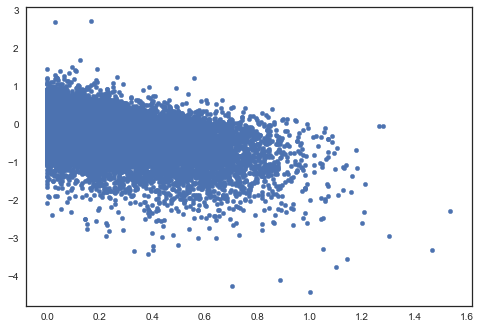

In [16]:
plt.scatter(ALL_PREDS, ALL_ACTUALS, s=20)
stats.linregress(ALL_PREDS, ALL_ACTUALS)[2]**2

In [17]:
r2_dict_bayes

{'lsy6': 0.29077058067936923,
 'mir1': 0.32535288892374975,
 'mir124': 0.26058412646038592,
 'mir137': 0.36870471361695933,
 'mir139': 0.10271764214926242,
 'mir143': 0.2574604918394815,
 'mir144': 0.15564500247645616,
 'mir153': 0.30119349602752693,
 'mir155': 0.23366943870060239,
 'mir182': 0.19757164736313387,
 'mir199a': 0.12989190957126789,
 'mir204': 0.24956236267018989,
 'mir205': 0.14232024703989979,
 'mir216b': 0.29969854454157824,
 'mir223': 0.24031171449870589,
 'mir7': 0.2087437028725464}

In [12]:
r2_dict_bayes

{'lsy6': 0.25484406676495436,
 'mir1': 0.34791883193181489,
 'mir124': 0.24025484791432519,
 'mir137': 0.34294812204097119,
 'mir139': 0.08069003438121676,
 'mir143': 0.23854735054672152,
 'mir144': 0.13000843019056935,
 'mir153': 0.24959216482728833,
 'mir155': 0.27457363133803181,
 'mir182': 0.21225265646978497,
 'mir199a': 0.15671162747653755,
 'mir204': 0.20692552483153545,
 'mir205': 0.11981033052989883,
 'mir216b': 0.24518202223754046,
 'mir223': 0.21664311019237073,
 'mir7': 0.23970586665500734}

In [19]:
r2_dict_bayes

{'lsy6': 0.2779704073467848,
 'mir1': 0.3336660782001406,
 'mir124': 0.18551413461428135,
 'mir137': 0.39427238417608818,
 'mir139': 0.18682667876099371,
 'mir143': 0.31631775732527229,
 'mir144': 0.25742948904102819,
 'mir153': 0.33524363221048498,
 'mir155': 0.28095057644145482,
 'mir182': 0.22265937383079523,
 'mir199a': 0.19824480553344145,
 'mir204': 0.28167011428535321,
 'mir205': 0.23187875611741643,
 'mir216b': 0.36432370692705973,
 'mir223': 0.31409405137325253,
 'mir7': 0.23394416789858469}

In [27]:
r2_dict_bayes

{'lsy6': 0.27051492361142787,
 'mir1': 0.33364197426811759,
 'mir124': 0.26082861309093747,
 'mir137': 0.34235849035002092,
 'mir139': 0.084239593824217709,
 'mir143': 0.24359350571005486,
 'mir144': 0.12697089986133148,
 'mir153': 0.2610839053481972,
 'mir155': 0.28766757443903535,
 'mir182': 0.18634335413826517,
 'mir204': 0.18709238880156545,
 'mir205': 0.11026818270546894,
 'mir216b': 0.27968611877250549,
 'mir223': 0.2185336908835428,
 'mir7': 0.2400478411569}

In [15]:
r2_dict_bayes

{'lsy6': 0.25689283293691612,
 'mir1': 0.33483357796709134,
 'mir124': 0.26069968074535527,
 'mir137': 0.33994106990377582,
 'mir139': 0.072109745480798279,
 'mir143': 0.21105418267135087,
 'mir144': 0.11237819426878844,
 'mir153': 0.23554890554131222,
 'mir155': 0.2551377442966451,
 'mir182': 0.18930941890584527,
 'mir199a': 0.16426622043562994,
 'mir204': 0.19743330978926799,
 'mir205': 0.102414751135345,
 'mir216b': 0.25750967968713984,
 'mir223': 0.21296125586811482,
 'mir7': 0.21925743288257477}

In [118]:
pred_df = pd.DataFrame(ALL_PRED_DICT).set_index(MERGED.index)

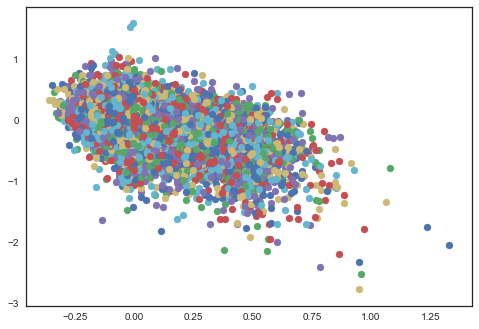

In [124]:
for ix in range(len(MERGED)):
    preds = all_preds_df.iloc[ix][ALL_MIRS].values
    preds -= np.mean(preds)
    actual = all_tpms_df.iloc[ix][ALL_MIRS].values
    actual -= np.mean(actual)
    plt.scatter(preds, actual)

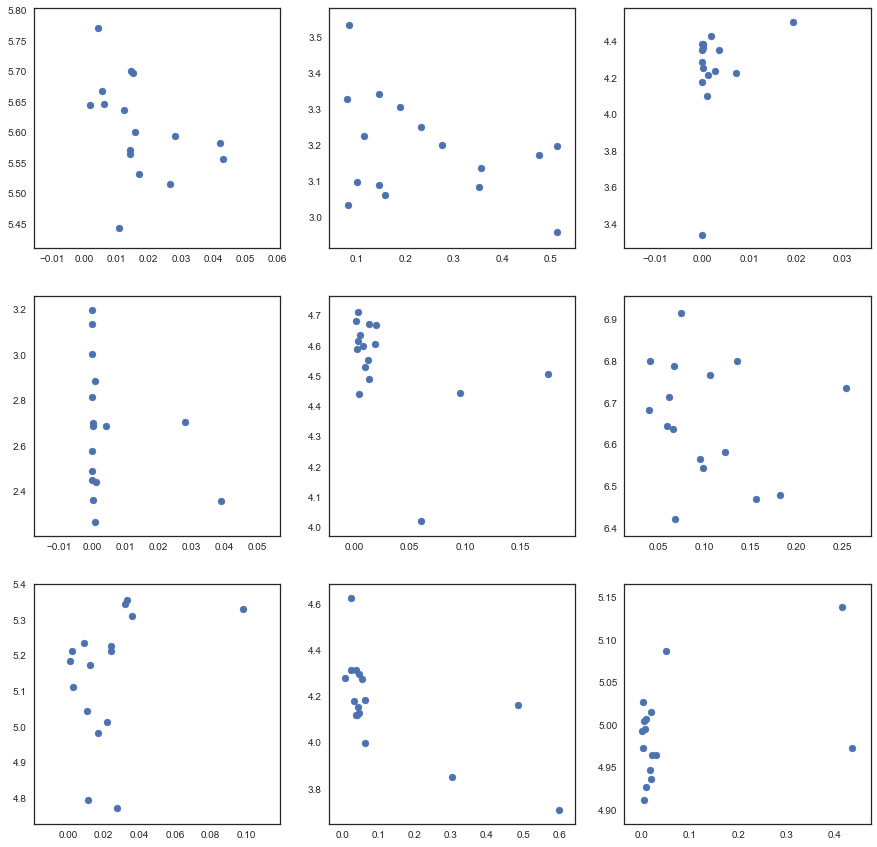

In [122]:
fig = plt.figure(figsize=(15,15))
for ix in range(9):
    ax = plt.subplot(3,3,ix+1)
    preds = all_preds_df.iloc[ix][ALL_MIRS].values
#     preds -= np.mean(preds)
    actual = all_tpms_df.iloc[ix][ALL_MIRS].values
#     actual -= np.mean(actual)
    ax.scatter(preds, actual)

In [ ]:
gene_nosite_dict = {}
for row in MERGED.iterrows():
    utr = row[1]['sequence']
    nosite_mirs = []
    for mir in ALL_MIRS:
        if count_num_canon()

0.27127749761103204

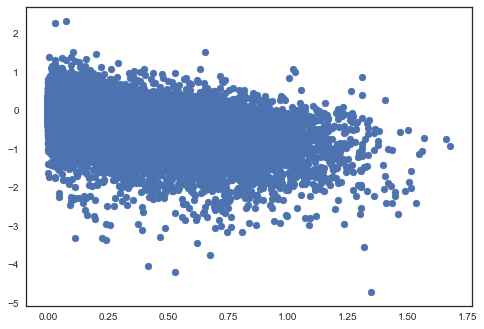

In [105]:
plt.scatter(ALL_PREDS, ALL_ACTUALS)
stats.linregress(ALL_PREDS, ALL_ACTUALS)[2]**2

In [85]:
all_preds_df = pd.DataFrame(all_preds, columns=ALL_MIRS).set_index(MERGED.index)
all_tpms_df = pd.DataFrame(all_tpms, columns=ALL_MIRS).set_index(MERGED.index)

14


0.30608931090396513

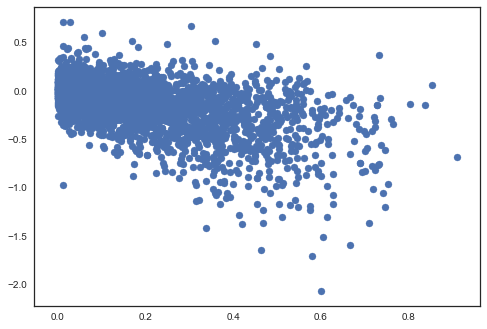

In [87]:
other_mirs = [m for m in ALL_MIRS if m != test_mir]
print(len(other_mirs))
intercept = get_bayes_intercept(all_preds_df[other_mirs].values, all_tpms_df[other_mirs].values, 0, 0.04)
pred = all_preds_df[test_mir].values
actual = all_tpms_df[test_mir] - intercept
plt.scatter(pred, actual)
stats.linregress(pred, actual)[2]**2

4106
mir137 0.330704792475
4106
mir139 0.0562836921848
4106
mir143 0.123522226892
4106
mir144 0.0481155542963
4106
mir153 0.183639882282
4106
mir182 0.159316533566
4106
mir199a 0.102345388601
4106
mir204 0.166941128031
4106
mir205 0.0678941644274
4106
mir216b 0.186866766434
4106
mir223 0.177815180212


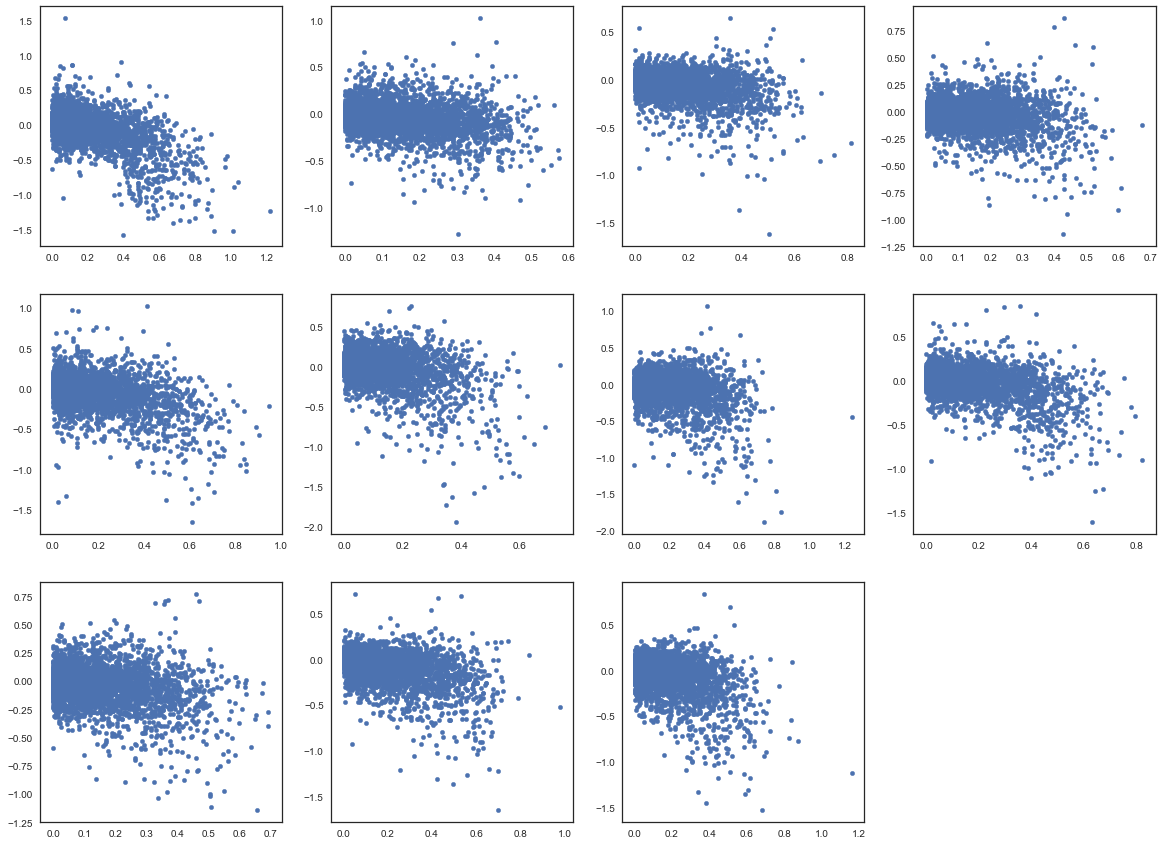

In [10]:
utr_len = MERGED['utr_length'].values
fig = plt.figure(figsize=(20,15))
ix = 1
all_preds = np.zeros([len(MERGED), len(TEST_MIRS)])
all_tpms = np.zeros([len(MERGED), len(TEST_MIRS)])
for ix, mir in enumerate(TEST_MIRS):
    ax = plt.subplot(3,4,ix+1)
    paramfile = pd.read_csv('{}/{}/fitted_params.txt'.format(LOG_DIR, mir), sep='\t', index_col=0, header=None)
    params = {'freeAgo_guide': freeAgo_guide.loc[mir]['mean'],
          'freeAgo_pass': freeAgo_pass.loc[mir]['mean'],
          'utr_coef': paramfile.loc['utr_coef'][1],
          'freeAGO_let7': paramfile.loc['freeAGO_let7'][1],
          'decay': paramfile.loc['decay'][1]}

    with open(os.path.join(PREDICT_DIR, '{}.pickle'.format('none')), 'rb') as infile:
        preds = pickle.load(infile)
        pred_guide = preds[mir]
        kds_guide = -0.1 * np.array(pred_guide['KDs'])
        num_seqs_guide = pred_guide['num_seqs']
        
        pred_pass = preds[mir+'*']
        kds_pass = -0.1 * np.array(pred_pass['KDs'])
        num_seqs_pass = pred_pass['num_seqs']
        
        logfc = get_logfc(kds_guide, num_seqs_guide, kds_pass, num_seqs_pass, LET7_SITES, LET7_MASK, utr_len, params)
        
        temp = MERGED[[mir, 'nosite2']]
        temp['logfc'] = temp[mir] - temp['nosite2']
        temp['pred'] = logfc
        temp = temp.dropna(subset=['logfc'])
        print(len(temp))
        plt.scatter(temp['pred'], temp['logfc'], s=20)
        print(mir, stats.linregress(temp['pred'], temp['logfc'])[2]**2)
        
        all_preds[:, ix] = logfc
        all_tpms[:, ix] = MERGED[mir]

0.24946741278633786

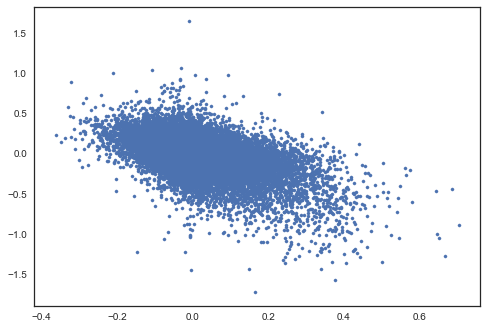

In [51]:
all_preds_normed = all_preds - np.mean(all_preds, axis=1).reshape([-1,1])
all_tpms_normed = all_tpms - np.mean(all_tpms, axis=1).reshape([-1,1])
plt.scatter(all_preds_normed, all_tpms_normed, s=10)
stats.linregress(all_preds_normed.flatten(), all_tpms_normed.flatten())[2]**2

In [2]:
# mir = 'mir139'
# tf.reset_default_graph()
# with tf.Session() as sess:

#     sess.run(tf.global_variables_initializer())
#     latest = tf.train.latest_checkpoint('{}/{}/saved'.format(LOGDIR, mir))
#     print(latest)

#     saver = tf.train.import_meta_graph(latest + '.meta')
#     saver.restore(sess, latest)
    
#     i = 0
#     for op in tf.get_default_graph().get_operations():
#         print(str(op.name))
#         if 'layer3' in str(op.name):
# #             print(str(op.name))
# #         i += 1

In [3]:
# biochem_baselines = pd.read_csv('/lab/bartel4_ata/kathyl/RNA_Seq/analysis/data/final/baselines.txt', sep='\t',index_col=0)
# biochem_baselines.head()

In [4]:
# baselines_all = []
# for mir in test_mirs:
#     temp = pd.read_csv('{}/{}/final_baselines.txt'.format(LOGDIR, mir),
#                             sep='\t',index_col=0)
#     temp.columns=[mir]
#     temp = temp.loc[MERGED.index]
#     baselines_all.append(temp)
# baselines_all = pd.concat(baselines_all, axis=1, join='inner')
# print(len(baselines_all.dropna()))
# vals = baselines_all.values
# baselines_all['mean'], baselines_all['std'] = np.mean(vals, axis=1), np.std(vals, axis=1)
# baselines_all['range'] = np.max(vals, axis=1) - np.min(vals, axis=1)
# print(np.max(baselines_all['range']))

# # baselines_all['method2'] = MERGED.loc[baselines_all.index]['nosite_tpm']
# baselines_all['biochem'] = biochem_baselines.loc[baselines_all.index]['nosite']
# baselines_all['utr_length'] = MERGED.loc[baselines_all.index]['utr_length']
# baselines_all = baselines_all.dropna()
# print(len(baselines_all))
# baselines_all.head()

In [110]:
blah = MERGED.copy()
MERGED['utr_length'] = [np.log10(len(x)) for x in MERGED['Sequence']]

In [91]:
mirs = sorted(list(results['mir'].unique()))
nosite_shuffled = []
for mir, group in results.groupby('mir'):
    group = group.set_index('transcript ID')
#     group = group[group['num_sites_guide'] == 0].set_index('transcript ID')
#     group['pred'] = np.log1p((group['nbound_guide_fitA_nosite'].values + group['nbound_pass_fitA'].values) / np.exp(group['decay'].values)) / np.log(2)
    group['pred'] = np.log1p((group['nbound_guide'].values + group['nbound_pass'].values) / np.exp(group['decay'].values)) / np.log(2)

    other_mirs = [x for x in mirs if x != mir]
    temp = []
    pred_dict = {}
    for omir in other_mirs:
#         print(mir, omir)
        temp_df = results[results['mir'] == omir].set_index('transcript ID')
        temp_df = temp_df.loc[list(group.index)]
#         pred = np.log1p((temp_df['nbound_guide_fitA_nosite'].values + group['nbound_pass_fitA'].values) / np.exp(temp_df['decay'].values)) / np.log(2)
        pred = np.log1p((temp_df['nbound_guide'].values+ group['nbound_pass'].values) / np.exp(temp_df['decay'].values)) / np.log(2)

        r2 = stats.linregress(pred, group['log2fc'])[2]**2
        temp.append([omir, r2])
        pred_dict[omir] = pred
        
#         plt.scatter(group['nbound_guide'].values, temp_df['nbound_guide'].values)
#         break
#     break
        
    temp = pd.DataFrame(temp).sort_values(1)
    group['shuffled_nosite_pred'] = pred_dict[temp.iloc[5][0]]
    
    nosite_shuffled.append(group.reset_index())
        
nosite_shuffled = pd.concat(nosite_shuffled)
nosite_shuffled.head()

transcript ID     decay    log2fc     mir  nbound_guide  nbound_guide_fitA  \
0     NM_000019  0.330384 -0.290411  mir137      0.007237           0.012476   
1     NM_000031  0.330384 -0.348400  mir137      0.264456           0.454019   
2     NM_000046  0.330384 -0.227147  mir137      0.005999           0.010351   
3     NM_000064  0.330384 -0.459964  mir137      0.000000           0.000000   
4     NM_000086  0.330384 -0.200661  mir137      0.006278           0.010831   

   nbound_guide_fitA_nosite  nbound_guide_nosite  nbound_pass  \
0                  0.012476             0.007237     0.000000   
1                  0.380027             0.220380     0.010717   
2                  0.010351             0.005999     0.000000   
3                  0.000000             0.000000     0.000000   
4                  0.010831             0.006278     0.000520   

   nbound_pass_fitA  nbound_pass_fitA_nosite  nbound_pass_nosite  \
0          0.000000                 0.000000            0.000000   
1          0.004079                 0.004079            0.010717   
2          0.000000                 0.000000            0.000000   
3          0.000000                 0.000000            0.000000   
4          0.000198                 0.000198            0.000520   

   num_sites_guide  num_sites_pass      pred  shuffled_nosite_pred  
0                0               0  0.007484              0.082287  
1                1               0  0.260330              0.255112  
2                0               0  0.006206              0.000000  
3                0               0  0.000000              0.000000  
4                0               0  0.007031              0.040310

0.336088173332
0.297258175396


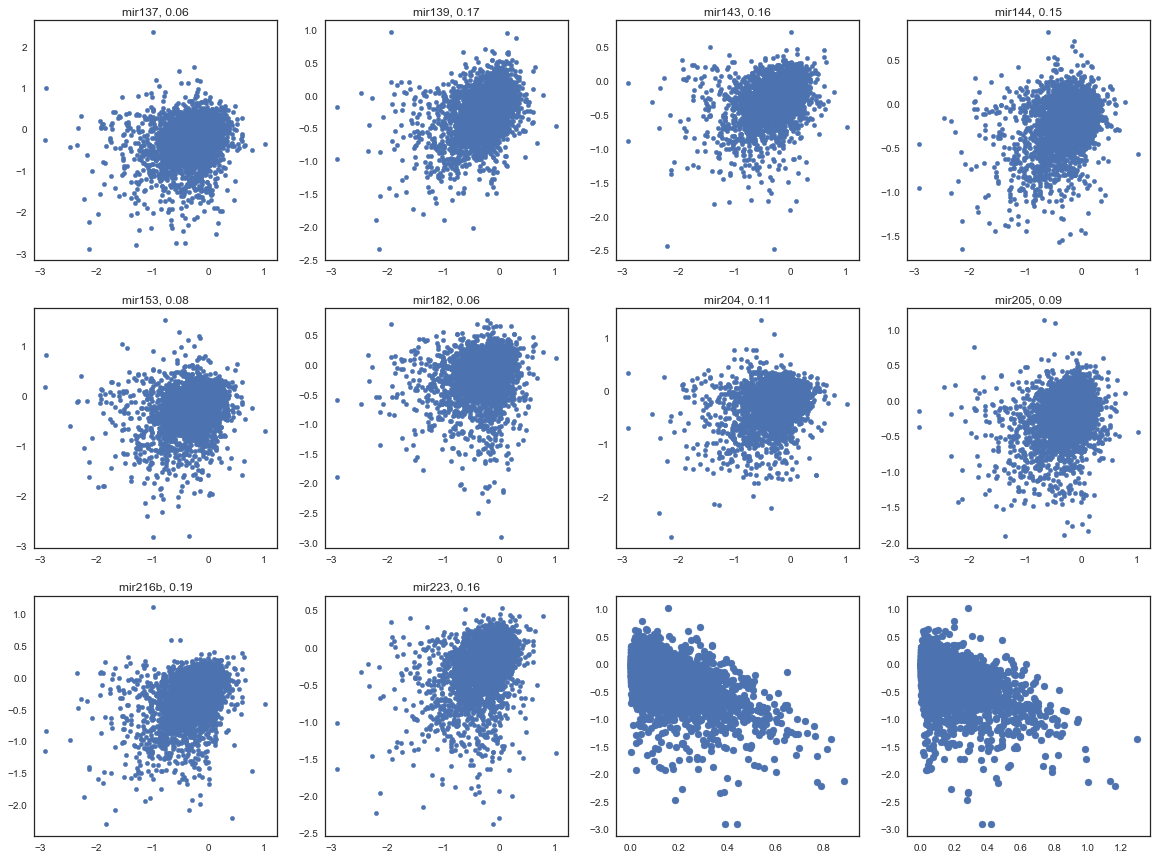

In [154]:
temp1 = nosite_shuffled[nosite_shuffled['mir'] == 'mir199a'].set_index('transcript ID')
omirs = [x for x in mirs if x != 'mir199a']
fig = plt.figure(figsize=(20,15))
for ix, omir in enumerate(omirs):
    ax = plt.subplot(3,4,ix+1)
    temp2 = nosite_shuffled[nosite_shuffled['mir'] == omir].set_index('transcript ID').loc[temp1.index]
    
    plt.scatter(temp1['log2fc'], temp2['log2fc'], s=20)
    r2 = stats.linregress(temp1['log2fc'], temp2['log2fc'])[2]**2
    plt.title('{}, {:.2f}'.format(omir, r2))
    
ax = plt.subplot(3,4,11)
plt.scatter(temp1['pred'], temp1['log2fc'])
print(stats.linregress(temp1['pred'], temp1['log2fc'])[2]**2)

ax = plt.subplot(3,4,12)
plt.scatter(temp2['pred'], temp1['log2fc'])
print(stats.linregress(temp2['pred'], temp1['log2fc'])[2]**2)
# utr_lengths = MERGED.loc[temp1.index]['utr_length']
# plt.scatter(utr_lengths, temp1['log2fc'])
# print(stats.linregress(utr_lengths, temp1['log2fc'])[2]**2)

In [83]:
print(stats.linregress(nosite_shuffled['pred'], nosite_shuffled['log2fc'])[2]**2)
print(stats.linregress(nosite_shuffled['shuffled_nosite_pred'], nosite_shuffled['log2fc'])[2]**2)

0.330017741398
0.328931400412


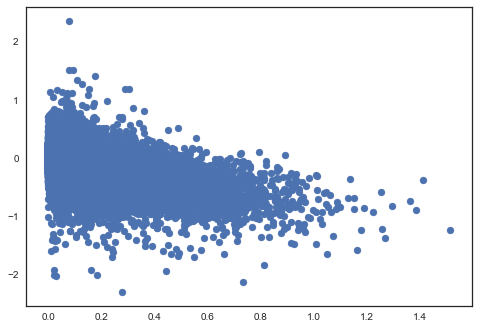

In [63]:
plt.scatter(nosite_shuffled['pred'], nosite_shuffled['log2fc'])

0.20057026218948246

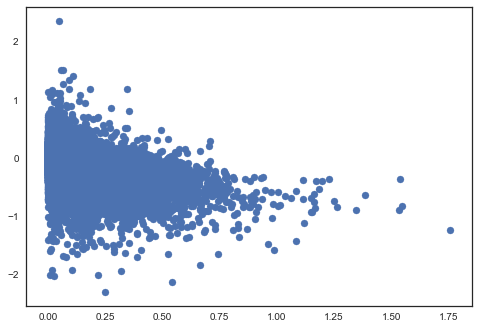

In [52]:
temp = results[results['num_sites_guide'] == 0]
temp['pred'] = ((temp['nbound_guide_nosite'] + temp['nbound_pass']) / np.exp(temp['decay'])) / np.log(2)
plt.scatter(temp['pred'], temp['log2fc'])
stats.linregress(temp['pred'], temp['log2fc'])[2]**2

In [14]:
def one_hot_encode_nt_new(seq, nt_order):
    """Convert RNA sequence to one-hot encoding"""
    
    one_hot = np.zeros([len(seq) * 4])
    for i, nt in enumerate(seq):
        one_hot[i*4 + np.argmax(nt_order == nt)] = 2.0
    
    return one_hot

def remove_overlaps(locs, distance=6):
    if len(locs) < 2:
        return locs

    diffs = np.diff(locs)
    while np.min(diffs) < distance:
        overlap = np.argmax(diffs < distance)
        keep_which = np.random.randint(2)
        del locs[overlap + keep_which]

        if len(locs) == 1:
            break

        diffs = np.diff(locs)

    return locs

def get_seqs(utr, site, seqlen=12):
    utr_len = len(utr)
    utr_ext = utr + 'TTT'

    locs1 = remove_overlaps([m.start() - 1 for m in re.finditer(site[3:], utr)])
    locs2 = remove_overlaps([(m.start()) for m in re.finditer(site[2:-1], utr)])
    locs3 = remove_overlaps([(m.start() + 1) for m in re.finditer(site[1:-2], utr)])
    locs4 = remove_overlaps([(m.start() + 2) for m in re.finditer(site[:-3], utr)])
    # locs = sorted(list(set(locs1 + locs2 + locs3 + locs4)))

    locs = np.array(locs1 + locs2 + locs3 + locs4)

    if len(locs) == 0:
        return []
    elif len(locs) == 1:
        real_locs = locs
    else:
        real_locs = [locs[0]]
        for i, l in enumerate(locs[1:]):
            if min([abs(l - rl) for rl in real_locs]) >= 6:
                real_locs.append(l)

    if seqlen == 16:
        seqs = [utr_ext[loc-6:loc+10] for loc in real_locs if (loc-6 >=0) and (loc+5 <= utr_len)]
    else:
        seqs = [utr_ext[loc-4:loc+8] for loc in real_locs if (loc-4 >=0) and (loc+5 <= utr_len)]

    return seqs

def get_features(mir, utrs, mirlen, seqlen, only_canon=False):
    all_seqs = []
    mirseq = config.MIR_TO_MIRSEQ[mir]
    site = helpers.rev_comp(mirseq[1:8])
    num_total_seqs = 0
    for utr in utrs:
        seqs = get_seqs(utr, site, only_canon)
        all_seqs.append(seqs)
        num_total_seqs += len(seqs)

    combined_x = np.zeros([num_total_seqs, 4*mirlen, 4*seqlen])
    seq_utr_boundaries = [0]
    
    mirseq_one_hot = one_hot_encode_nt_new(mirseq[:mirlen][::-1], MIR_NTS)
    current_ix = 0
    for seq_list in all_seqs:

        if len(seq_list) == 0:
            seq_utr_boundaries.append(current_ix)

        else:
            for seq in seq_list:
                temp = np.outer(mirseq_one_hot, one_hot_encode_nt_new(seq, SEQ_NTS))
                combined_x[current_ix, :, :] = temp - 0.25
                current_ix += 1

            seq_utr_boundaries.append(current_ix)
    
    combined_x = np.expand_dims(combined_x, 3)
    
    return combined_x, seq_utr_boundaries

def calc_nbound(pred_ind, freeAgo, seq_utr_boundaries):
    pred_ind_nbound = 1.0 / (1.0 + np.exp((-1.0 * pred_ind.flatten()) - freeAgo))
    pred_nbound = []
    prev = seq_utr_boundaries[0]
    for bound in seq_utr_boundaries[1:]:
        pred_nbound.append(np.sum(pred_ind_nbound[prev:bound]))
        prev = bound
        
    return np.array(pred_nbound)

def mean_7m8_repression(mir, utrs, logfcs):
    site = helpers.rev_comp(config.SEED_DICT[mir])
    site_star = helpers.rev_comp(config.SEED_DICT[mir + '*'])
    
    rep1, rep2 = [], []
    for utr, logfc in zip(utrs, logfcs):
        if (site in utr) and (site_star[1:] not in utr):
            rep1.append(logfc)
        elif (site[1:] not in utr) and (site_star in utr):
            rep2.append(logfc)
            
    return rep1, rep2

In [6]:
# def get_seqs(utr, site, seqlen=12):
#     utr_len = len(utr)
#     utr_ext = utr + 'UUUUU'

#     locs1 = [m.start() - 1 for m in re.finditer(site[3:], utr)]
#     locs2 = [(m.start()) for m in re.finditer(site[2:-1], utr)]
#     locs3 = [(m.start() + 1) for m in re.finditer(site[1:-2], utr)]
#     locs4 = [(m.start() + 2) for m in re.finditer(site[:-3], utr)]
#     locs = list(set(locs1 + locs2 + locs3 + locs4))

#     if seqlen == 16:
#         seqs = [utr_ext[loc-6:loc+10] for loc in locs if (loc-6 >=0) and (loc+5 <= utr_len)]
#     else:
#         seqs = [utr_ext[loc-4:loc+8] for loc in locs if (loc-4 >=0) and (loc+5 <= utr_len)]

#     return seqs

In [6]:
def calc_rsquared(pred, actual):
    SS_err = np.sum((pred-actual)**2)
    SS_tot = np.sum((actual - np.mean(actual))**2)
    
    return 1.0 - (SS_err / SS_tot)

In [7]:
MIR_NTS = np.array(['A','T','C','G'])
SEQ_NTS = np.array(['T','A','G','C'])

# MERGED = pd.read_csv('/lab/bartel4_ata/kathyl/NeuralNet/data/tpm_and_kds/tpms.txt',sep='\t',index_col=0)
MERGED = pd.read_csv('data/final/merged.txt',sep='\t',index_col=0)
print(len(MERGED))
MERGED.head()

4257


let7      lsy6      mir1    mir124    mir137    mir139  \
NM_000019  5.489954  5.556579  5.594846  5.667604  5.443084  5.515518   
NM_000031  3.239114  3.084620  3.172362  3.136734  3.197488  3.033614   
NM_000046  4.269395  4.428908  4.257793  4.507880  4.104727  4.383145   
NM_000064  2.593084  2.492165  2.359499  2.452043  2.363082  2.702271   
NM_000086  4.321064  4.683765  4.445265  4.508249  4.442536  4.605449   

             mir143    mir144    mir153    mir155    mir182   mir199a  \
NM_000019  5.637737  5.583482  5.571378  5.698193  5.770993  5.645126   
NM_000031  3.328216  3.343367  3.098716  3.306433  3.224933  3.249728   
NM_000046  4.218683  4.354400  4.363985  4.387927  4.387286  4.237242   
NM_000064  2.705830  2.578861  3.195765  2.267545  3.137076  2.689569   
NM_000086  4.531659  4.489207  4.589071  4.553561  4.601348  4.635763   

             mir204    mir205   mir216b    mir223      mir7    nosite  \
NM_000019  5.564655  5.531693  5.600745  5.646672  5.700714  5.604722   
NM_000031  3.060618  2.958424  3.090206  3.199322  3.535507  3.283665   
NM_000046  4.353438  4.226574  4.176859  4.288725  3.343310  4.252369   
NM_000064  2.886982  3.004277  2.442833  2.816632  2.687569  2.688474   
NM_000086  4.673705  4.668179  4.713798  4.614829  4.022774  4.568839   

                                                    sequence  orf_length  \
NM_000019  ACAACCTCTGCTATTTAAGGAGACAACCCTATGTGACCAGAAGGCC...        1281   
NM_000031  TGGAGACAGTGCCAGGCCCAAGAACTAGAACTTTAAAACGTTCCCG...         990   
NM_000046  GATTTCAGGGAGGCTAGAAAACCTTTCAATTGGAAGTTGGACCTCA...        1599   
NM_000064     CCACACCCCCATTCCCCCACTCCAGATAAAGCTTCAGTTATATCTC        4989   
NM_000086  TACTCGGGATCCTCAGGACGCAGGTCACATTCACCTGTGGGCAGAG...        1314   

           utr_length  
NM_000019         209  
NM_000031        1987  
NM_000046          53  
NM_000064          46  
NM_000086         236

In [8]:
# KDS = pd.read_csv('/lab/bartel4_ata/kathyl/NeuralNet/data/tpm_and_kds/kds.txt',sep='\t')
KDS = pd.read_csv('data/final/kds.txt',sep='\t')
KDS.head()

12mer    log_kd   mir                  mirseq    stype
0  AAAAAATCCAAA -0.810633  mir1  TGGAATGTAAAGAAGTATGTAT  no site
1  AAAAAATCCAAC -1.805606  mir1  TGGAATGTAAAGAAGTATGTAT  no site
2  AAAAAATCCAAG -0.287849  mir1  TGGAATGTAAAGAAGTATGTAT  no site
3  AAAAAATCCAAT -0.206237  mir1  TGGAATGTAAAGAAGTATGTAT  no site
4  AAAAAATCCACA -1.096425  mir1  TGGAATGTAAAGAAGTATGTAT  no site

In [9]:
xs_dict = {}
ys_dict = {}
for mir, group in KDS.groupby('mir'):

    xs = np.zeros([len(group), 48, 48])
    for i, row in enumerate(group.iterrows()):
        mirseq = row[1]['mirseq'][:12][::-1]
        mirseq_one_hot = one_hot_encode_nt_new(mirseq, MIR_NTS)
        seq_one_hot = one_hot_encode_nt_new(row[1]['12mer'], SEQ_NTS)
        xs[i,:,:] = np.outer(mirseq_one_hot, seq_one_hot) - 0.25
        
        
    xs_dict[mir] = xs
    ys_dict[mir] = group['log_kd'].values
    

In [5]:
prefix = '/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/'

# LOGDIR = prefix + 'run_pass_fit_baseline_no_pretrain_fixed_slope_4_8_16_epochs50'
# LOGDIR = prefix + 'run_pass_fit_baseline_no_pretrain_fixed_slope_log1p_4_8_16'
# LOGDIR = prefix + 'run_pass_fit_baseline_no_pretrain_fit_decay_log1p_4_8_16_epoch50' # lab meeting
# LOGDIR = prefix + 'run_pass_fit_baseline_pretrain_fit_decay_log1p_4_8_16_epoch50'
# LOGDIR = prefix + 'run_pass_fit_baseline_no_pretrain_fit_decay_log1p_4_8_32_epoch50'
# LOGDIR = prefix + 'run_pass_fit_baseline_no_pretrain_fit_slope_4_16_16_32_epoch50'
# LOGDIR = prefix + 'run_pass_fit_baseline_no_pretrain_no_offset_fit_slope_4_16_16_32_epoch50'
# LOGDIR = prefix + 'run_pass_fit_baseline_pretrain_fit_decay_rbns_log1p_4_8_16_epoch50'
# LOGDIR = prefix + 'run_pass_no_pretrain_no_offset_fit_slope_4_16_16_32_epoch50'
# LOGDIR = prefix + 'run_pass_fixed_baseline_fixed_decay_epoch50'
LOGDIR = prefix + 'endog_pretrain_noreset_xval'

/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/endog_pretrain_noreset_xval/mir1/saved/model-50
INFO:tensorflow:Restoring parameters from /lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/endog_pretrain_noreset_xval/mir1/saved/model-50
/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/endog_pretrain_noreset_xval/mir124/saved/model-50
INFO:tensorflow:Restoring parameters from /lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/endog_pretrain_noreset_xval/mir124/saved/model-50
/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/endog_pretrain_noreset_xval/mir155/saved/model-50
INFO:tensorflow:Restoring parameters from /lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/endog_pretrain_noreset_xval/mir155/saved/model-50
/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/endog_pretrain_noreset_xval/mir7/saved/model-50
INFO:tensorflow:Restoring parameters from /lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/endog_pretrain_noreset_xval/mir7/saved/model-50


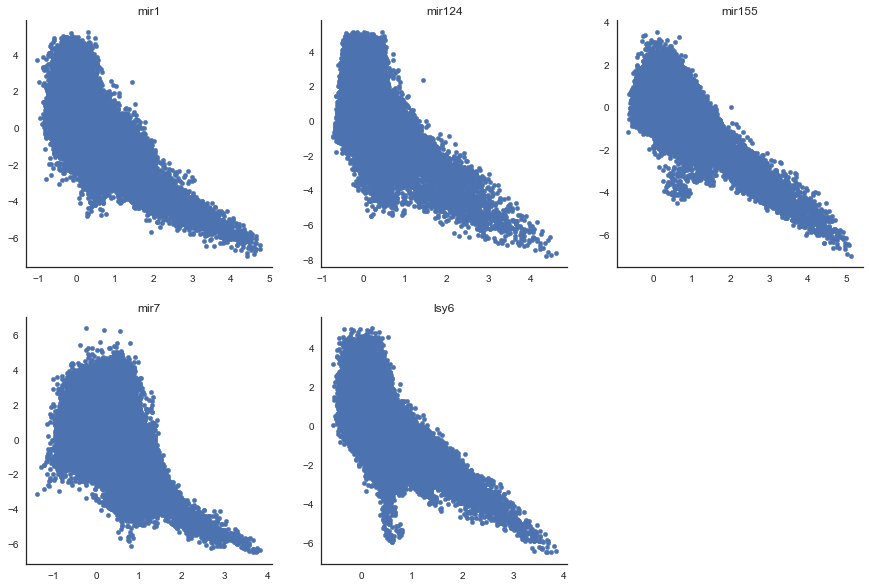

In [11]:
kd_mirs = list(KDS['mir'].unique())
pred_dict = {}
fig = plt.figure(figsize=(15,10))
for ix, mir in enumerate(kd_mirs):
    if mir == 'let7':
        continue
    ax = plt.subplot(2,3,ix+1)
    tf.reset_default_graph()
    with tf.Session() as sess:

        sess.run(tf.global_variables_initializer())
        latest = tf.train.latest_checkpoint('{}/{}/saved'.format(LOGDIR, mir))

        saver = tf.train.import_meta_graph(latest + '.meta')
        saver.restore(sess, latest)

        _keep_prob = tf.get_default_graph().get_tensor_by_name('keep_prob:0')
        _phase_train = tf.get_default_graph().get_tensor_by_name('phase_train:0')
        _combined_x = tf.get_default_graph().get_tensor_by_name('biochem_x:0')
        _prediction = tf.get_default_graph().get_tensor_by_name('final_layer/add:0') * 10

        # get nbound from guide strand
        combined_x = np.expand_dims(xs_dict[mir], 3)
        feed_dict = {_keep_prob: 1.0,
                     _phase_train: False,
                     _combined_x:combined_x}

        pred_guide = sess.run(_prediction, feed_dict=feed_dict)
        pred_dict[mir] = pred_guide

        ax.scatter(pred_guide, ys_dict[mir], s=20)

        ax.set_title(mir)
#         ax.set_title(r'{}, $r^2={:.3}, R^2={:.3}$'.format(mir, r2, r2_real))
#         ax.set_ylim(-3.0, 1.5)
#         ax.set_xlim(-0.2, 3)
        sns.despine()
#         break

In [ ]:
stype_dict = {}

for mir in ALL_MIRS:
    xs = np.zeros([len(group), 48, 48])
    for i, row in enumerate(group.iterrows()):
        mirseq = row[1]['mirseq'][:12][::-1]
        mirseq_one_hot = one_hot_encode_nt_new(mirseq, MIR_NTS)
        seq_one_hot = one_hot_encode_nt_new(row[1]['12mer'], SEQ_NTS)
        xs[i,:,:] = np.outer(mirseq_one_hot, seq_one_hot) - 0.25
        
        
    xs_dict[mir] = xs
    ys_dict[mir] = group['log kd'].values

In [15]:
features_dict = {}
ALL_MIRS = ['mir1','mir124','mir155','lsy6','mir7','mir153',
            'mir139','mir204','mir216b','mir223','mir137',
            'mir199a','mir205','mir182','mir143','mir144']

UTRS = MERGED['sequence'].values

for mir in ALL_MIRS:
    print(mir)
    features_dict[mir] = get_features(mir, UTRS, 12, 12)
    features_dict[mir+'*'] = get_features(mir + '*', UTRS, 12, 12)

mir1
mir124
mir155
lsy6
mir7
mir153
mir139
mir204
mir216b
mir223
mir137
mir199a
mir205
mir182
mir143
mir144


In [16]:
test_mirs = sorted(['mir153','mir139','mir144','mir223','mir137',
             'mir205','mir143','mir182','mir199a','mir204','mir216b'])

# test_mirs = sorted(['mir153','mir144','mir223','mir137',
#              'mir143','mir182','mir199a','mir204','mir216b'])

In [35]:
# canon_features_dict = {}

# UTRS = MERGED['Sequence'].values

# for mir in test_mirs:
#     canon_features_dict[mir] = get_features(mir, UTRS, 12, 12, only_canon=True)
#     canon_features_dict[mir+'*'] = get_features(mir + '*', UTRS, 12, 12, only_canon=True)

In [17]:
# freeAgo_guide, freeAgo_pass = [], []
# for tm in test_mirs:
#     temp = pd.read_csv('{}/{}/freeAGO_final.txt'.format(LOGDIR, tm), sep='\t').set_index('mir')
#     freeAgo_guide.append(temp[['guide']].rename(columns={'guide': tm}))
#     freeAgo_pass.append(temp[['passenger']].rename(columns={'passenger': tm}))

# freeAgo_guide = pd.concat(freeAgo_guide, axis=1, join='outer')
# freeAgo_pass = pd.concat(freeAgo_pass, axis=1, join='outer')
# vals = freeAgo_guide.values
# freeAgo_guide['mean'], freeAgo_guide['std'] = np.nanmean(vals, axis=1), np.nanstd(vals, axis=1)
# vals = freeAgo_pass.values
# freeAgo_pass['mean'], freeAgo_pass['std'] = np.nanmean(vals, axis=1), np.nanstd(vals, axis=1)
# freeAgo_guide

In [18]:
# freeAgo_pass

In [14]:
# tf.reset_default_graph()
# with tf.Session() as sess:

#     sess.run(tf.global_variables_initializer())
#     latest = tf.train.latest_checkpoint('{}/none/saved'.format(LOGDIR))
#     print(latest)
#     saver = tf.train.import_meta_graph(latest + '.meta')
#     saver.restore(sess, latest)

#     i = 0
#     for op in tf.get_default_graph().get_operations():
#         if 'layer3' in str(op.name):
#             print(str(op.name))
#         i += 1

In [10]:
tf.reset_default_graph()
with tf.Session() as sess:

    sess.run(tf.global_variables_initializer())
    latest = tf.train.latest_checkpoint('{}/none/saved'.format(LOGDIR))
    print(latest)
    saver = tf.train.import_meta_graph(latest + '.meta')
    saver.restore(sess, latest)
    
    w3 = tf.get_default_graph().get_tensor_by_name('layer3_weight:0')
    w4 = tf.get_default_graph().get_tensor_by_name('final_layer_weight:0')

    conv_weights, final_layer = sess.run([w3, w4])

/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/run_pass_fit_baseline_pretrain_fit_decay_log1p_4_8_16_epoch50/none/saved/model-50
INFO:tensorflow:Restoring parameters from /lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/run_pass_fit_baseline_pretrain_fit_decay_log1p_4_8_16_epoch50/none/saved/model-50


In [11]:
final_layer, final_layer.reshape([1,1,16])

(array([[ 0.18552144],
        [-0.15326017],
        [ 0.18642178],
        [ 0.18656643],
        [ 0.19605666],
        [ 0.16368793],
        [ 0.17385277],
        [ 0.17380415],
        [ 0.14355737],
        [-0.1721302 ],
        [-0.1516051 ],
        [ 0.18189064],
        [ 0.18274558],
        [ 0.18240127],
        [-0.16220814],
        [ 0.1752139 ]], dtype=float32),
 array([[[ 0.18552144, -0.15326017,  0.18642178,  0.18656643,  0.19605666,
           0.16368793,  0.17385277,  0.17380415,  0.14355737, -0.1721302 ,
          -0.1516051 ,  0.18189064,  0.18274558,  0.18240127, -0.16220814,
           0.1752139 ]]], dtype=float32))

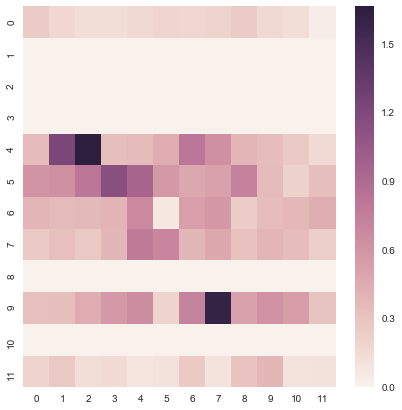

In [12]:
fig = plt.figure(figsize=(7,7))
importance = np.sum(np.multiply(np.abs(np.sum(conv_weights, axis=2)), np.abs(final_layer.reshape([1,1,16]))), axis=2)
sns.heatmap(importance)

In [10]:
baselines_all = []
for mir in test_mirs:
    temp = pd.read_csv('{}/{}/final_baselines.txt'.format(LOGDIR, mir),
                            sep='\t',index_col=0)[['nosite_tpm']]
    temp.columns=[mir]
    temp = temp.loc[MERGED.index]
    baselines_all.append(temp)
baselines_all = pd.concat(baselines_all, axis=1, join='inner')
print(len(baselines_all.dropna()))
vals = baselines_all.values
baselines_all['mean'], baselines_all['std'] = np.mean(vals, axis=1), np.std(vals, axis=1)
baselines_all['range'] = np.max(vals, axis=1) - np.min(vals, axis=1)
print(np.max(baselines_all['range']))

baselines_all.head()

4212
0.309346199036


mir137    mir139    mir143    mir144    mir153    mir182  \
NM_000019  5.635549  5.632636  5.622246  5.623924  5.626714  5.617181   
NM_000031  3.458570  3.504870  3.484905  3.464969  3.467371  3.468599   
NM_000046  4.265730  4.247689  4.258048  4.249497  4.248892  4.247129   
NM_000064  2.756045  2.735806  2.736220  2.743565  2.707217  2.708175   
NM_000086  4.541636  4.524763  4.536856  4.536980  4.525554  4.532123   

            mir199a    mir204    mir205   mir216b    mir223      mean  \
NM_000019  5.624398  5.627616  5.631437  5.625096  5.622249  5.626277   
NM_000031  3.496791  3.513384  3.515461  3.486477  3.483024  3.485857   
NM_000046  4.257206  4.249051  4.257401  4.261041  4.253210  4.254081   
NM_000064  2.736574  2.724933  2.715756  2.749656  2.730072  2.731274   
NM_000086  4.528368  4.518895  4.517748  4.521470  4.528334  4.528430   

                std     range  
NM_000019  0.005051  0.018368  
NM_000031  0.018938  0.056891  
NM_000046  0.005907  0.018600  
NM_000064  0.015286  0.048828  
NM_000086  0.007430  0.023888

In [31]:
# log_tpm_normed = pd.read_csv('/lab/bartel4_ata/kathyl/NeuralNet/data/tpm_and_kds/log_tpm_normed.txt',
#                              sep='\t', index_col=0)
# fig = plt.figure(figsize=(20,20))
# for i, mir in enumerate(test_mirs):
#     rep1 = log_tpm_normed['{}_rep1 tpm'.format(mir)] - baselines_all['mean']
#     rep2 = log_tpm_normed['{}_rep2 tpm'.format(mir)] - baselines_all['mean']
    
#     ax = plt.subplot(4,4,i+1)
#     ax.scatter(rep1 / np.log(2), rep2 / np.log(2), s=20)
#     r2 = stats.linregress(rep1, rep2)[2]**2
#     ax.set_title('{}, R2={:.3}'.format(mir, r2))
#     ax.set_xlim(-3.5,1.5)
#     ax.set_ylim(-3.5,1.5)

mir137 -0.69813237574 -0.0944918864017 -0.603640489339
1.5385081768
mir139 -0.33155814061 nan nan
-0.340086984634
mir143 -0.383426697819 -0.204794659256 -0.178632038563
1.65396857262
mir144 nan -0.215448124961 nan
0.420030593872
mir153 -0.427866958461 nan nan
0.649898433685
mir182 -0.351779312393 -0.318959718496 -0.0328195938975
0.937918710709
mir199a -0.371322960099 -0.266373122278 -0.104949837822
0.59191198349
mir204 -0.395973707218 -0.192941475599 -0.203032231619
0.0297126293182
mir205 -0.399018445024 -0.151580027281 -0.247438417743
0.0510915756226
mir216b -0.403134523623 -0.345348754297 -0.0577857693261
0.403318357468
mir223 -0.48750549237 -0.234419312972 -0.253086179398
2.3406730175


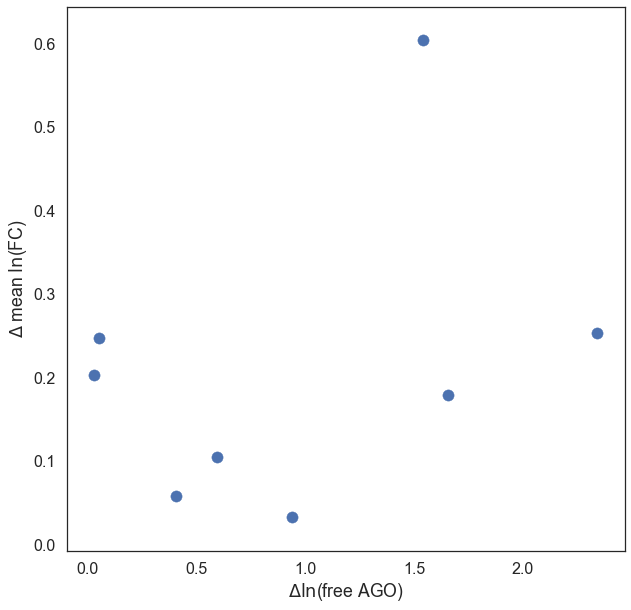

In [19]:
utrs = list(MERGED['Sequence'])
freeago_diffs = []
rep_diffs = []
for mir in test_mirs:
    logfcs = list(MERGED[mir] - baselines_all['mean'])
    rep1, rep2 = mean_7m8_repression(mir, utrs, logfcs)
    print(mir, np.mean(rep1), np.mean(rep2), np.mean(rep1) - np.mean(rep2))
    print(freeAgo_guide.loc[mir]['mean'] - freeAgo_pass.loc[mir]['mean'])
    rep_diffs.append(np.mean(rep2) - np.mean(rep1))
    freeago_diffs.append(freeAgo_guide.loc[mir]['mean'] - freeAgo_pass.loc[mir]['mean'])

fig = plt.figure(figsize=(10,10))
sns.set_context('poster')
plt.scatter(freeago_diffs, rep_diffs)
plt.xlabel(r'$\Delta \ln$(free AGO)')
plt.ylabel(r'$\Delta$ mean $\ln$(FC)')

In [11]:
len(MERGED), len(baselines_all)

(4212, 4212)

In [12]:
results_dict = {}
logfc_dict = {}
for ix, mir in enumerate(test_mirs):
    baselines = pd.read_csv('{}/{}/final_baselines.txt'.format(LOGDIR, mir),sep='\t',index_col=0)
    baselines = baselines.loc[MERGED.index]
    tf.reset_default_graph()
    with tf.Session() as sess:

        sess.run(tf.global_variables_initializer())
        latest = tf.train.latest_checkpoint('{}/{}/saved'.format(LOGDIR, mir))
        print(latest)

        saver = tf.train.import_meta_graph(latest + '.meta')
        saver.restore(sess, latest)

        _keep_prob = tf.get_default_graph().get_tensor_by_name('keep_prob:0')
        _phase_train = tf.get_default_graph().get_tensor_by_name('phase_train:0')
        _combined_x = tf.get_default_graph().get_tensor_by_name('biochem_x:0')
#         _slope = tf.get_default_graph().get_tensor_by_name('slope:0')
        _prediction = tf.get_default_graph().get_tensor_by_name('final_layer/add:0')
        _decay = tf.get_default_graph().get_tensor_by_name('decay:0')
        
        decay = sess.run(_decay)
#         slope = sess.run(_slope)

        # get nbound from guide strand
        combined_x, seq_utr_boundaries_guide = features_dict[mir]
        feed_dict = {_keep_prob: 1.0,
                     _phase_train: False,
                     _combined_x:combined_x}

        pred_guide = sess.run(_prediction, feed_dict=feed_dict) * 4

        combined_x, seq_utr_boundaries_pass = features_dict[mir + '*']
        feed_dict = {_keep_prob: 1.0,
                     _phase_train: False,
                     _combined_x:combined_x}

        pred_pass = sess.run(_prediction, feed_dict=feed_dict) * 4
        
        results_dict[mir] = (pred_guide, pred_pass, decay)

        logfc = (MERGED[mir] - baselines['nosite_tpm'])
        logfc_dict[mir] = logfc


/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/run_pass_fit_baseline_no_pretrain_fit_decay_log1p_4_8_16_epoch50/mir137/saved/model-50
INFO:tensorflow:Restoring parameters from /lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/run_pass_fit_baseline_no_pretrain_fit_decay_log1p_4_8_16_epoch50/mir137/saved/model-50
/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/run_pass_fit_baseline_no_pretrain_fit_decay_log1p_4_8_16_epoch50/mir139/saved/model-50
INFO:tensorflow:Restoring parameters from /lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/run_pass_fit_baseline_no_pretrain_fit_decay_log1p_4_8_16_epoch50/mir139/saved/model-50
/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/run_pass_fit_baseline_no_pretrain_fit_decay_log1p_4_8_16_epoch50/mir143/saved/model-50
INFO:tensorflow:Restoring parameters from /lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/run_pass_fit_baseline_no_pretrain_fit_decay_log1p_4_8_16_epoch50/mir143/saved/model-50
/lab/bartel4_ata/kathy

2.22211


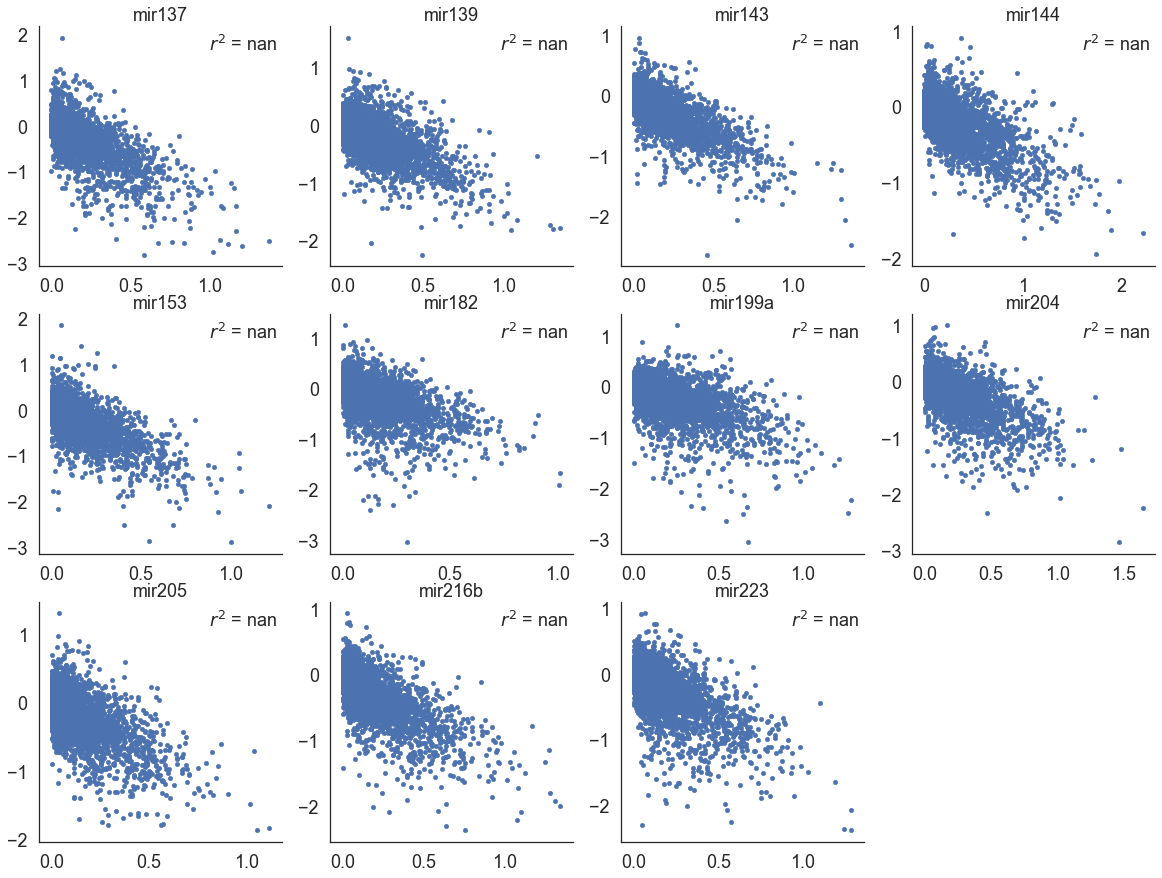

In [21]:
pred_df = []
fig = plt.figure(figsize=(20,15))
for ix, mir in enumerate(test_mirs):
    
    results = results_dict[mir]
    
    nbound_guide_fitA = calc_nbound(results[0], freeAgo_guide.loc[mir]['mean'], features_dict[mir][1])
    nbound_pass_fitA = calc_nbound(results[1], freeAgo_pass.loc[mir]['mean'], features_dict[mir + '*'][1])
    
    nbound_guide = calc_nbound(results[0], np.nanmean(freeAgo_guide[mir].values), features_dict[mir][1])
    nbound_pass = calc_nbound(results[1], np.nanmean(freeAgo_pass[mir].values), features_dict[mir + '*'][1])

    nbound_fitA = nbound_guide_fitA + nbound_pass_fitA
    nbound = nbound_guide + nbound_pass

    pred_log2fc_fitA = np.log1p(nbound_fitA / np.exp(results[2])) / np.log(2)
    pred_log2fc = np.log1p(nbound / np.exp(results[2])) / np.log(2)
#     pred_logfc = nbound * results[2]
    log2fc = logfc_dict[mir] / np.log(2)
    
    temp_df = pd.DataFrame({'mir': mir,
                            'transcript ID': MERGED.index,
                            'pred_fitA': pred_log2fc_fitA,
                            'pred': pred_log2fc,
                            'log2fc': log2fc
                           })
    
    pred_df.append(temp_df)
    
    ax = plt.subplot(3,4,ix+1)    
    ax.scatter(pred_log2fc, log2fc, s=20)
    
    if mir == 'mir144':
        print(np.max(pred_log2fc))

    r2 = stats.linregress(pred_log2fc_fitA, log2fc)[2]**2
#     r2_real = calc_rsquared(-1 * pred_logfc, logfc)
    
    ax.set_title(mir, fontsize=18)
    ax.text(0.7,0.9,r'$r^2$ = {:.2f}'.format(r2), fontsize=18, transform=ax.transAxes)
    ax.tick_params(labelsize=18)
#     ax.set_ylim(-3.0, 1.5)
#     ax.set_xlim(-0.2, 2)
    sns.despine()
#     break

pred_df = pd.concat(pred_df)

In [33]:
pred_df.to_csv('data/final/convnet_preds.txt',sep='\t',index=False)

In [18]:
mir = 'mir182'
temp = pd.DataFrame({'pred': -1 * pred_dict[mir], 'logfc': logfc_dict[mir]})
temp['diff'.format(mir)] = temp['logfc'] - temp['pred']
# temp = temp[temp['diff'.format(mir)] < -1]
temp = temp[temp['logfc'] < -1]
site = helpers.rev_comp(config.SEED_DICT[mir])
mirseq = config.MIR_TO_MIRSEQ[mir][:12][::-1]
one_hot_mirseq = one_hot_encode_nt_new(mirseq, MIR_NTS)
print(len(temp))
temp_x = []
temp_x.append(np.outer(one_hot_encode_nt_new(config.MIR_TO_MIRSEQ['let7'][:12][::-1], MIR_NTS),
                       one_hot_encode_nt_new('AACTACCTCAAA', SEQ_NTS)) - 0.25)
for row in temp.iterrows():
    utr = MERGED.loc[row[0]]['Sequence']
    if (site + 'A') in utr:
        locs = [m.start() for m in re.finditer(site + 'A', utr)]
        for loc in locs:
            seq = utr[loc-2:loc+10]
            print(seq)
            ind_x = np.outer(one_hot_mirseq, one_hot_encode_nt_new(seq, SEQ_NTS)) - 0.25
            temp_x.append(ind_x.tolist())

temp_x = np.expand_dims(np.array(temp_x), 3)
print(temp_x.shape)

with tf.Session() as sess:

    sess.run(tf.global_variables_initializer())
    latest = tf.train.latest_checkpoint('{}/mir182/saved'.format(LOGDIR))
    print(latest)

    saver = tf.train.import_meta_graph(latest + '.meta')
    saver.restore(sess, latest)

    _keep_prob = tf.get_default_graph().get_tensor_by_name('keep_prob:0')
    _phase_train = tf.get_default_graph().get_tensor_by_name('phase_train:0')
    _combined_x = tf.get_default_graph().get_tensor_by_name('biochem_x:0')
#         _slope = tf.get_default_graph().get_tensor_by_name('slope:0')
    _prediction = tf.get_default_graph().get_tensor_by_name('final_layer/add:0')
    
    feed_dict = {_combined_x: temp_x,
                 _keep_prob: 1.0,
                 _phase_train: False}
    
    print(sess.run(_prediction, feed_dict=feed_dict) * 4)

38
TTTTGCCAAATA
CTTTGCCAAAAA
TTTTGCCAAAGT
CATTGCCAAAGC
TGTTGCCAAAGA
TATTGCCAAAAA
GTTTGCCAAAAT
TTTTGCCAAAAT
TCTTGCCAAAGG
TTTTGCCAAATT
TTTTGCCAAAAT
AGTTGCCAAACA
CATTGCCAAACC
CTTTGCCAAAAT
CATTGCCAAATC
TGTTGCCAAAAC
ATTTGCCAAACT
AGTTGCCAAATG
TTTTGCCAAATA
CTTTGCCAAAAA
ATTTGCCAAAAA
(22, 48, 48, 1)
/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/run_pass_fit_baseline_pretrain_fit_decay_log1p_4_8_16_epoch50/mir182/saved/model-50
INFO:tensorflow:Restoring parameters from /lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/run_pass_fit_baseline_pretrain_fit_decay_log1p_4_8_16_epoch50/mir182/saved/model-50
[[ 6.72040844]
 [ 5.47185802]
 [ 4.75630474]
 [ 4.56854963]
 [ 3.9101975 ]
 [ 3.83087826]
 [ 4.92336321]
 [ 4.33458471]
 [ 5.05871773]
 [ 3.16525459]
 [ 5.40881729]
 [ 5.05871773]
 [ 4.43989086]
 [ 4.13439465]
 [ 4.72157145]
 [ 4.61251926]
 [ 4.10174656]
 [ 5.17639351]
 [ 4.62366772]
 [ 5.47185802]
 [ 4.75630474]
 [ 5.40380287]]


In [19]:
all_worst = []
for mir in ['mir182','mir199a','mir216b','mir223']:

    temp = pd.DataFrame({'pred': -1 * pred_dict[mir], 'logfc': logfc_dict[mir]})
    temp['diff_{}'.format(mir)] = temp['logfc'] - temp['pred']
    temp = temp[temp['diff_{}'.format(mir)] < -1][['diff_{}'.format(mir)]]
    all_worst.append(temp)
    
all_worst = pd.concat(all_worst, axis=1, join='outer')

In [20]:
all_worst

diff_mir182  diff_mir199a  diff_mir216b  diff_mir223
NM_000389             NaN           NaN           NaN    -1.242270
NM_000966       -1.058717           NaN           NaN          NaN
NM_001003712          NaN     -1.270761           NaN          NaN
NM_001007237          NaN           NaN           NaN    -1.078305
NM_001020819    -1.695294           NaN           NaN          NaN
NM_001025100          NaN     -1.422579           NaN          NaN
NM_001081492          NaN           NaN     -1.065858          NaN
NM_001113547          NaN           NaN     -1.049057          NaN
NM_001134445          NaN           NaN     -1.054184          NaN
NM_001141973          NaN     -1.043604           NaN          NaN
NM_001145025          NaN     -1.106138           NaN          NaN
NM_001430             NaN     -1.487784           NaN          NaN
NM_001914             NaN           NaN           NaN    -1.317665
NM_002204             NaN     -1.174471           NaN          NaN
NM_005230       -1.266490           NaN           NaN          NaN
NM_005507       -1.231604           NaN           NaN          NaN
NM_005792             NaN           NaN     -1.278022          NaN
NM_007213       -1.161194           NaN           NaN          NaN
NM_007373             NaN     -1.421209           NaN          NaN
NM_012437             NaN     -1.059105           NaN          NaN
NM_014325       -1.009540           NaN           NaN          NaN
NM_014437       -1.407224           NaN           NaN          NaN
NM_014748       -1.006944           NaN           NaN          NaN
NM_016076             NaN           NaN           NaN    -1.322898
NM_016256       -1.134172           NaN           NaN          NaN
NM_017801       -1.188886           NaN           NaN          NaN
NM_020531             NaN     -1.041355           NaN          NaN
NM_022077             NaN           NaN           NaN    -1.252806
NM_031442             NaN           NaN           NaN    -1.130960
NM_033198             NaN     -1.147710           NaN          NaN
NM_054013             NaN     -1.116376           NaN          NaN
NM_145649             NaN     -1.043660           NaN          NaN
NM_175617             NaN           NaN           NaN    -1.278579
NM_199193       -1.132551           NaN           NaN          NaN
NM_203464             NaN           NaN           NaN    -1.173008
NM_212552             NaN           NaN           NaN    -1.566185

In [23]:
# test_mirs = ['mir153','mir139','mir204','mir216b','mir223',
#              'mir137','mir199a','mir205','mir182','mir143','mir144']

# # test_mirs = ['mir216b', 'mir223']

# pred_dict = {}
# logdir = '/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/run_pass_fit_baseline_no_pretrain_4_8_16/'
# for test_mir in test_mirs:
#     train_mirs = [m for m in ALL_MIRS if m != test_mir]
    
#     tf.reset_default_graph()
#     with tf.Session() as sess:

#         sess.run(tf.global_variables_initializer())
#         latest = tf.train.latest_checkpoint('{}/{}/saved'.format(logdir, test_mir))
#         print(latest)
#         saver = tf.train.import_meta_graph(latest + '.meta')
#         saver.restore(sess, latest)

#         _keep_prob = tf.get_default_graph().get_tensor_by_name('keep_prob:0')
#         _phase_train = tf.get_default_graph().get_tensor_by_name('phase_train:0')
#         _combined_x = tf.get_default_graph().get_tensor_by_name('biochem_x:0')
#         _slope = tf.get_default_graph().get_tensor_by_name('slope:0')
#         _prediction = tf.get_default_graph().get_tensor_by_name('final_layer/sub:0')
        
#         slope = sess.run(_slope)
    
#         train_preds = np.zeros((len(MERGED), len(train_mirs)))
#         for ix, train_mir in enumerate(train_mirs):
            
#             # add nbound from guide strand
#             combined_x, seq_utr_boundaries = features_dict[train_mir]
#             feed_dict = {_keep_prob: 1.0,
#                          _phase_train: False,
#                          _combined_x:combined_x}
            
#             pred = sess.run(_prediction, feed_dict=feed_dict)
#             train_preds[:, ix] = calc_nbound(pred, freeAgo_guide.loc[train_mir]['mean'], seq_utr_boundaries)
            
#             # add nbound from passenger strand
#             combined_x, seq_utr_boundaries = features_dict[train_mir+'*']
#             feed_dict = {_keep_prob: 1.0,
#                          _phase_train: False,
#                          _combined_x:combined_x}
            
#             pred = sess.run(_prediction, feed_dict=feed_dict)
#             train_preds[:, ix] += calc_nbound(pred, freeAgo_pass.loc[train_mir]['mean'], seq_utr_boundaries)
            
#         train_tpms = MERGED[train_mirs].values
#         baselines = (np.mean(train_tpms, axis=1) - (slope * np.mean(train_preds, axis=1)))
#         train_logfcs = train_tpms - (baselines.reshape([len(MERGED),1]))
        
#         temp_dict = {}
#         for ix, train_mir in enumerate(train_mirs):
#             temp_dict[train_mir] = (train_preds[:, ix], train_logfcs[:, ix])
        
#         test_pred = np.zeros(len(MERGED))
#         # add nbound from guide strand
#         combined_x, seq_utr_boundaries = features_dict[test_mir]
#         feed_dict = {_keep_prob: 1.0,
#                      _phase_train: False,
#                      _combined_x:combined_x}

#         pred = sess.run(_prediction, feed_dict=feed_dict)
#         test_pred += calc_nbound(pred, freeAgo_guide.loc[test_mir]['mean'], seq_utr_boundaries)
            
#         # add nbound from passenger strand
#         combined_x, seq_utr_boundaries = features_dict[test_mir+'*']
#         feed_dict = {_keep_prob: 1.0,
#                      _phase_train: False,
#                      _combined_x:combined_x}

#         pred = sess.run(_prediction, feed_dict=feed_dict)
#         test_pred += calc_nbound(pred, freeAgo_pass.loc[test_mir]['mean'], seq_utr_boundaries)
#         test_logfc = MERGED[test_mir].values - baselines
#         temp_dict[test_mir] = (test_pred, test_logfc)
        
#         pred_dict[test_mir] = temp_dict


/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/run_pass_fit_baseline_no_pretrain_4_8_16/mir153/saved/model-20
INFO:tensorflow:Restoring parameters from /lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/run_pass_fit_baseline_no_pretrain_4_8_16/mir153/saved/model-20
/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/run_pass_fit_baseline_no_pretrain_4_8_16/mir139/saved/model-20
INFO:tensorflow:Restoring parameters from /lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/run_pass_fit_baseline_no_pretrain_4_8_16/mir139/saved/model-20
/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/run_pass_fit_baseline_no_pretrain_4_8_16/mir204/saved/model-20
INFO:tensorflow:Restoring parameters from /lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/run_pass_fit_baseline_no_pretrain_4_8_16/mir204/saved/model-20
/lab/bartel4_ata/kathyl/NeuralNet/logdirs/tpms_and_kds/run_pass_fit_baseline_no_pretrain_4_8_16/mir216b/saved/model-20
INFO:tensorflow:Restoring parameters from /lab/